# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilities for displaying animation, collection rollous and more
import pong_utils
from parallelEnv import parallelEnv 
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
import random as rand

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

!pip install progressbar
import progressbar as pb

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

  Running setup.py bdist_wheel for JSAnimation ... done
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation
  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar
using device:  cuda:0


In [3]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())
RIGHT = 4
LEFT = 5

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [4]:
# preprocess a single frame
# crop image and downsample to 80x80
# stack two frames together as input
def preprocess_single(image, bkg_color = np.array([144, 72, 17])):
    img = np.mean(image[34:-16:2,::2]-bkg_color, axis=-1)/255.
    return img

# convert outputs of parallelEnv to inputs to pytorch neural net
# this is useful for batch processing especially on the GPU
def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)

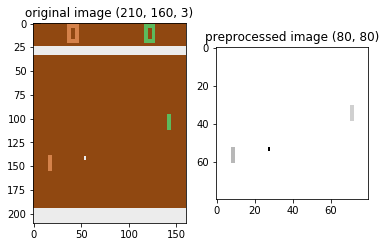

In [5]:
# show what a preprocessed image looks like
env.reset()

_, _, _, _ = env.step(0)

# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title(f'original image {frame.shape}') 

# Preprocessing Function
plt.subplot(1,2,2)
preprocessed_frame = pong_utils.preprocess_single(frame)
plt.title(f'preprocessed image {preprocessed_frame.shape}')
# 80 x 80 black and white image
plt.imshow(preprocessed_frame, cmap='Greys')
plt.show()

# Policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [6]:
# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)

class Policy(nn.Module):
    
    def __init__(self):
        super(Policy, self).__init__()
        
        # Default - 
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
        #                 stride=1, padding=0, dilation=1, groups=1, 
        #                 bias=True, padding_mode='zeros')
        #  (W−F+2P)/S+1
        
        # 80x80x2 to 38x38x4
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 17x17x8
        self.conv2 = nn.Conv2d(4, 8, kernel_size=6, stride=2, bias=False)
        # 17x17x8 to 8x8x16
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=2)
        
        self.size = 8*8*16
        
        # three fully connected layer
        self.fc1 = nn.Linear(self.size, 512)
        self.fc2 = nn.Linear(512, 256)      
        self.fc3 = nn.Linear(256, 1)
        
        # Final Sigmoid Activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """ Forward Pass """
        
        # Convolutional Layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Flatten from 8x8x16
        x = x.view(-1,self.size)
        
        # Linear Layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return self.sigmoid(x)

In [7]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


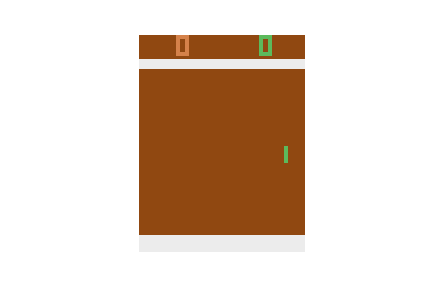
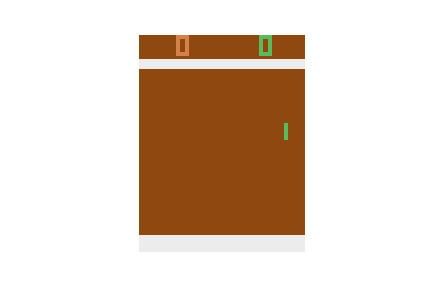
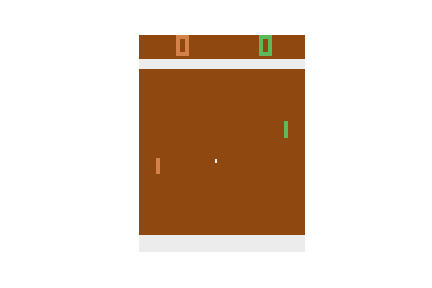
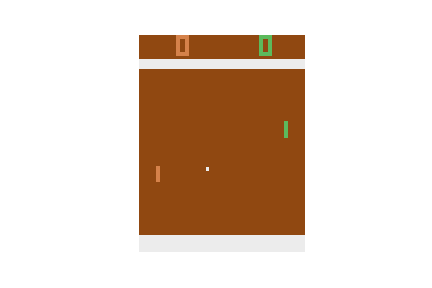
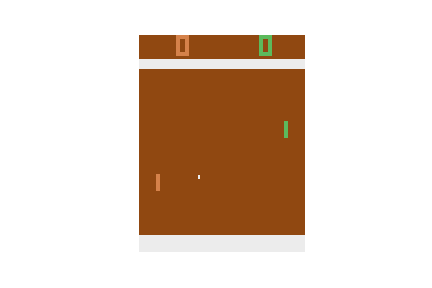
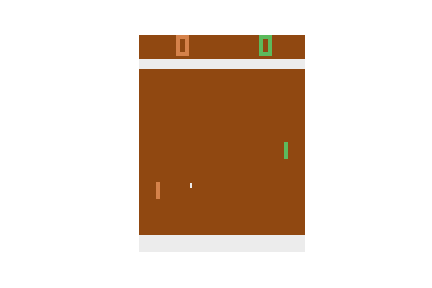
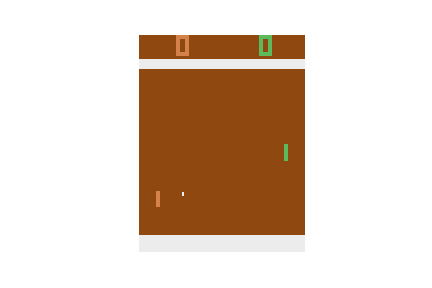
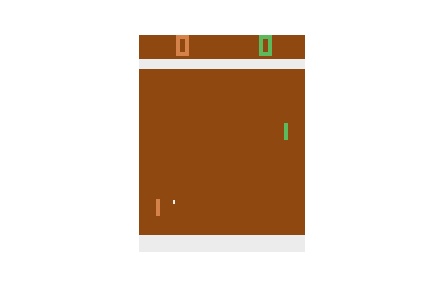
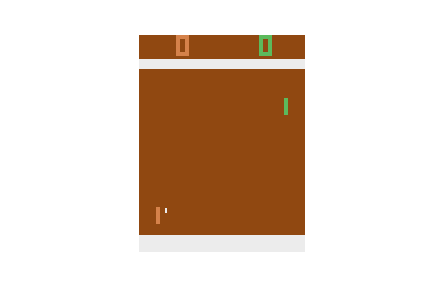
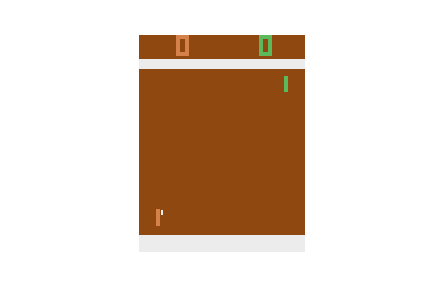
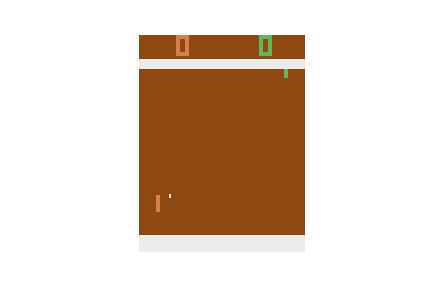
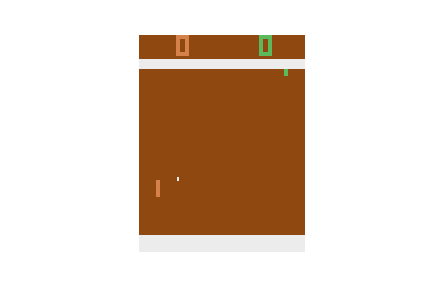
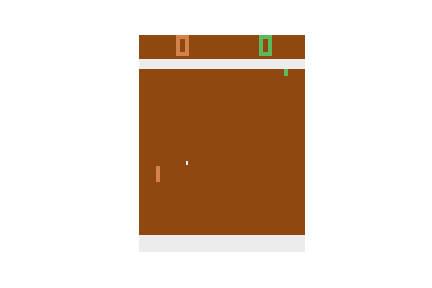
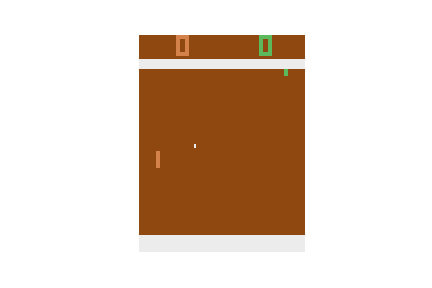
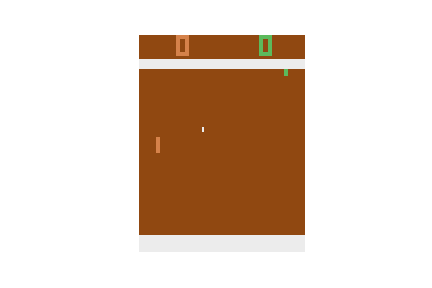
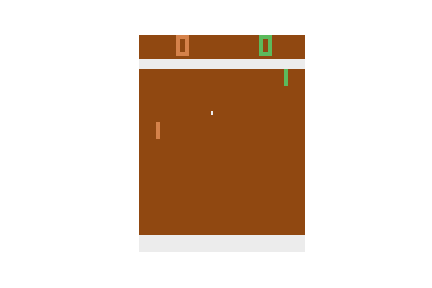
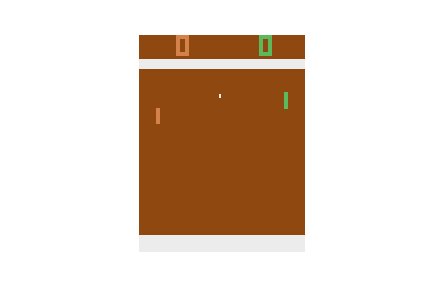
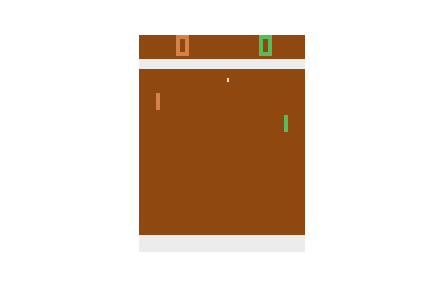
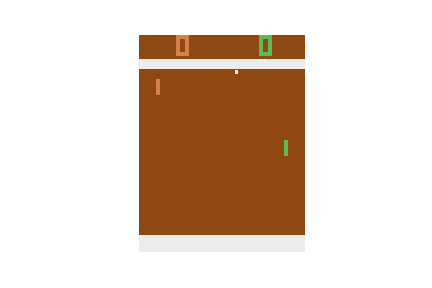
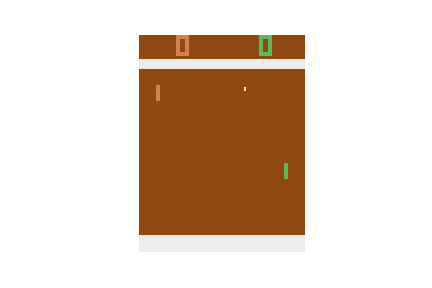
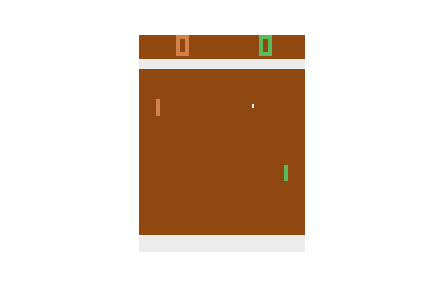
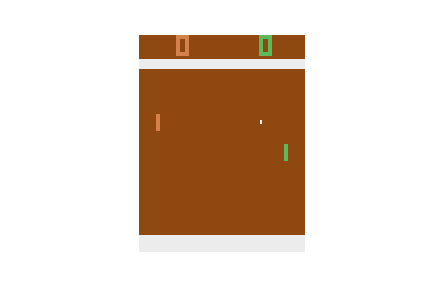
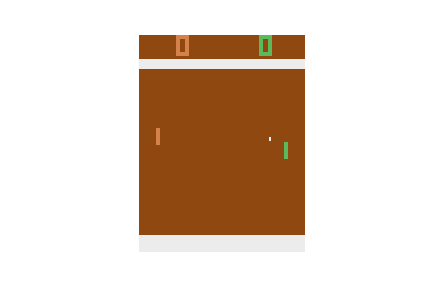
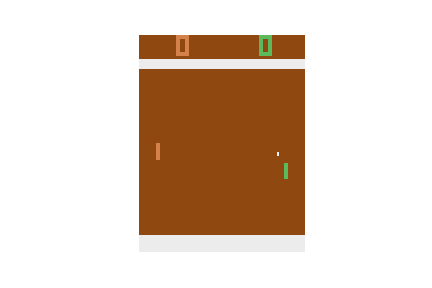
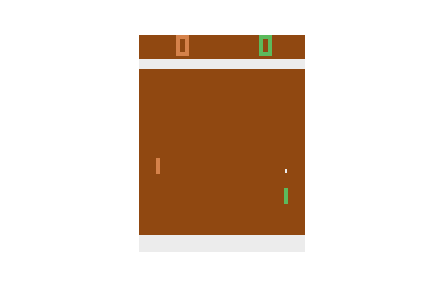
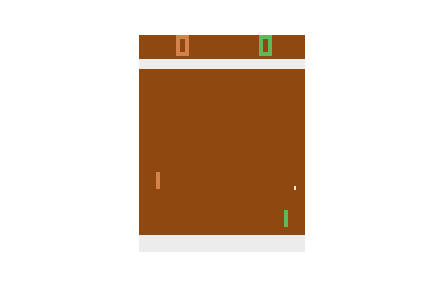
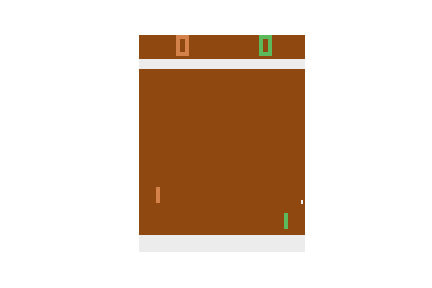
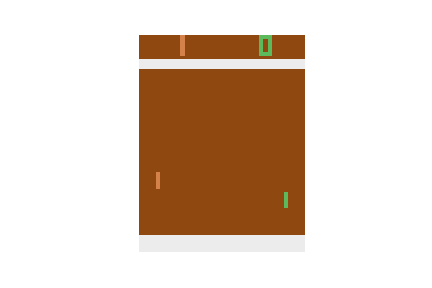
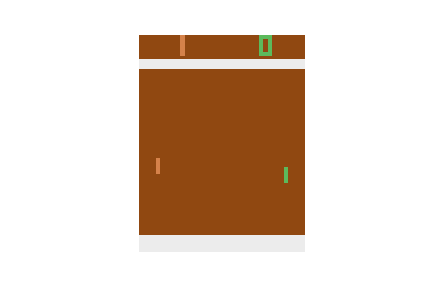
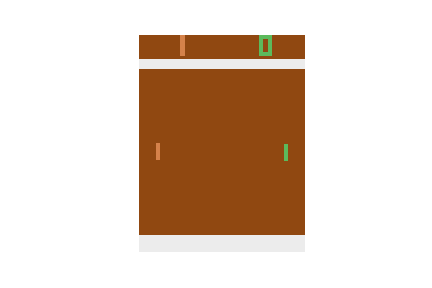
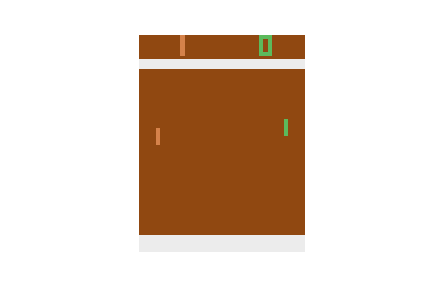
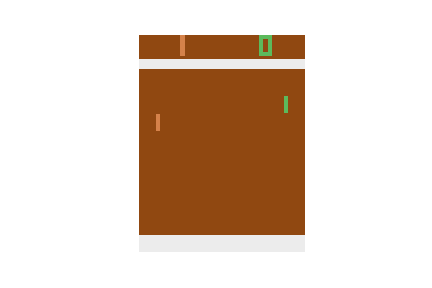
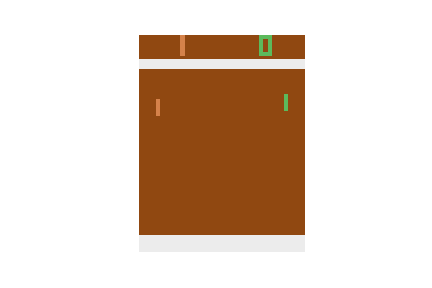
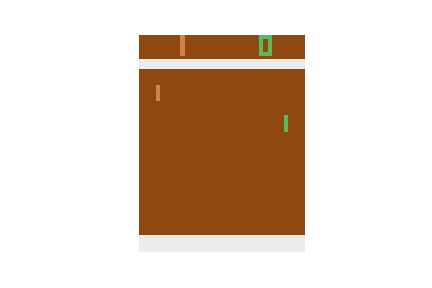
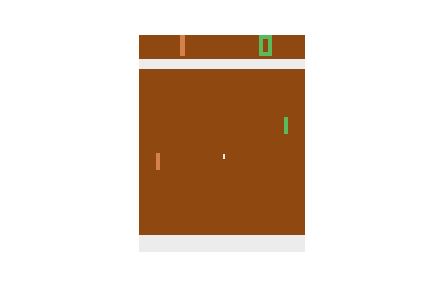
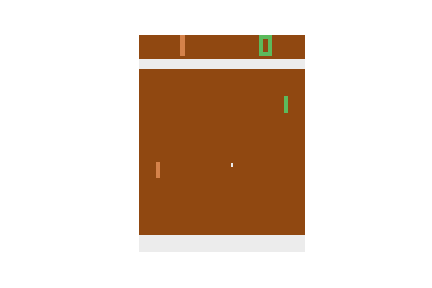
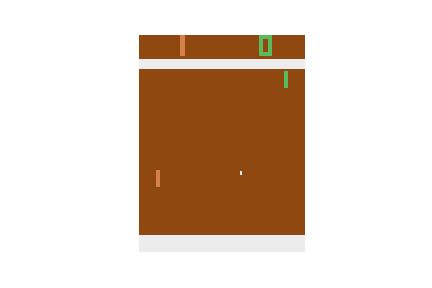
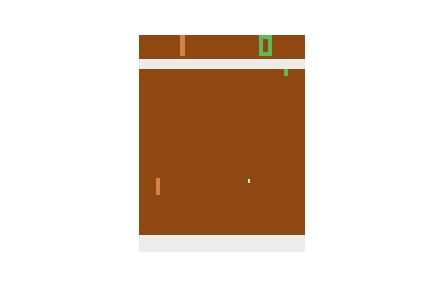
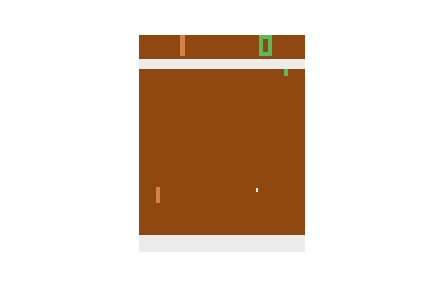
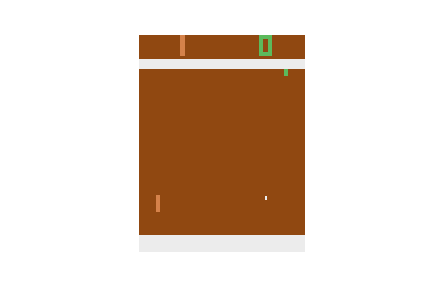
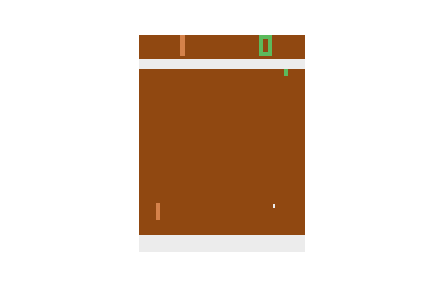
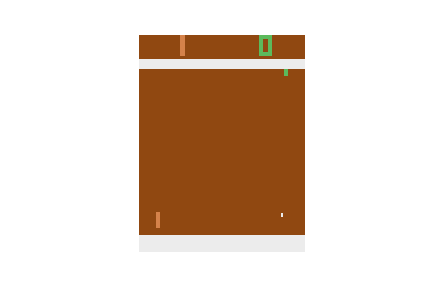
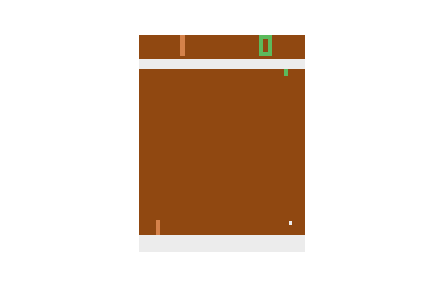
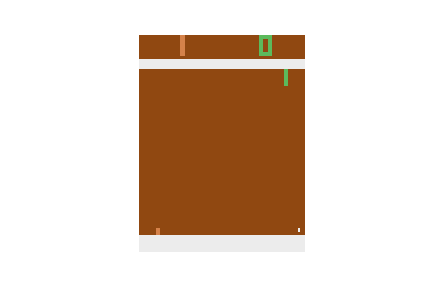
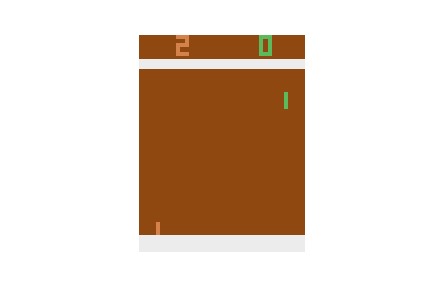
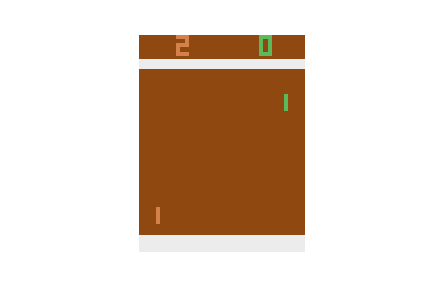
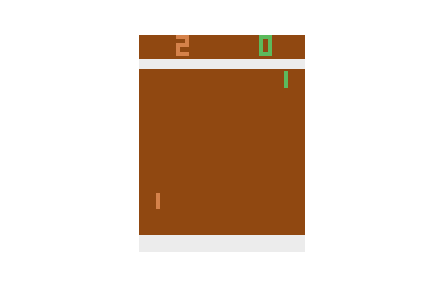
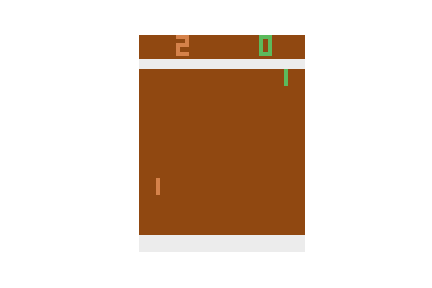
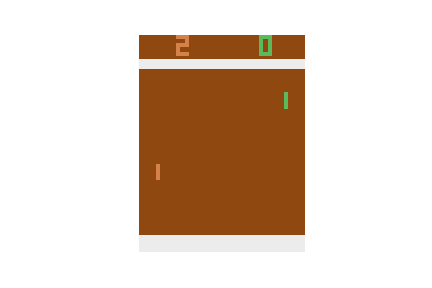
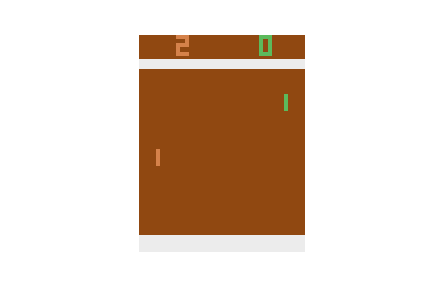
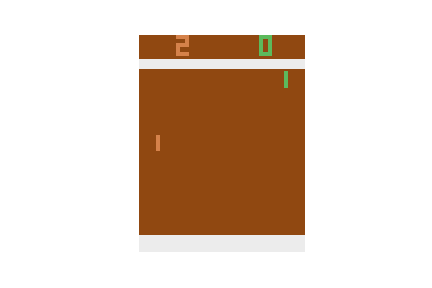
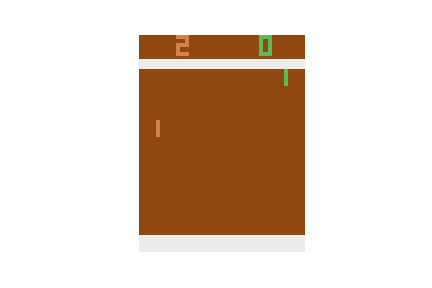
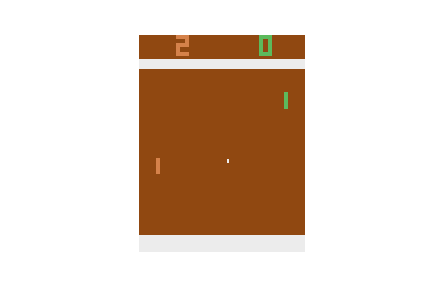
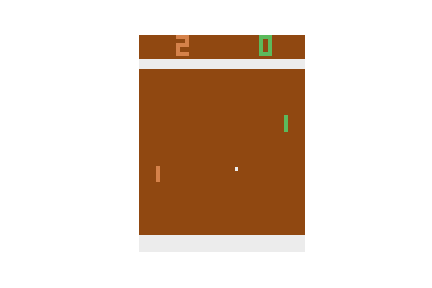
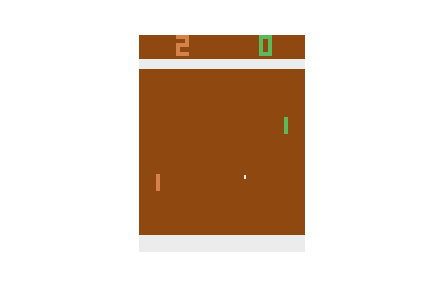
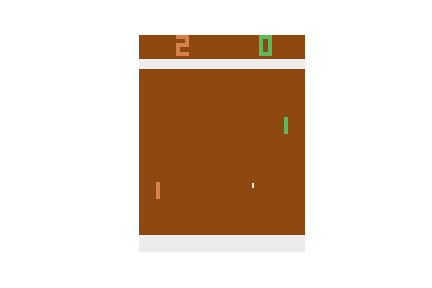
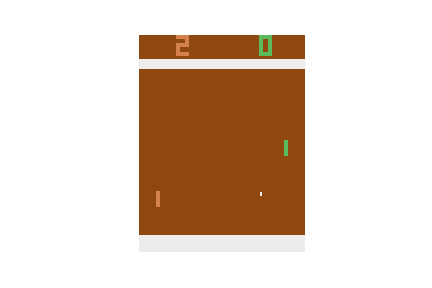
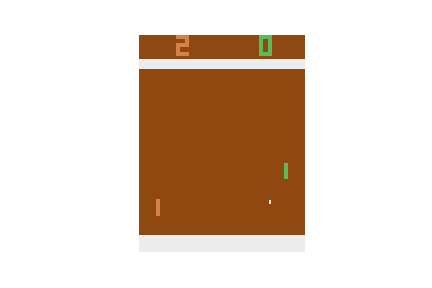
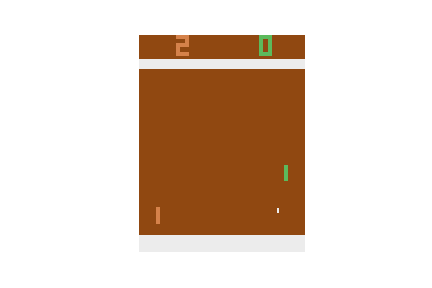
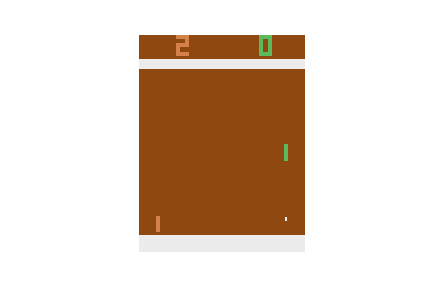
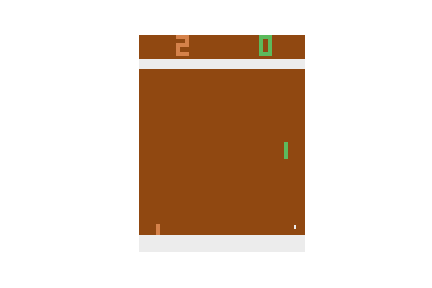
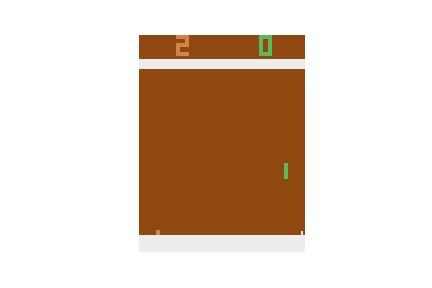
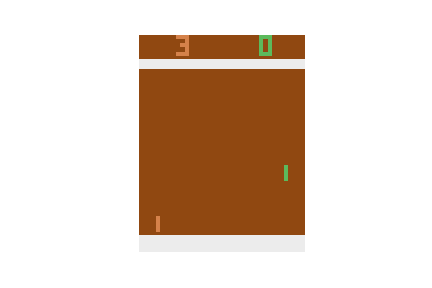
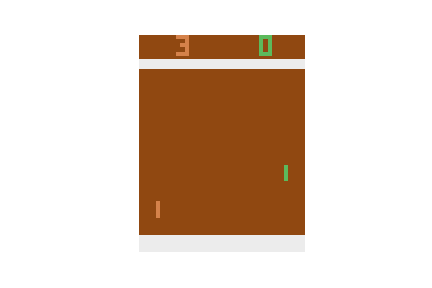
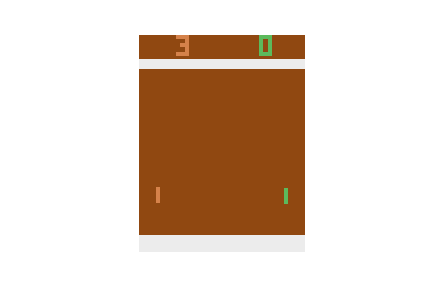
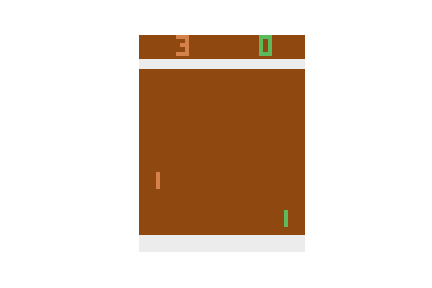
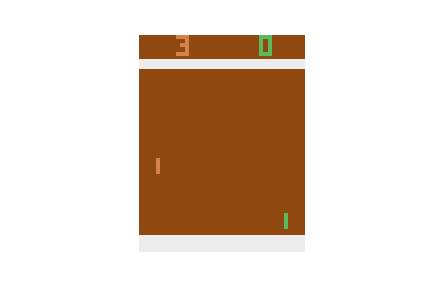
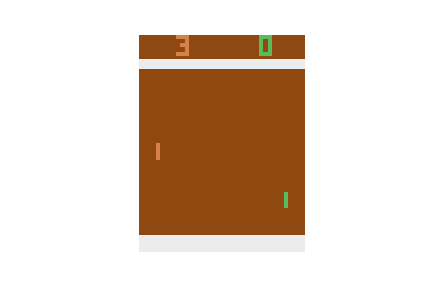
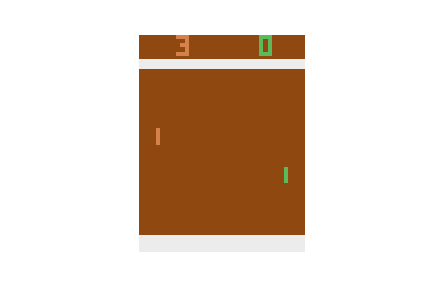
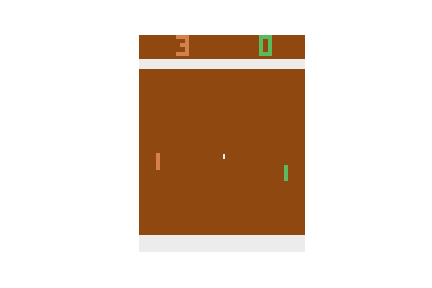
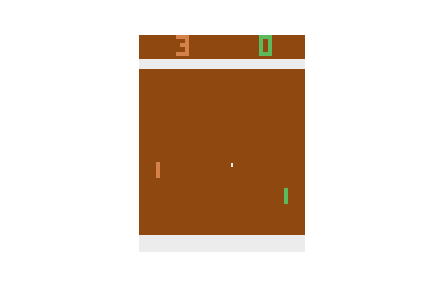
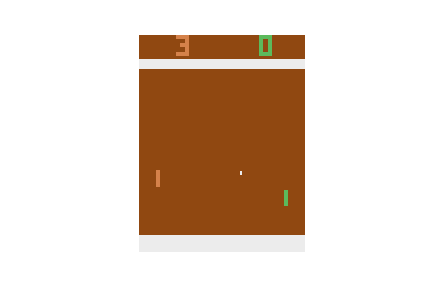
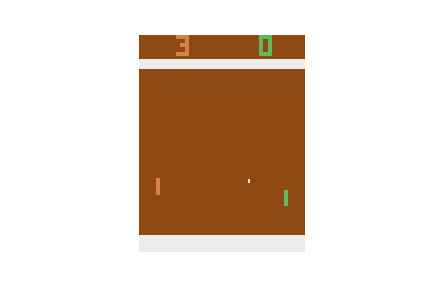
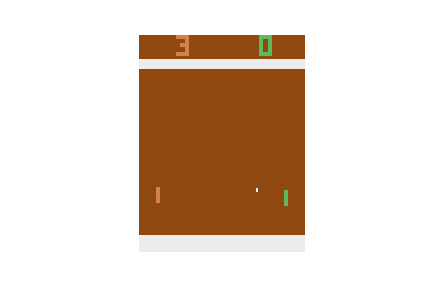
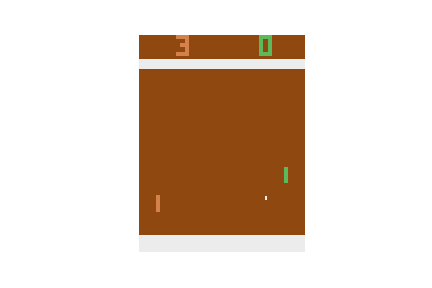
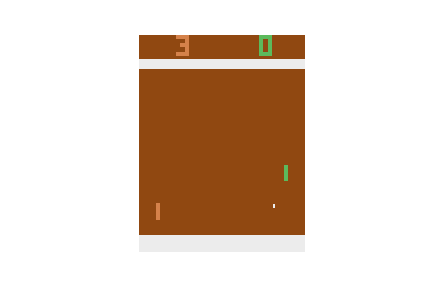
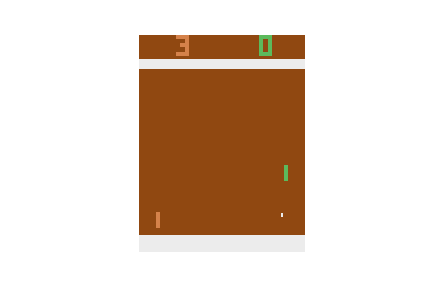
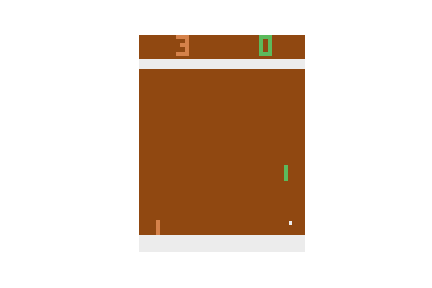
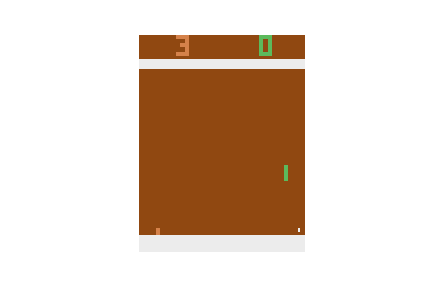
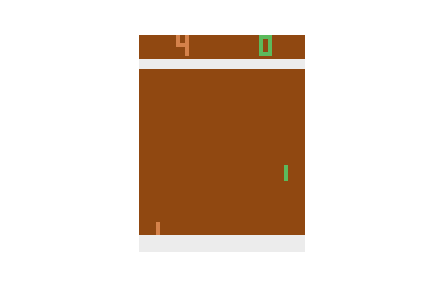
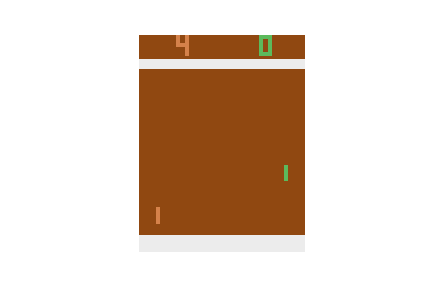
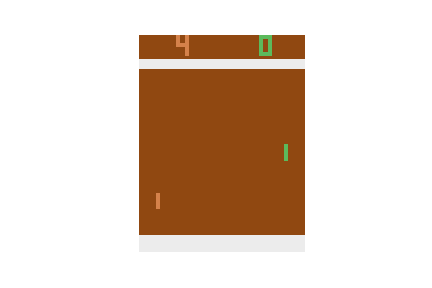
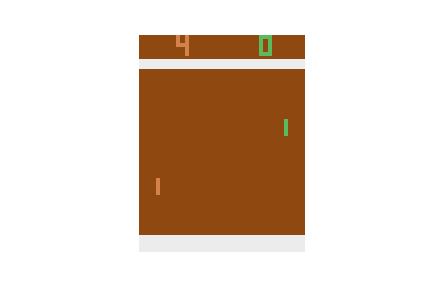
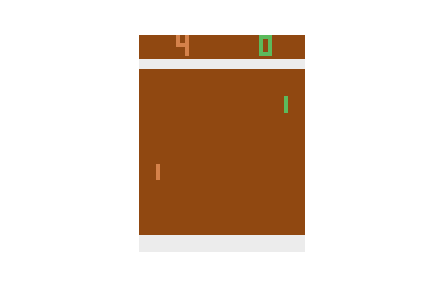
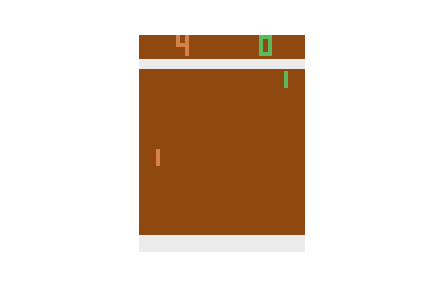
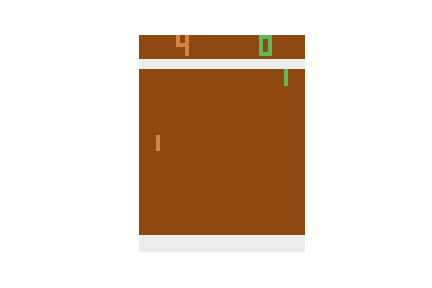
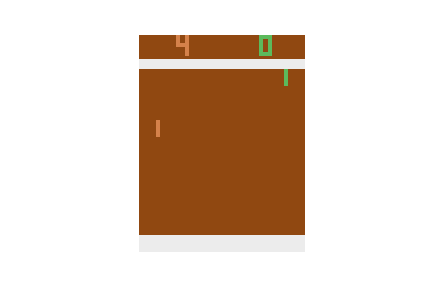
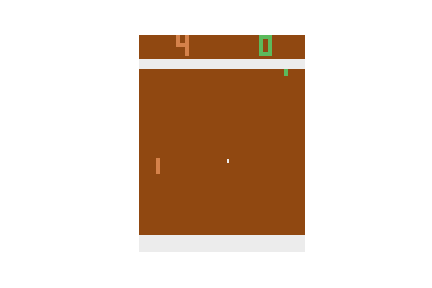
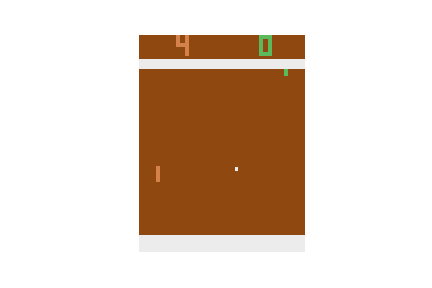
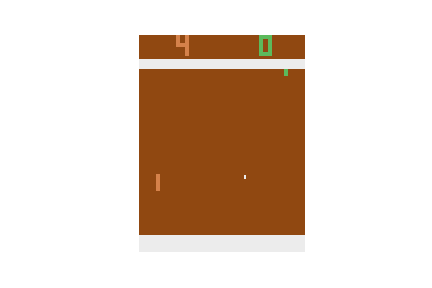
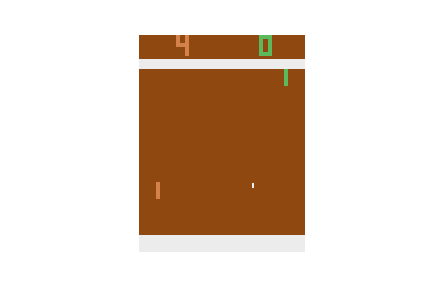
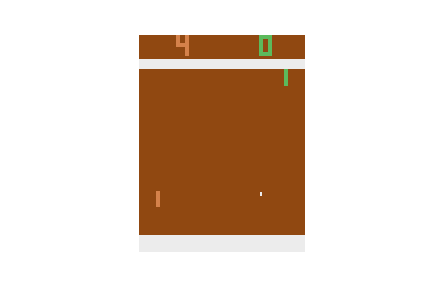
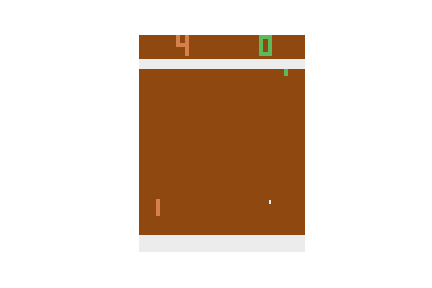
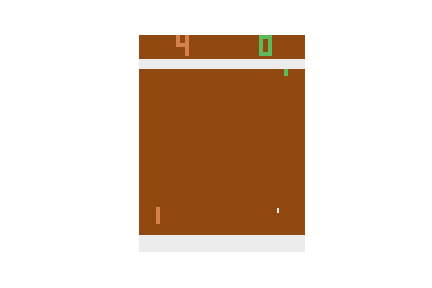
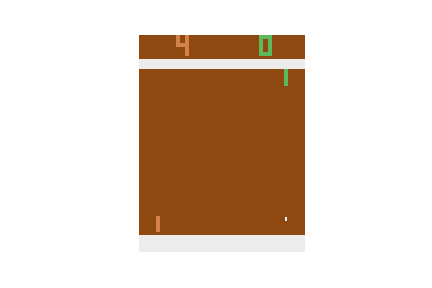
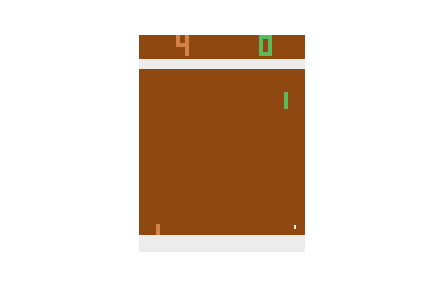
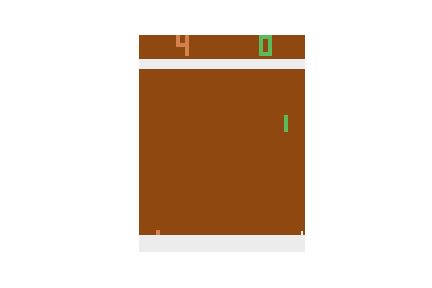
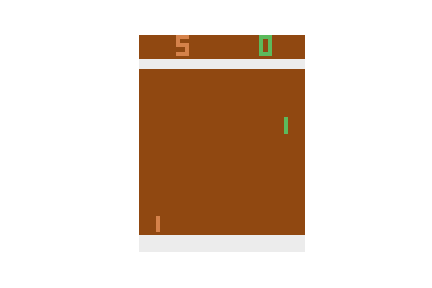
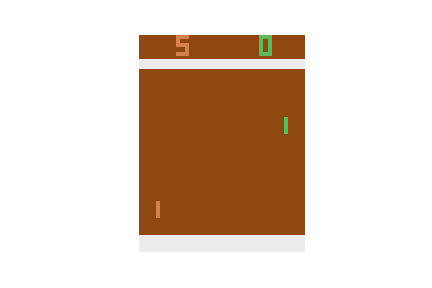
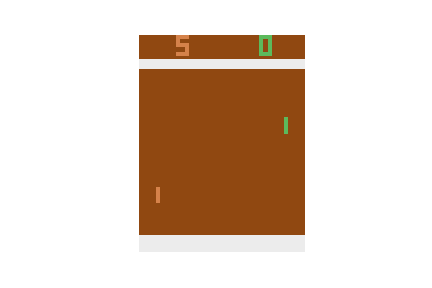

In [8]:
pong_utils.play(env, policy, time=100) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [9]:
# Collect the trajectories w/ Parallel Environment.
# n amount of Agents are collecting trajectories in parallel
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

# Function Definitions
Here you will define key functions for training. 

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [11]:
def clipped_surrogate(policy, 
                      old_probs, 
                      states, 
                      actions, 
                      rewards,
                      discount=0.995,
                      epsilon=0.1,
                      beta=0.01):
       
    # Set up our rewards
    discount = discount ** np.arange(len(rewards))
    
    # Convert the input to an array.
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards, by taking the reverse
    # cumulative sum of the elements along the 4 columns.
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1] # Reverse the list
    
    # Calculate the future reward's means along the 4 rows
    reward_mean = np.mean(rewards_future, axis=1)
    # Calculate standard deviation with, make sure non-zero
    reward_std = np.std(rewards_future, axis=1) + 1.0e-10
    
    # REWARD NORMALIZATION
    rewards_future = (rewards_future - reward_mean[:, np.newaxis])/ reward_std[:, np.newaxis]
    
    # Convert to Pytorch Tensors
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards_future = torch.tensor(rewards_future, dtype=torch.float, device=device)
    
    # convert states to probability, passing through the policy
    states = torch.stack(states) # Stack states as tensor along a column
    policy_input = states.view(-1,*states.shape[-3:]) # View input
    new_probs = policy(policy_input).view(states.shape[:-3]) # Pass through policy
    
    # torch.where(condition, x, y) → Tensor
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
    
    # Ratio for clipping
    ratio = new_probs/old_probs

    # clipped function - if ratio is out of range, cap it
    # Clamp all elements in input into the range [ min, max ] and return a resulting tensor:
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards_future, clip*rewards)
    
    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    
    # The return is the mean of the policy gradient across 4 agents at each timestep
    return torch.mean(clipped_surrogate + beta*entropy)

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [12]:
# training loop max iterations
episode = 800

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
trajectory_cycle = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(trajectory_cycle):
        
        # uncomment to utilize your own clipped function!
        # L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
                                          epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

Episode: 20, score: -14.125000
[-17. -14. -12. -13. -13. -17. -11. -16.]


Episode: 40, score: -14.500000
[-14. -14. -12. -15. -16. -13. -16. -16.]


Episode: 60, score: -14.625000
[-13. -15. -13. -15. -15. -16. -14. -16.]


Episode: 80, score: -14.750000
[-14. -16. -13. -17. -13. -14. -15. -16.]


Episode: 100, score: -14.500000
[-16. -10. -13. -16. -17. -16. -16. -12.]


Episode: 120, score: -15.125000
[-15. -16. -16. -12. -16. -15. -16. -15.]


Episode: 140, score: -13.375000
[-15. -13. -16. -10. -16. -14. -15.  -8.]


Episode: 160, score: -13.000000
[-10. -14. -13. -16. -12. -16. -12. -11.]


Episode: 180, score: -12.000000
[ -7. -14. -13. -11. -11. -14. -12. -14.]


Episode: 200, score: -10.750000
[-15. -12. -11.  -8.  -9.  -8.  -7. -16.]


Episode: 220, score: -9.875000
[-12. -11.  -8.  -6. -11.  -9.  -9. -13.]


Episode: 240, score: -5.250000
[-9. -7. -2.  2. -4. -5. -8. -9.]


Episode: 260, score: -3.000000
[-2. -3. -2. -4. -4. -5.  0. -4.]


Episode: 280, score: -0.375000
[ 0. -1. -2.  3. -1. -2.  0.  0.]


Episode: 300, score: -0.750000
[ 0.  0. -1. -1.  0.  0. -1. -3.]


Episode: 320, score: -1.750000
[-2. -2. -1. -1. -6. -3.  0.  1.]


Episode: 340, score: -1.000000
[ 0.  0.  0.  0. -7. -2.  0.  1.]


Episode: 360, score: -0.250000
[ 0.  1. -1. -2.  0.  0.  1. -1.]


Episode: 380, score: 0.250000
[-1. -1.  0.  1.  3.  1. -2.  1.]


Episode: 400, score: 0.625000
[ 1.  1.  0.  0.  1.  1.  1.  0.]


Episode: 420, score: 0.750000
[ 1. -1.  1.  1.  1.  1.  1.  1.]


Episode: 440, score: 1.000000
[ 1.  1.  2.  0.  1.  1.  1.  1.]


Episode: 460, score: 1.000000
[ 0.  1.  2.  1.  1.  1.  1.  1.]


Episode: 480, score: 0.500000
[-1.  1.  1.  1. -1.  1.  1.  1.]


Episode: 500, score: 0.500000
[ 1.  0.  0. -1.  1.  1.  1.  1.]


Episode: 520, score: 1.000000
[ 1.  1.  3.  0.  1.  1.  1.  0.]


Episode: 540, score: 2.875000
[ 5.  1.  3.  3.  3.  2.  3.  3.]


Episode: 560, score: 3.875000
[ 5.  0.  5.  5.  3.  5.  5.  3.]


Episode: 580, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 600, score: 4.625000
[ 3.  5.  3.  5.  5.  5.  5.  6.]


Episode: 620, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 640, score: 4.750000
[ 5.  3.  5.  5.  5.  5.  5.  5.]


Episode: 660, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 680, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 700, score: 4.750000
[ 5.  5.  5.  5.  5.  5.  3.  5.]


Episode: 720, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 740, score: 4.500000
[ 3.  5.  5.  5.  3.  5.  5.  5.]


Episode: 760, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 780, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 800, score: 4.750000
[ 5.  5.  5.  5.  3.  5.  5.  5.]



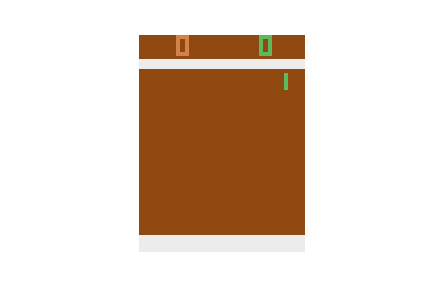
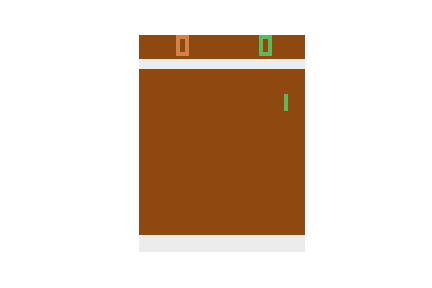
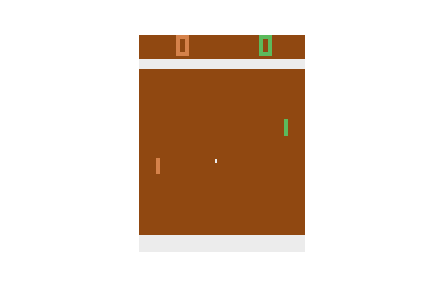
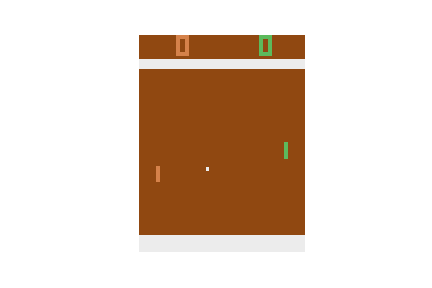
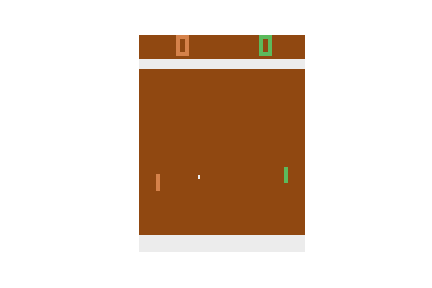
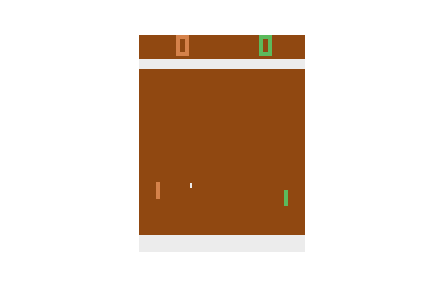
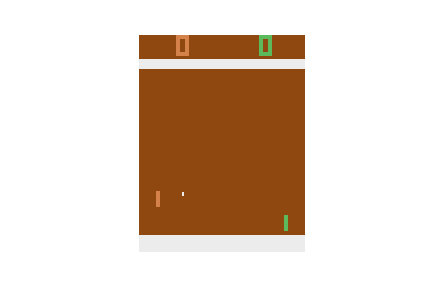
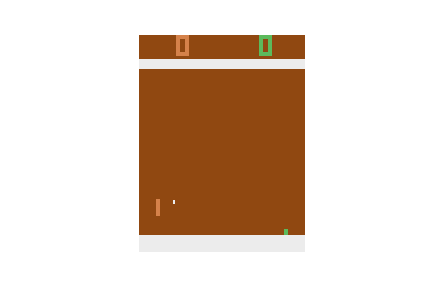
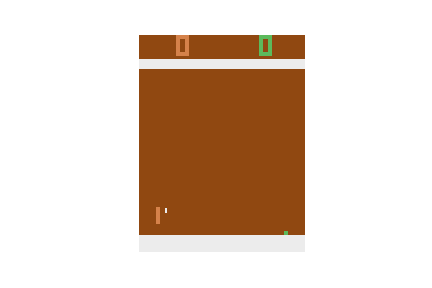
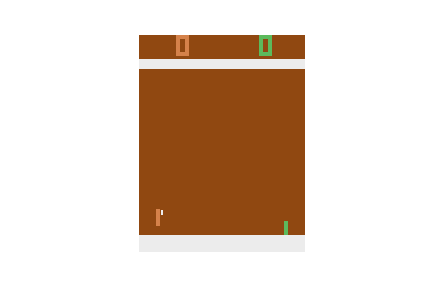
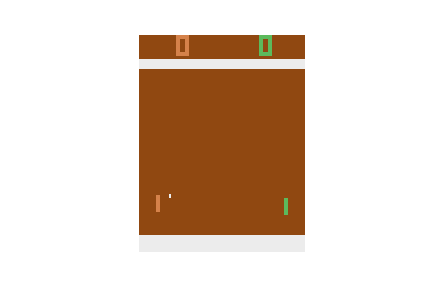
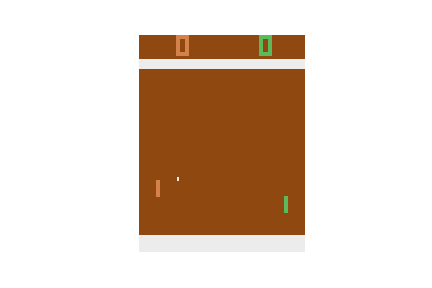
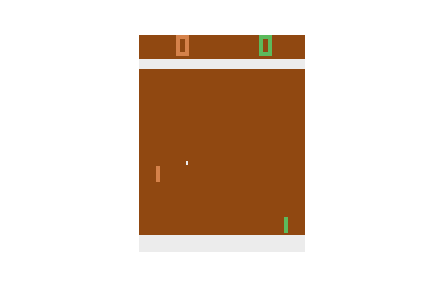
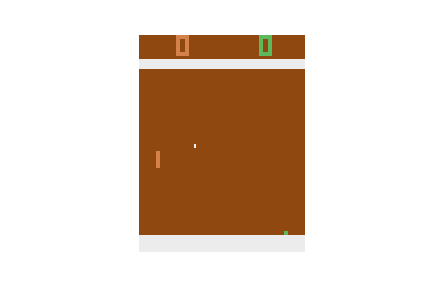
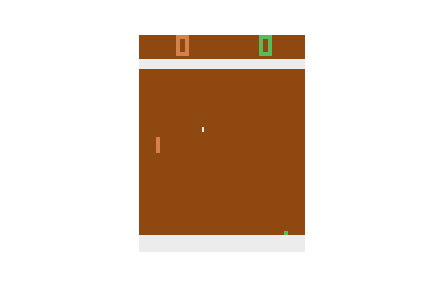
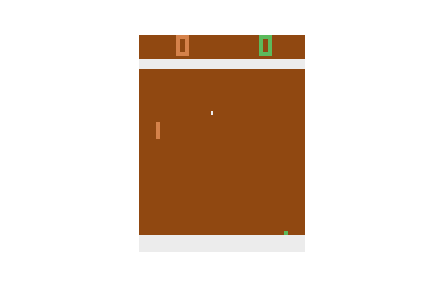
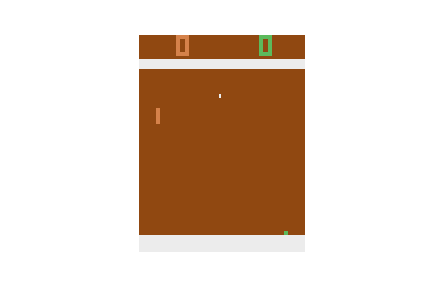
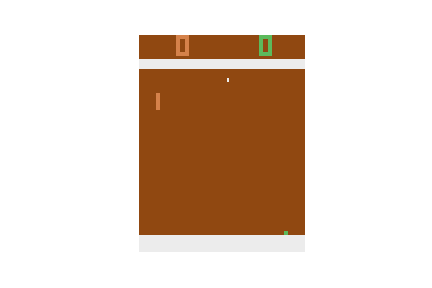
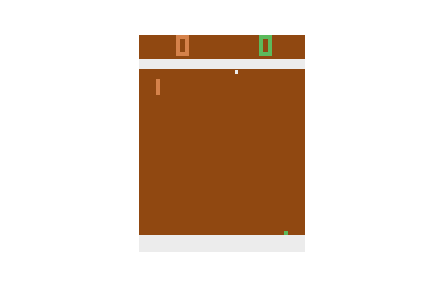
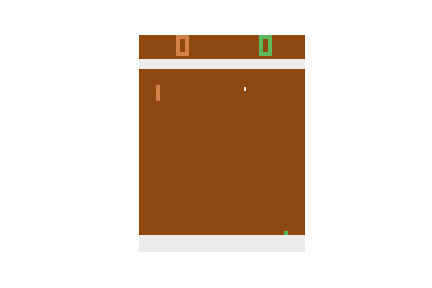
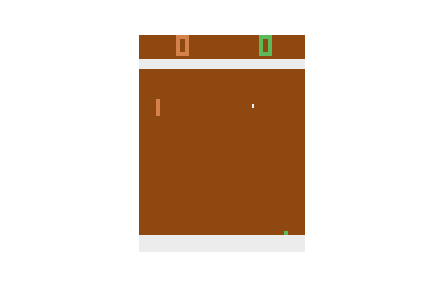
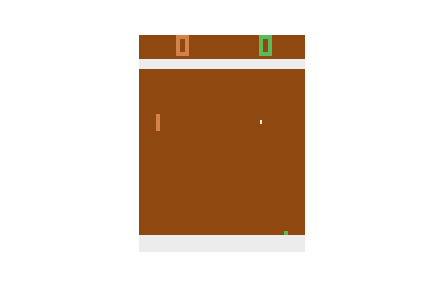
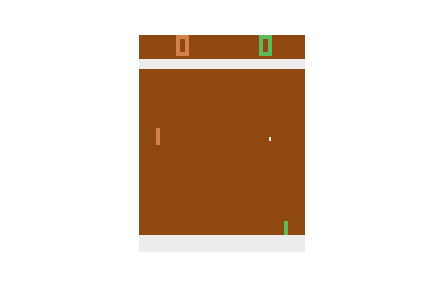
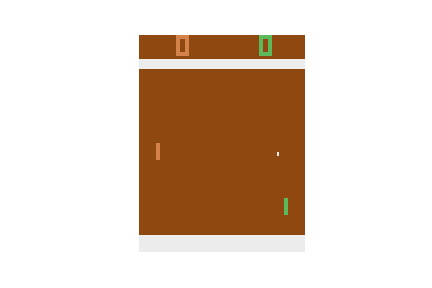
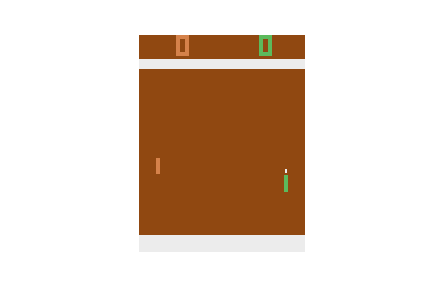
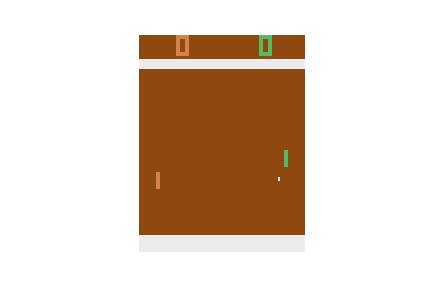
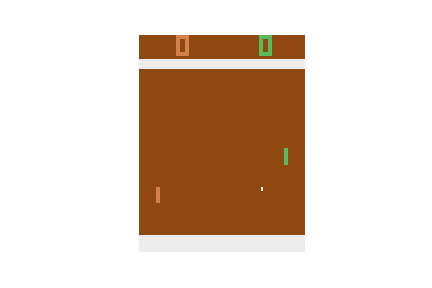
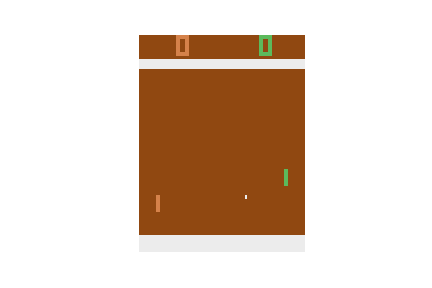
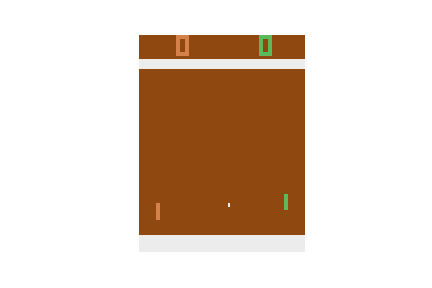
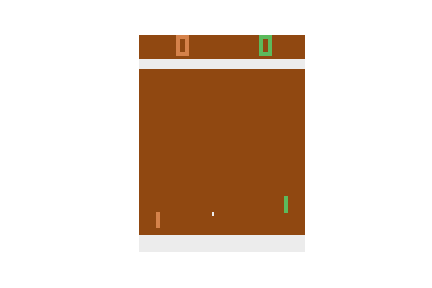
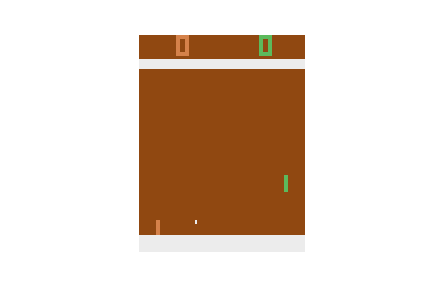
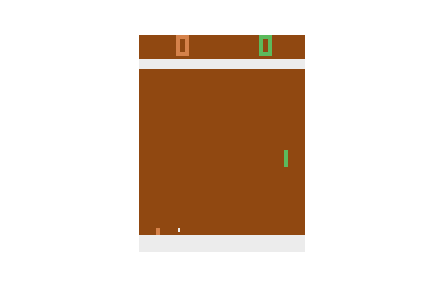
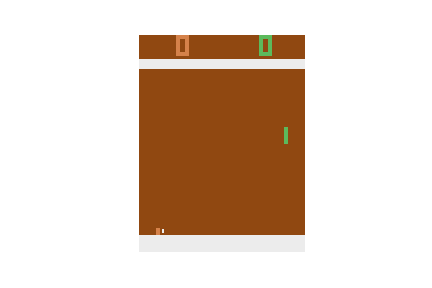
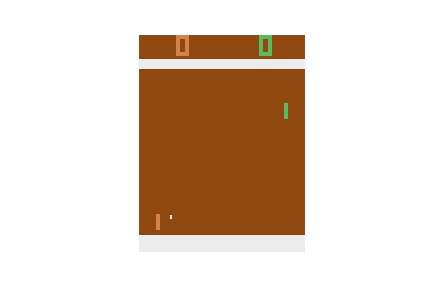
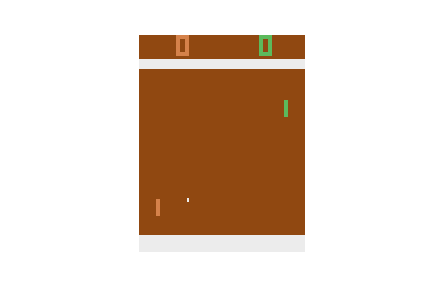
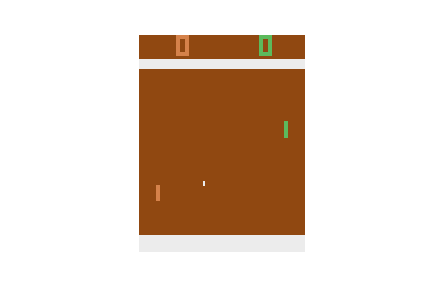
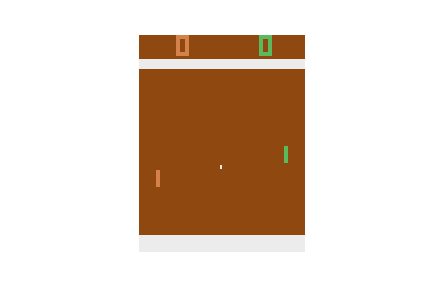
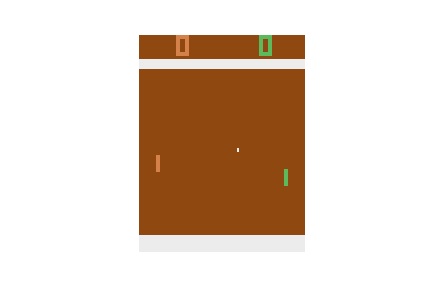
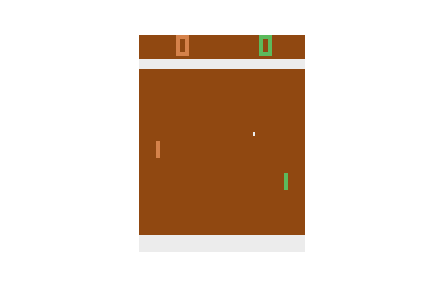
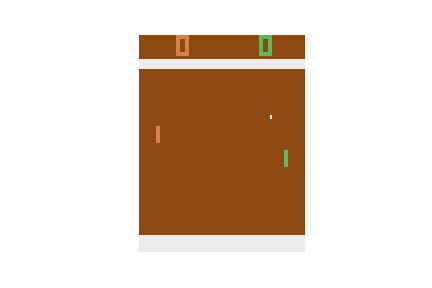
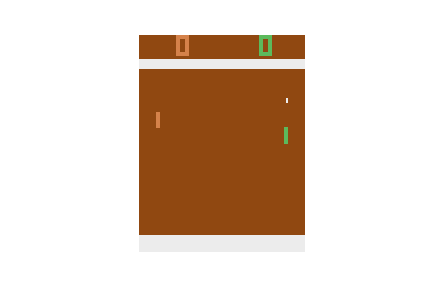
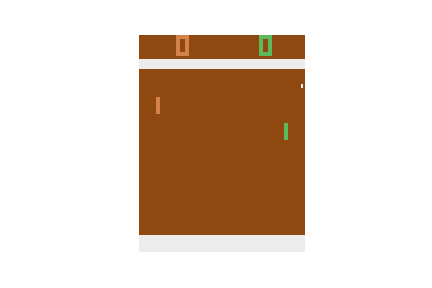
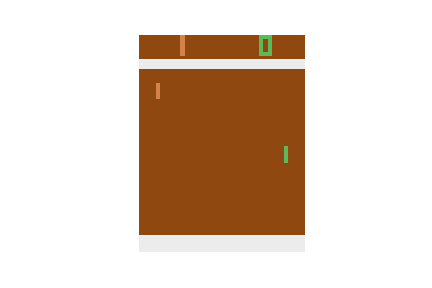
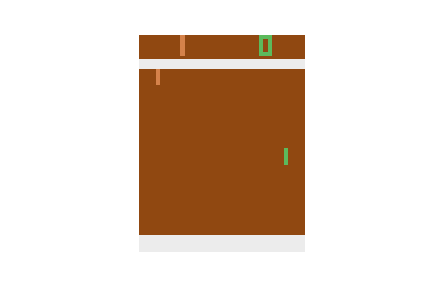
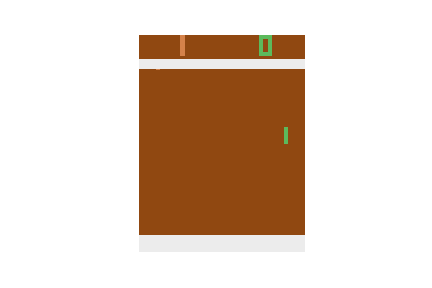
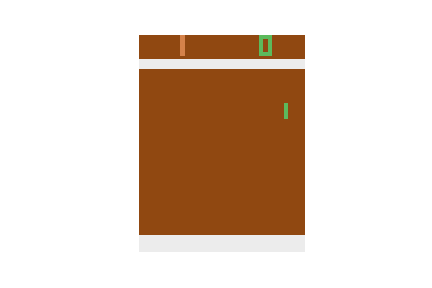
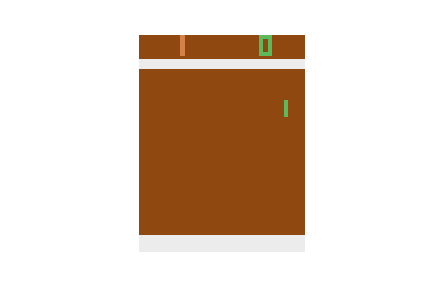
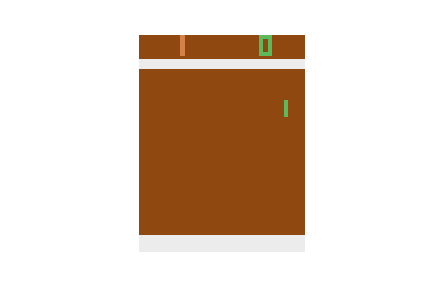
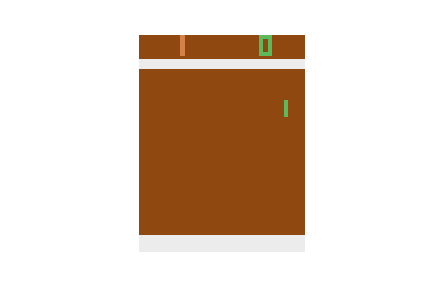
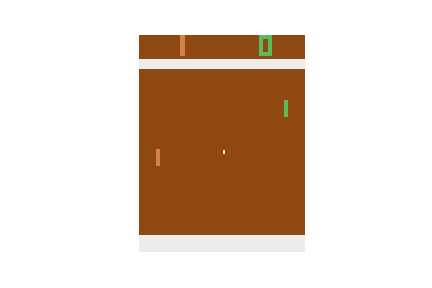
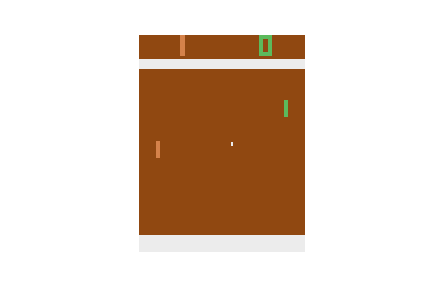
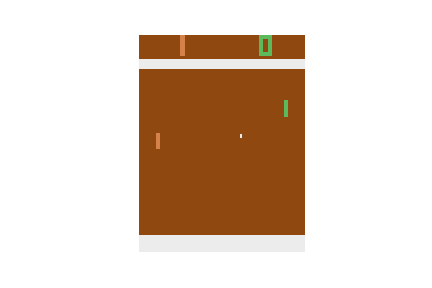
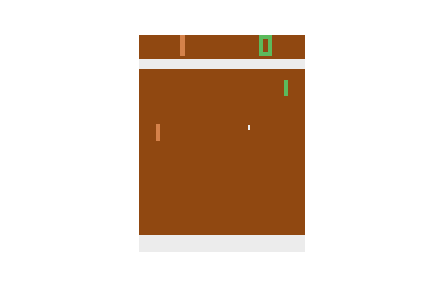
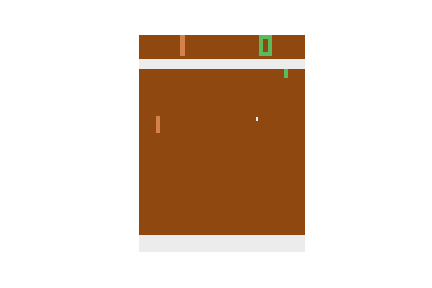
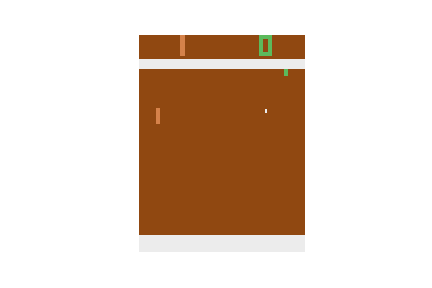
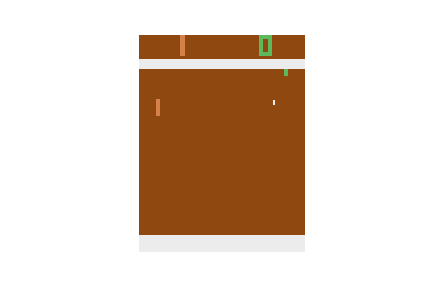
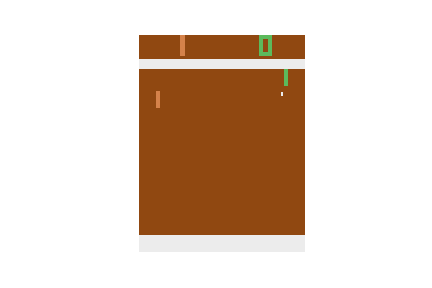
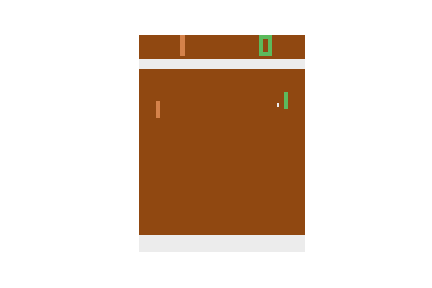
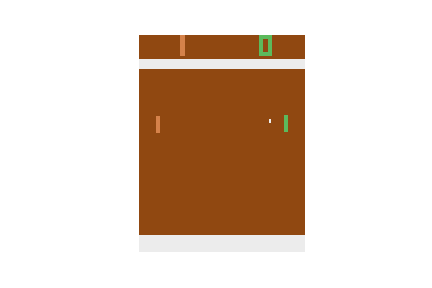
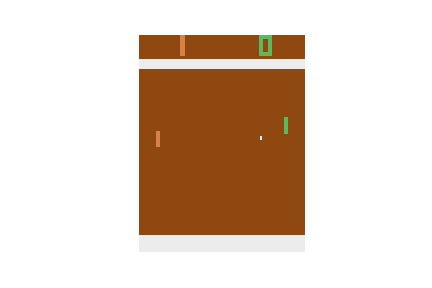
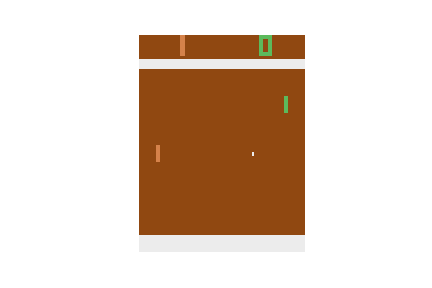
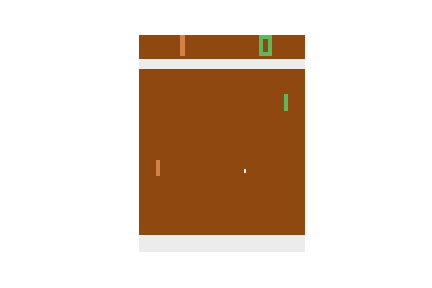
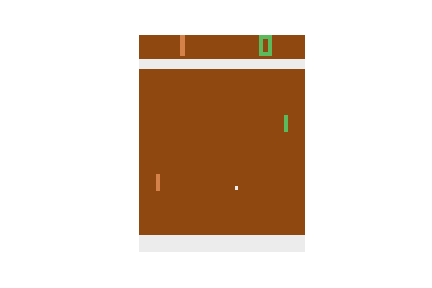
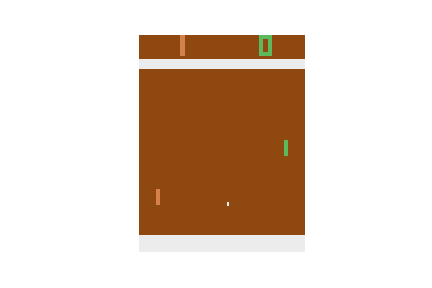
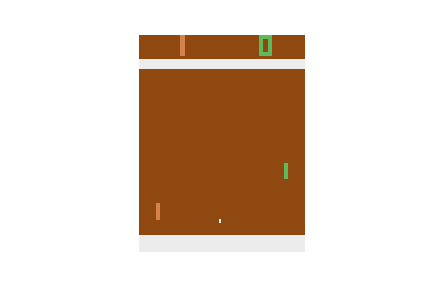
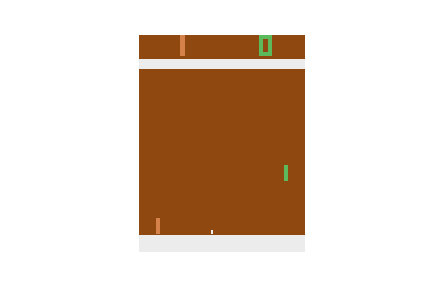
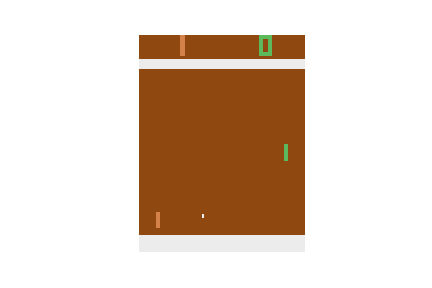
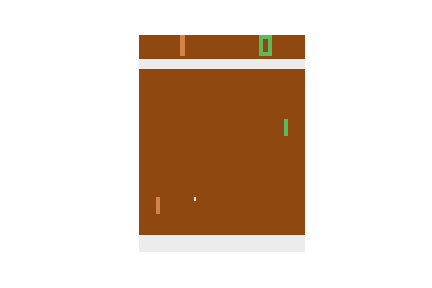
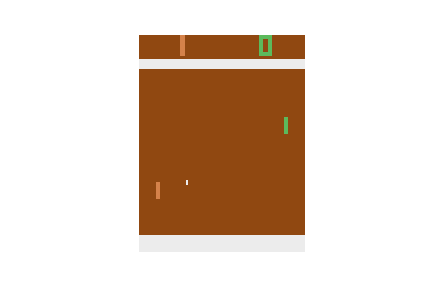
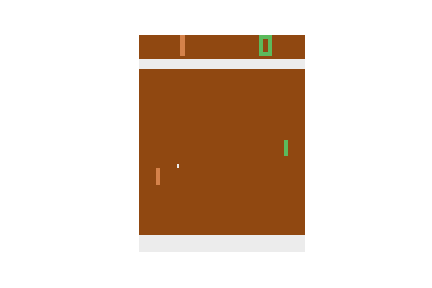
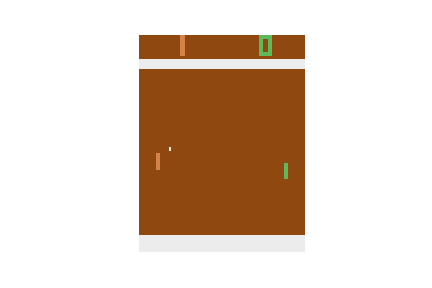
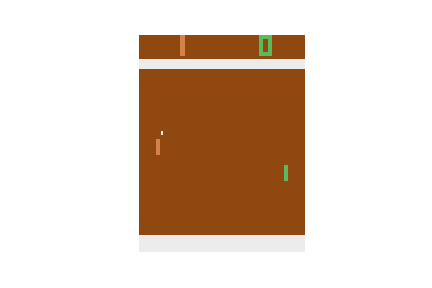
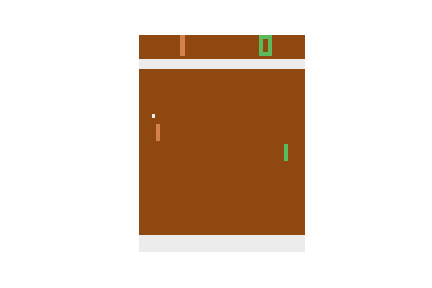
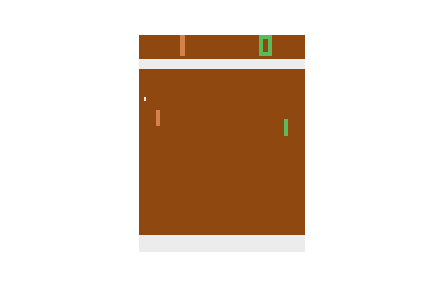
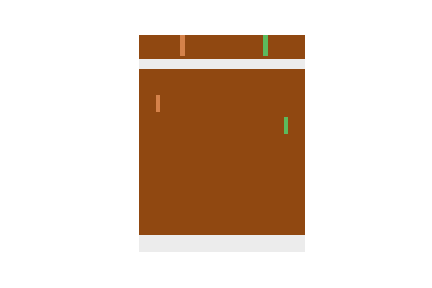
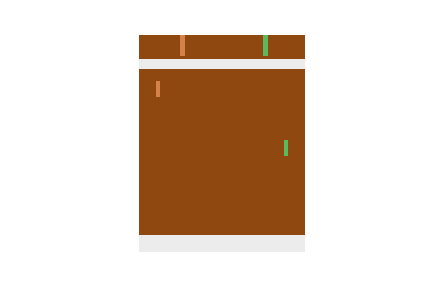
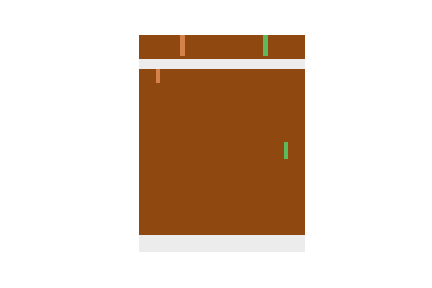
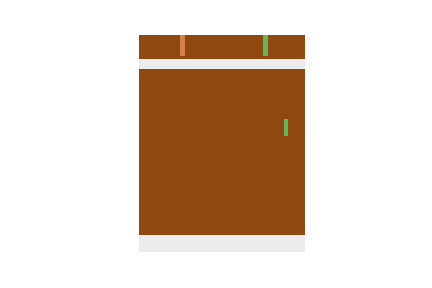
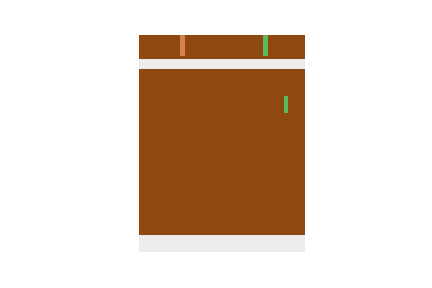
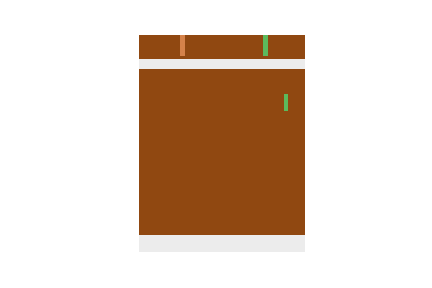
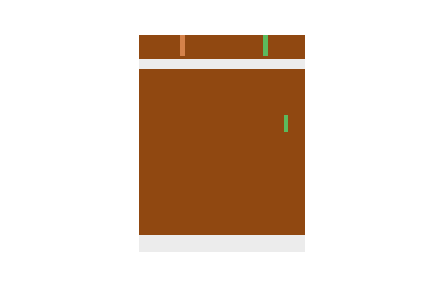
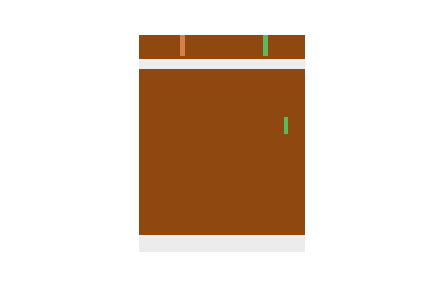
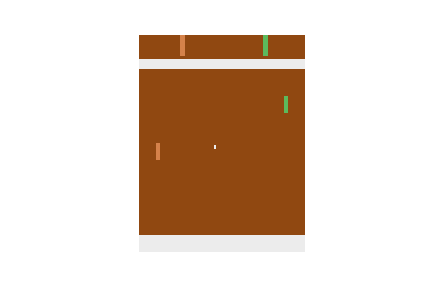
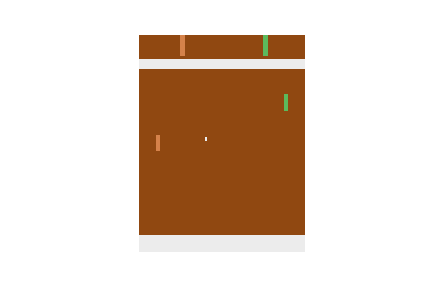
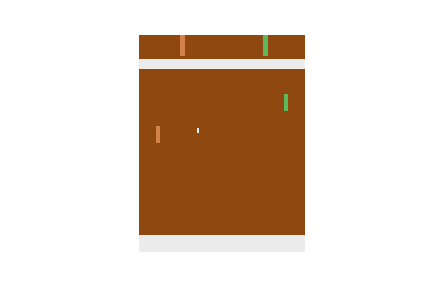
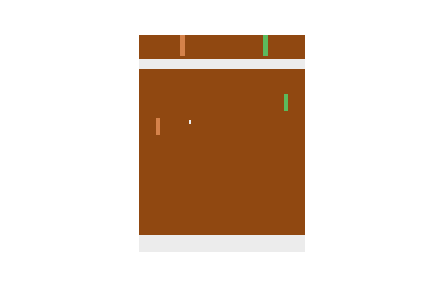
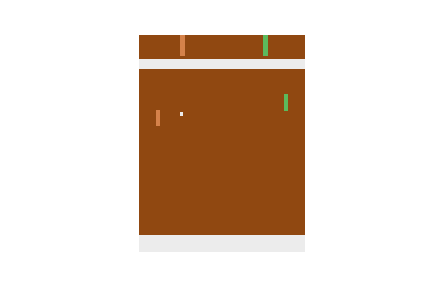
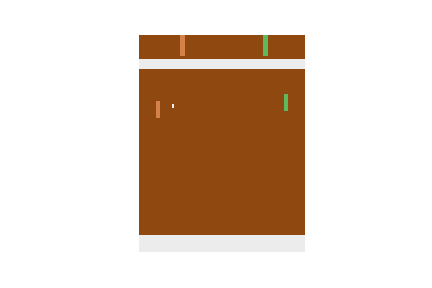
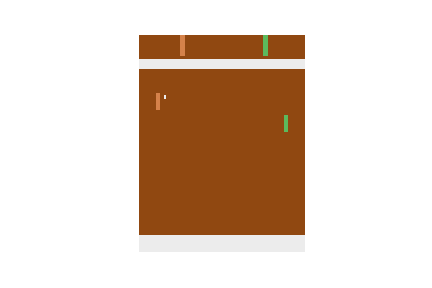
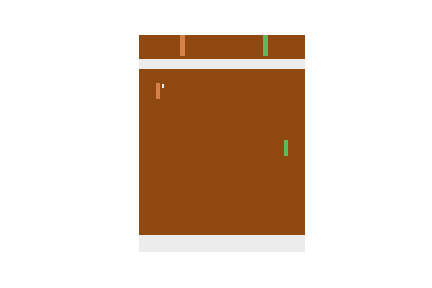
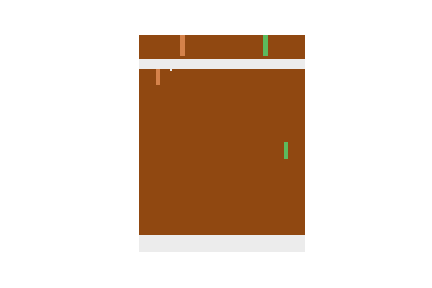
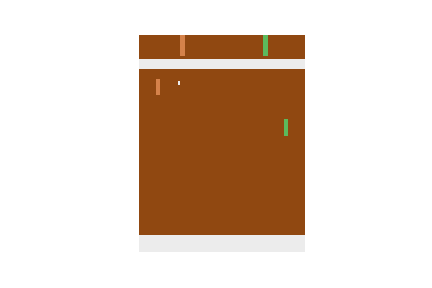
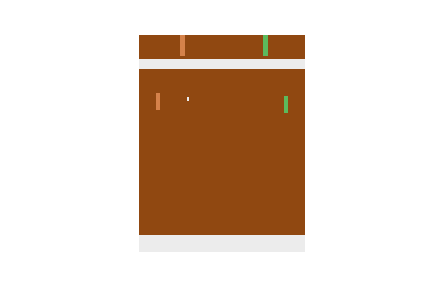
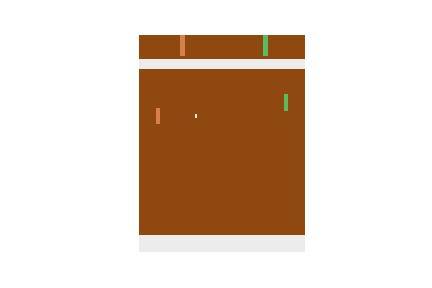
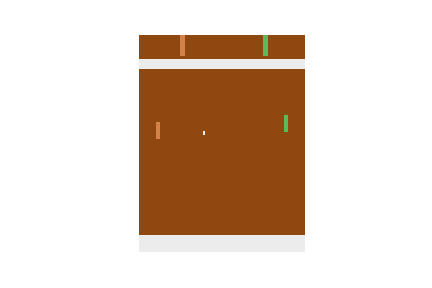
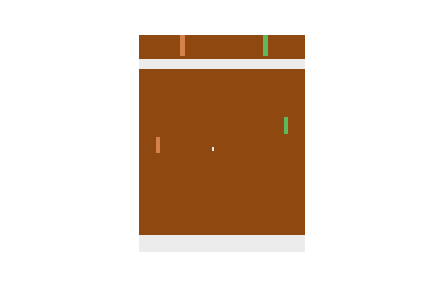
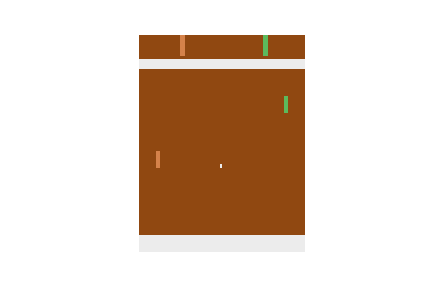
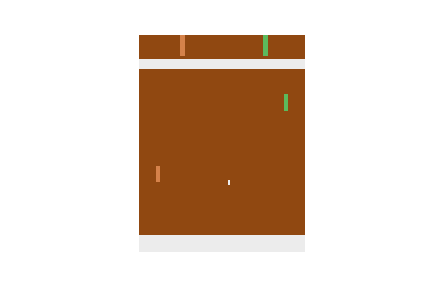
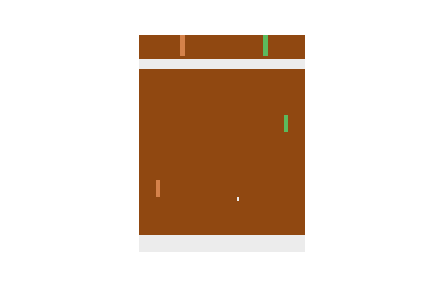
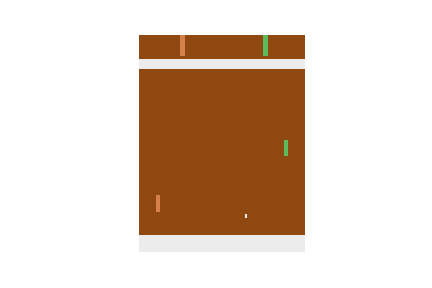
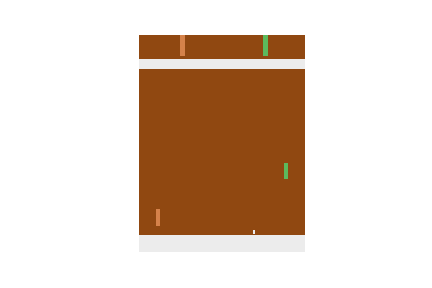
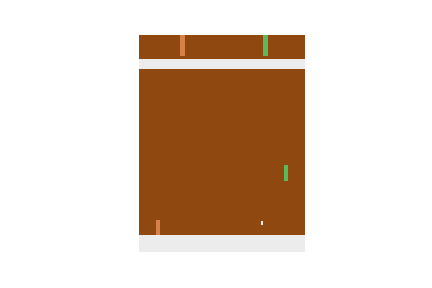
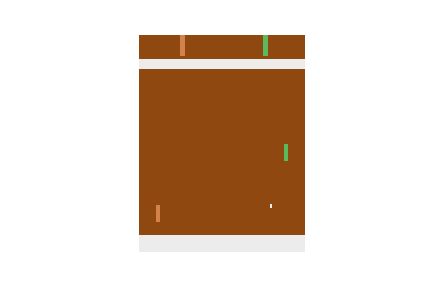
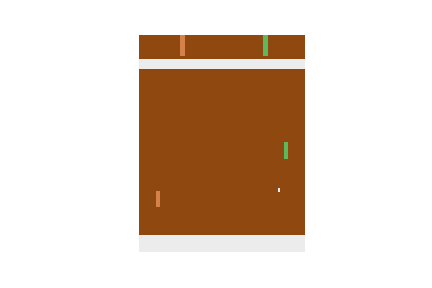
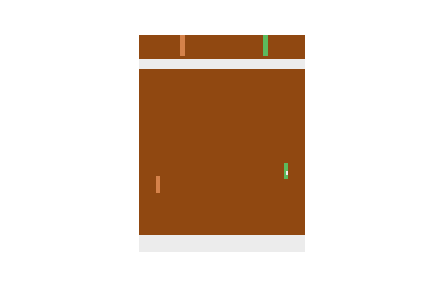
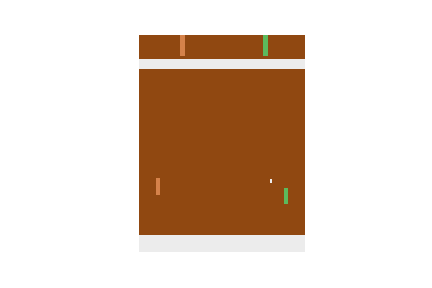
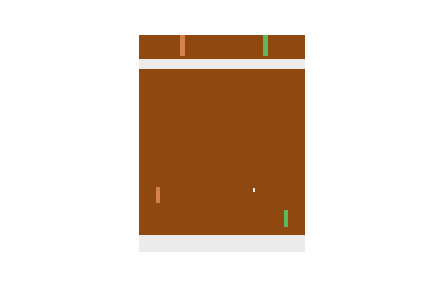
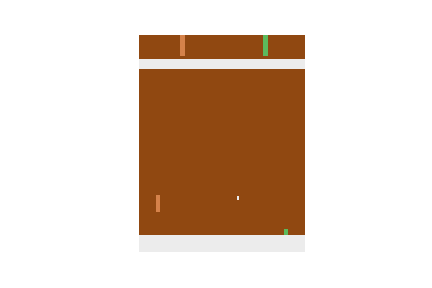
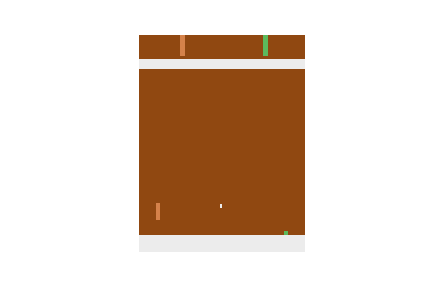
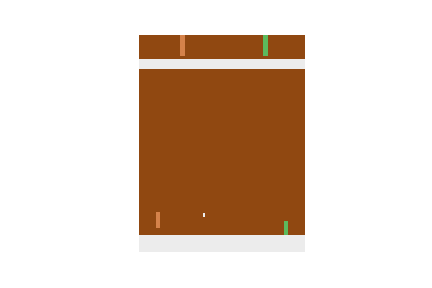
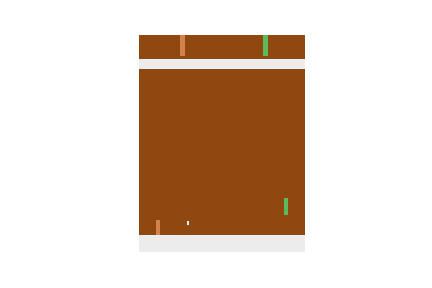
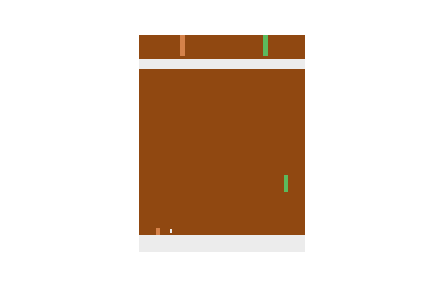
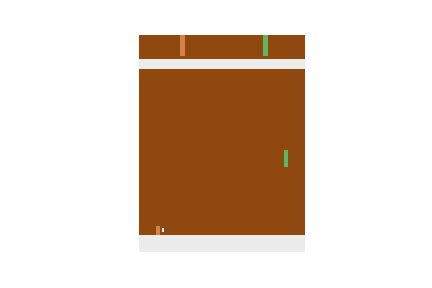
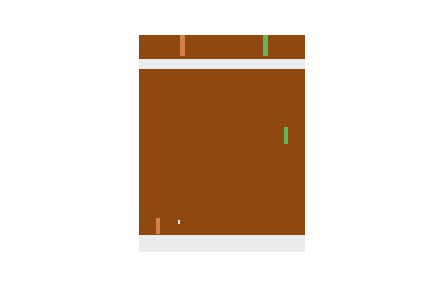
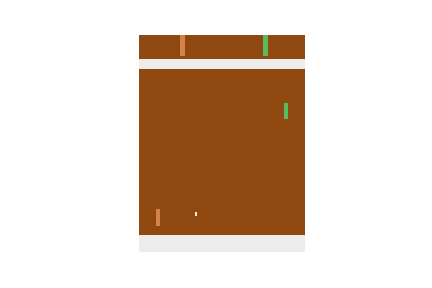
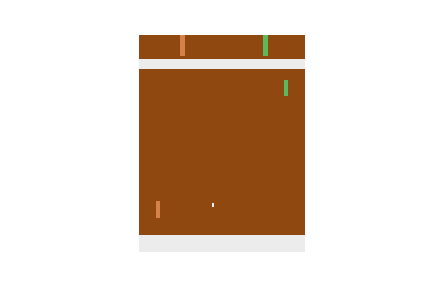
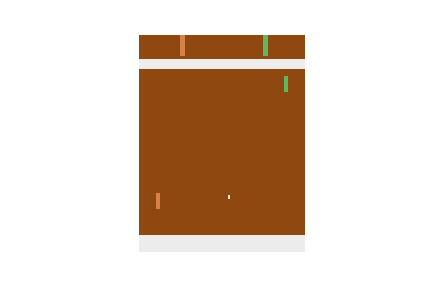
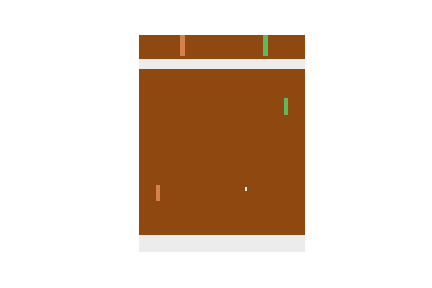
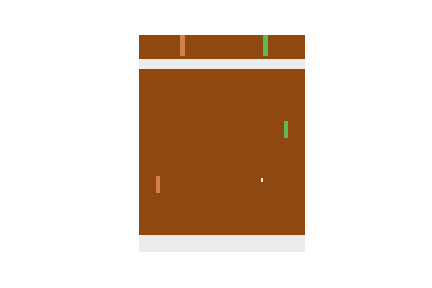
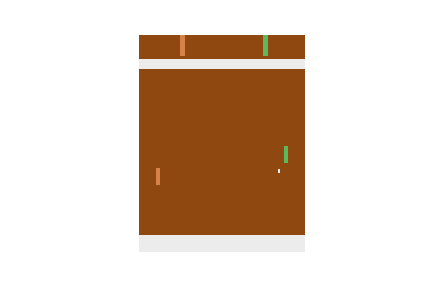
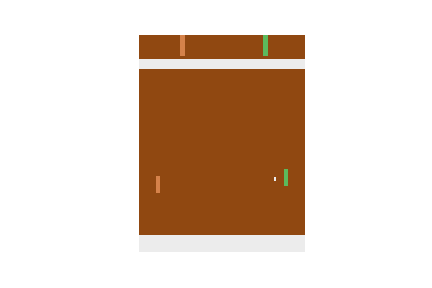
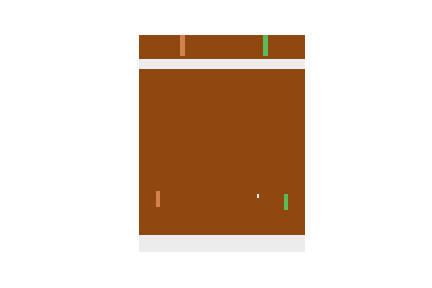
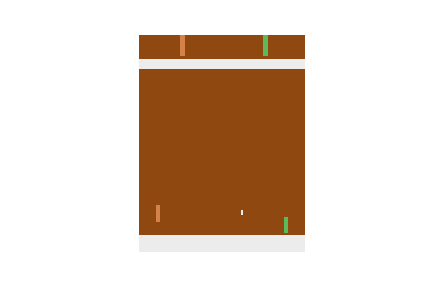
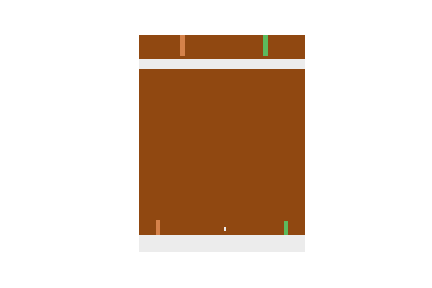
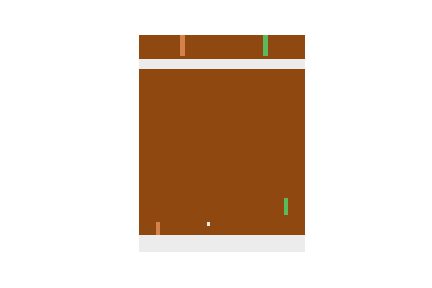
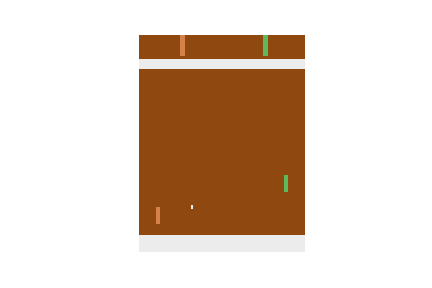
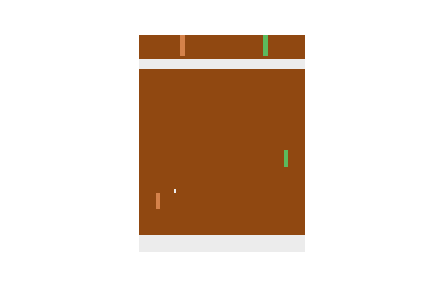
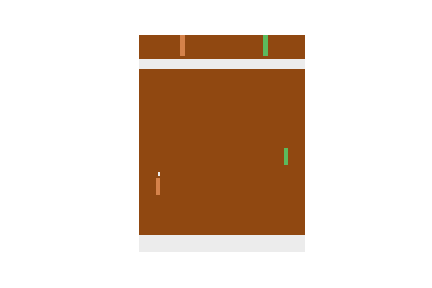
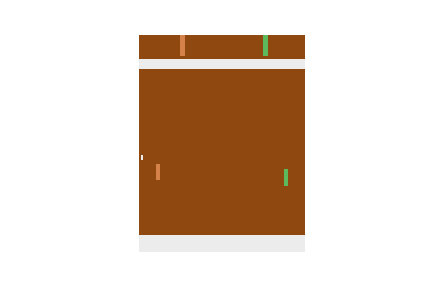
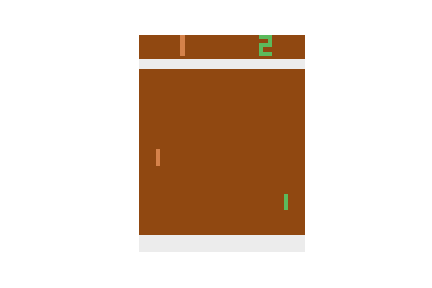
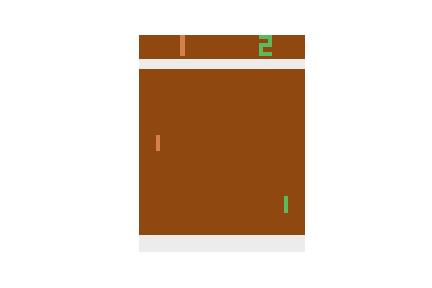
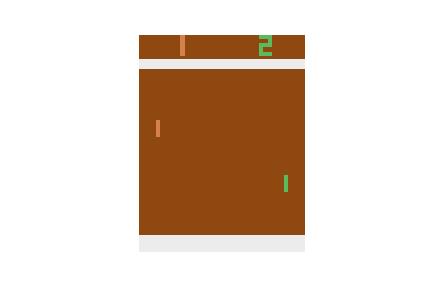
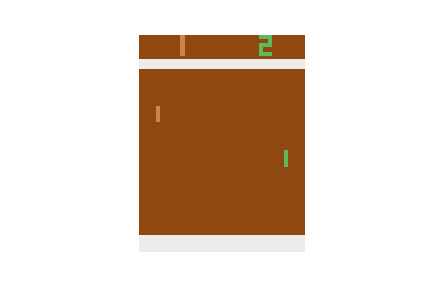
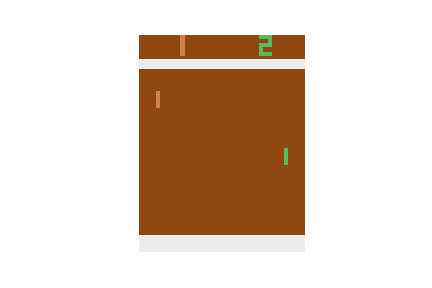
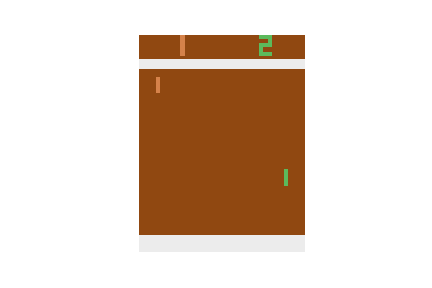
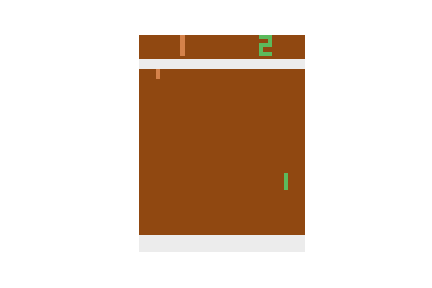
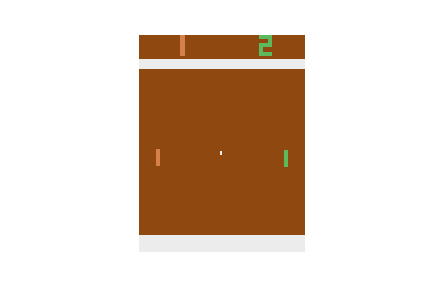
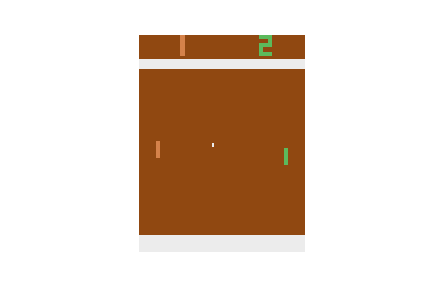
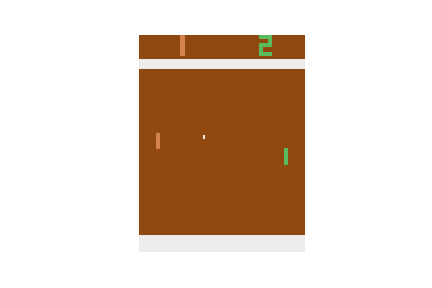
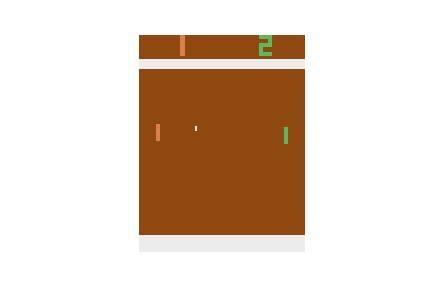
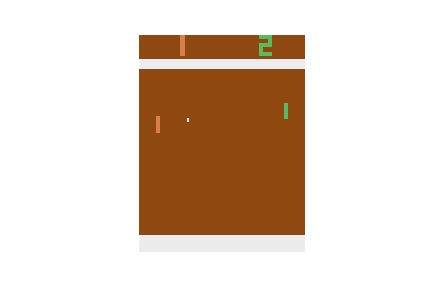
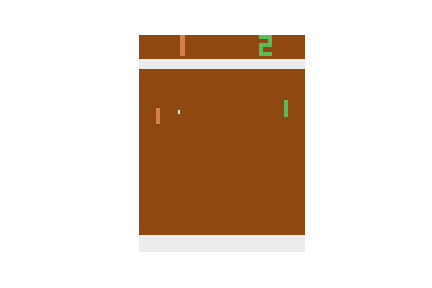
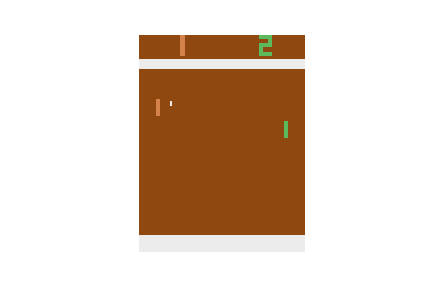
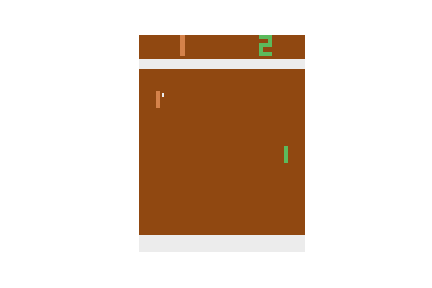
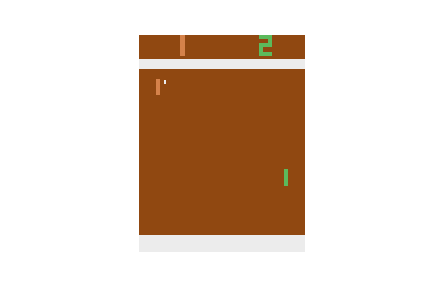
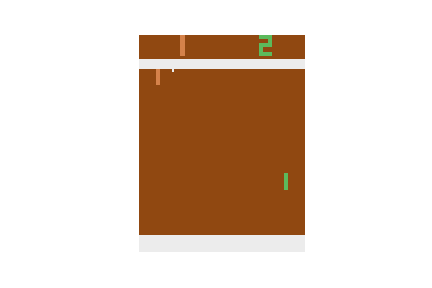
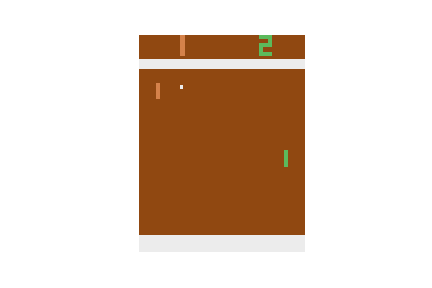
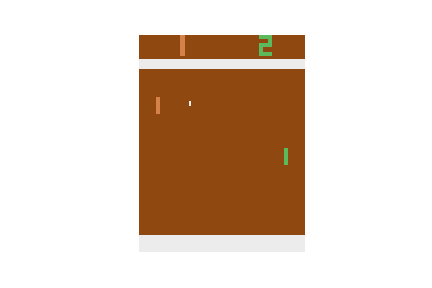
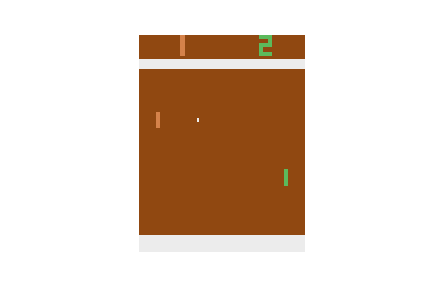
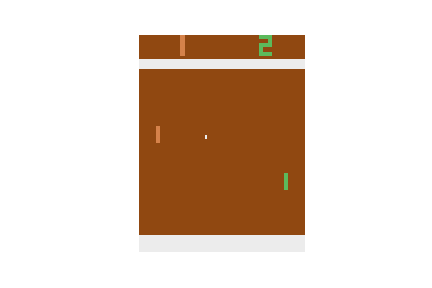
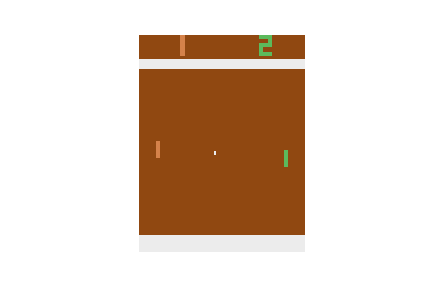
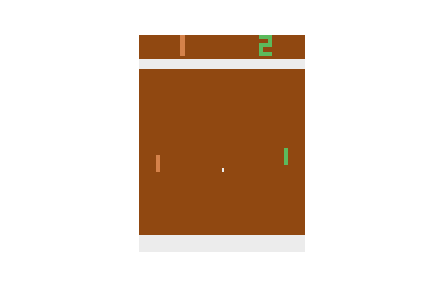
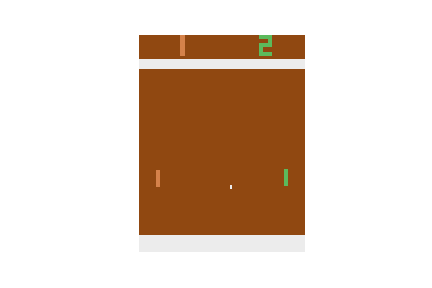
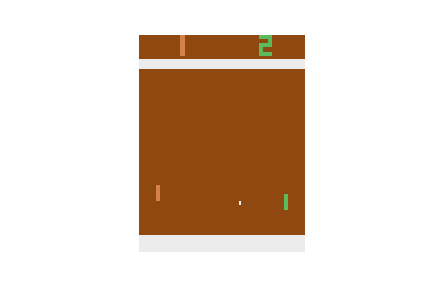
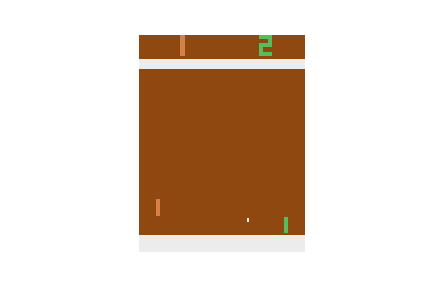
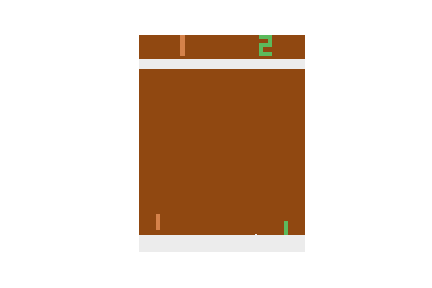
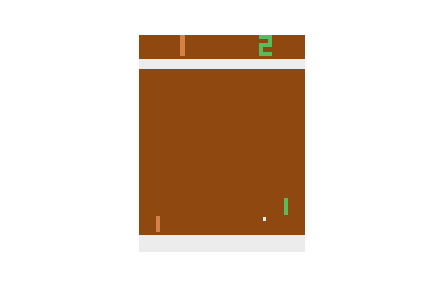
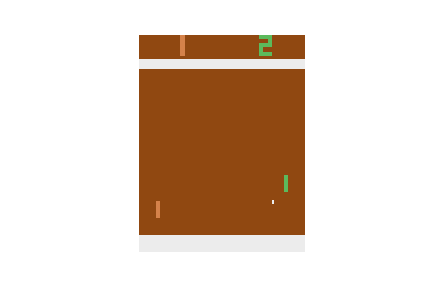
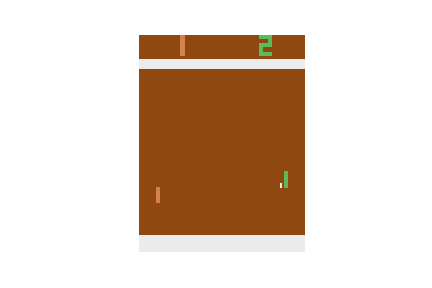
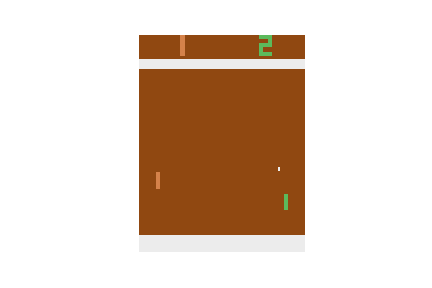
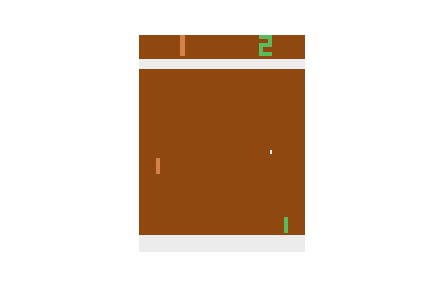
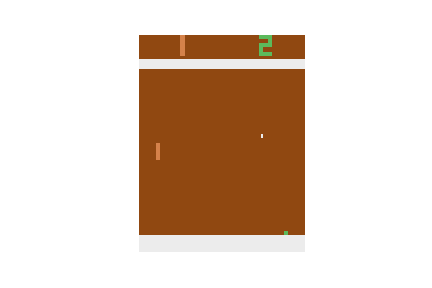
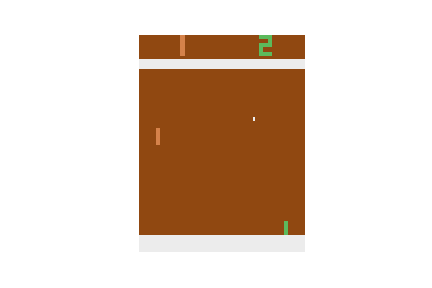
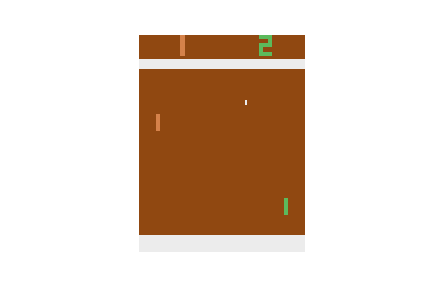
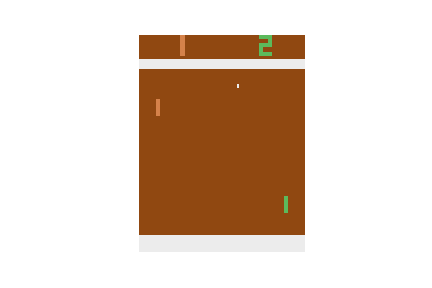
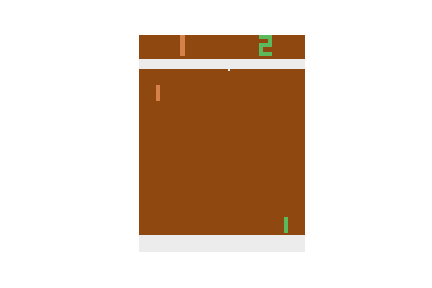
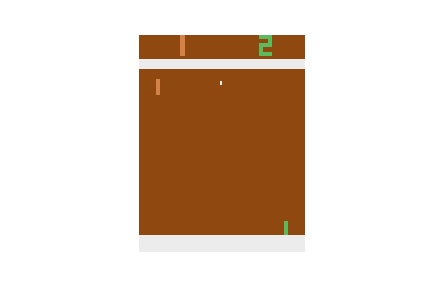
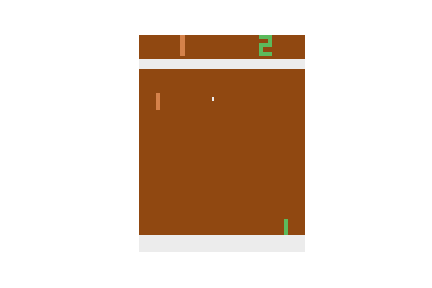
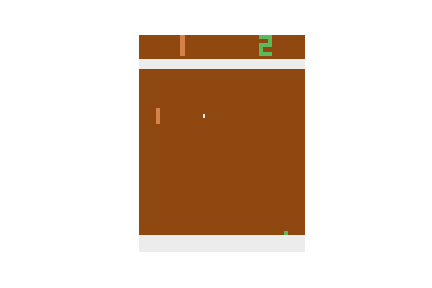
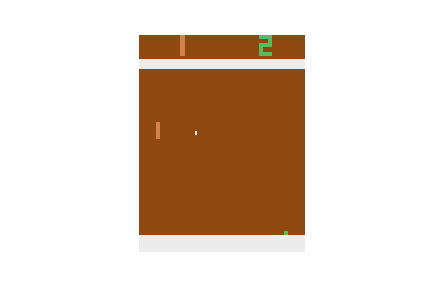
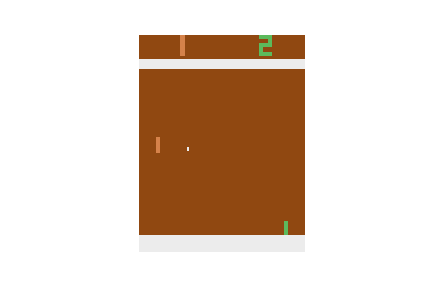
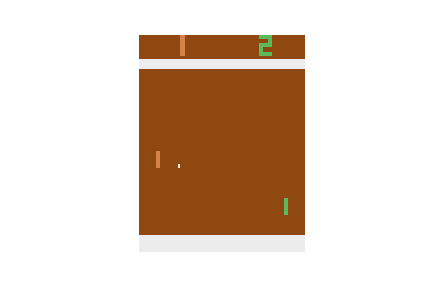
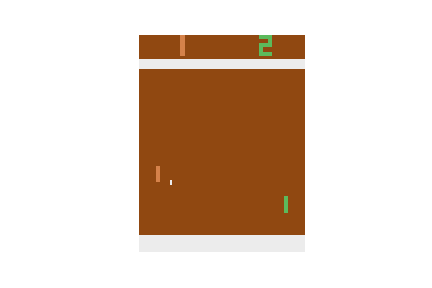
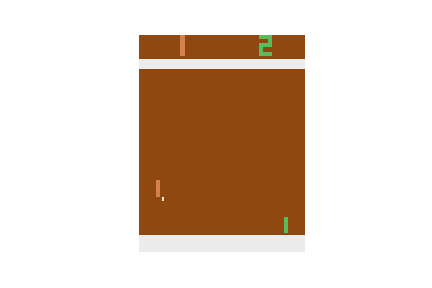
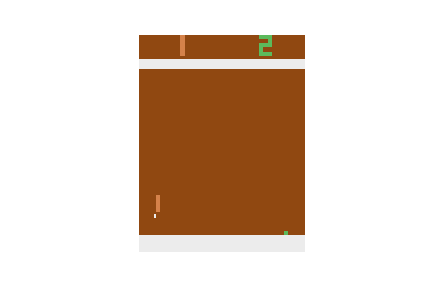
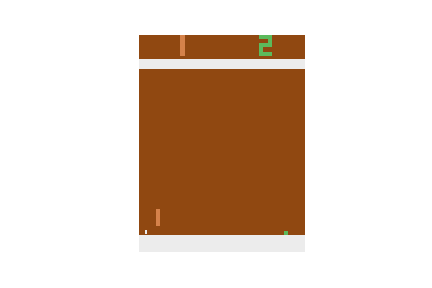
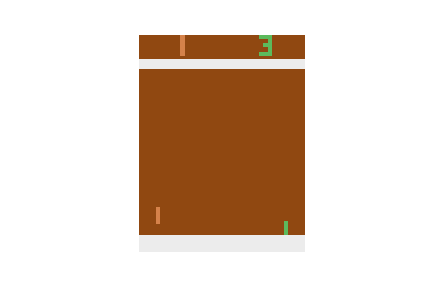
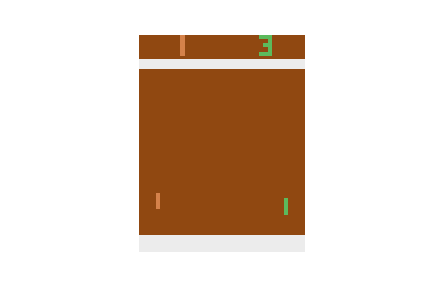
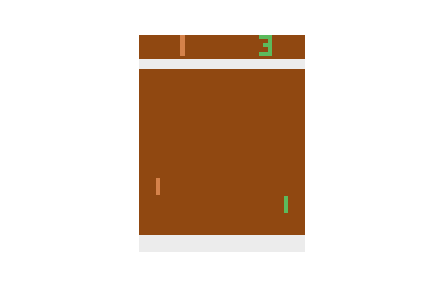
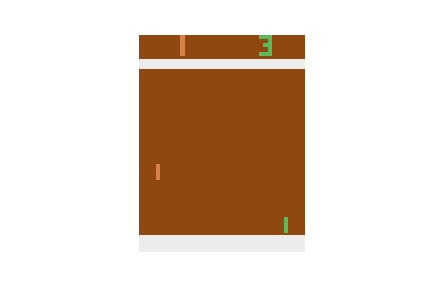
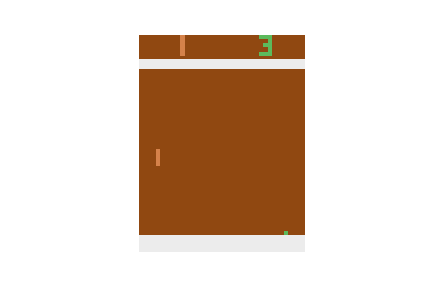
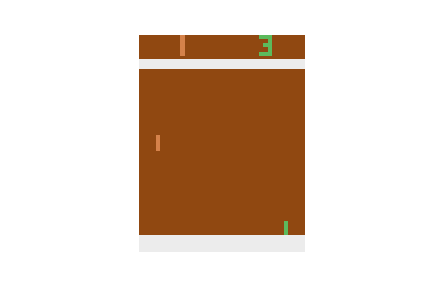
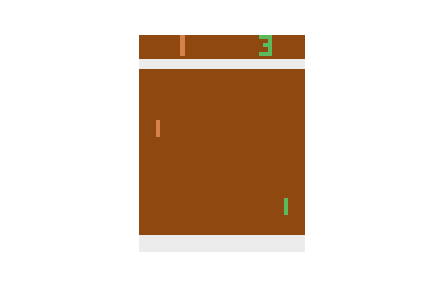
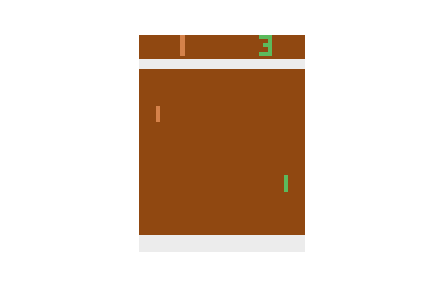
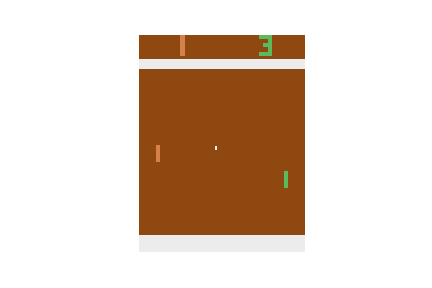
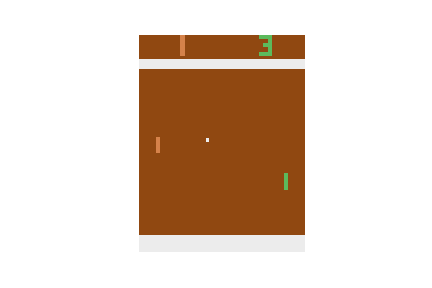
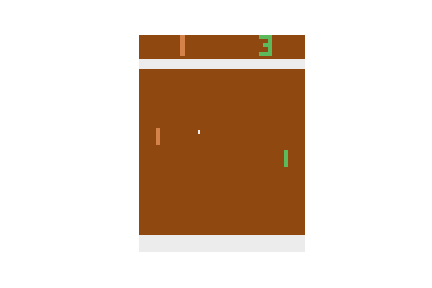
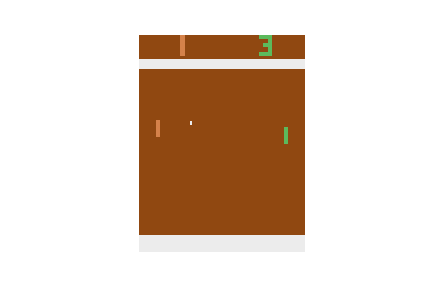
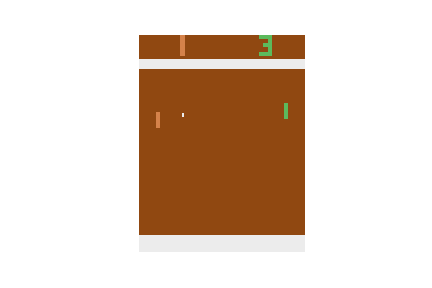
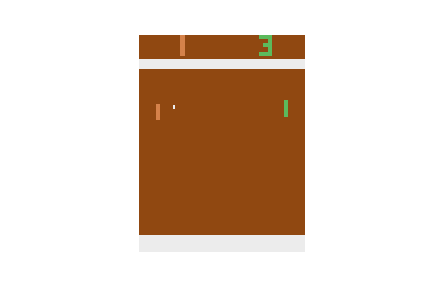
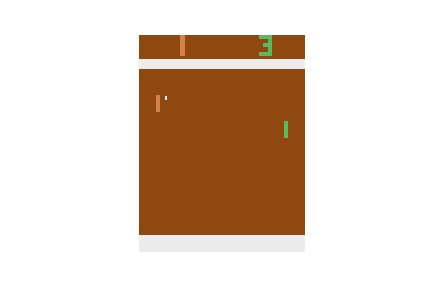
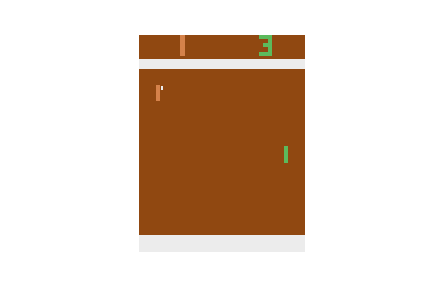
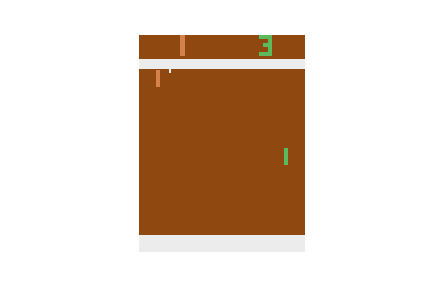
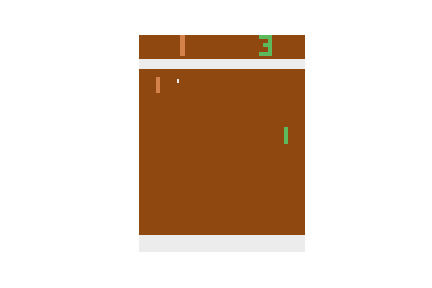
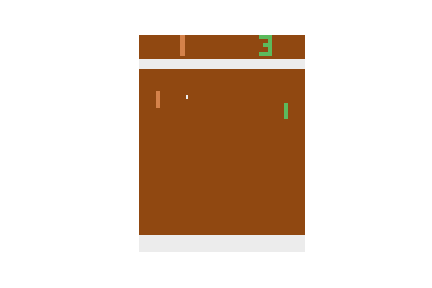
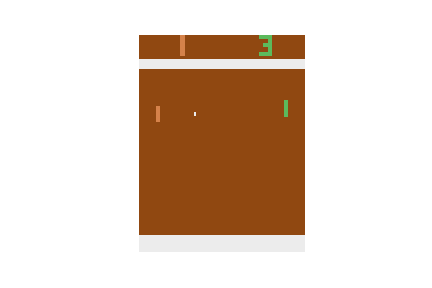
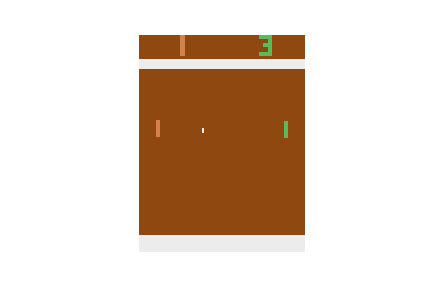
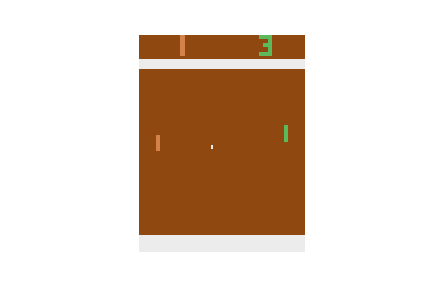
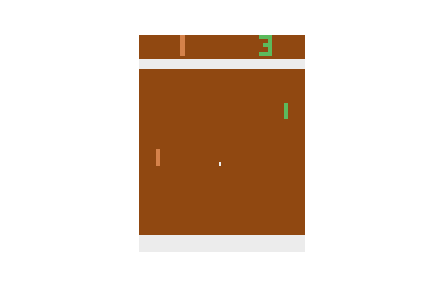
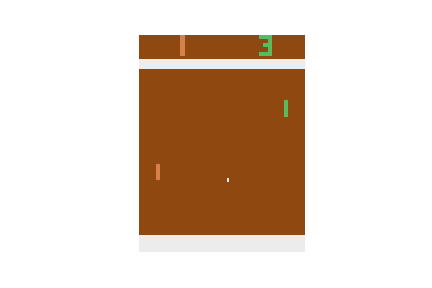
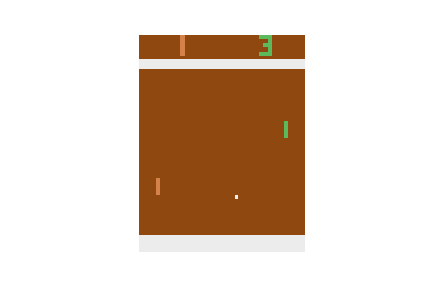
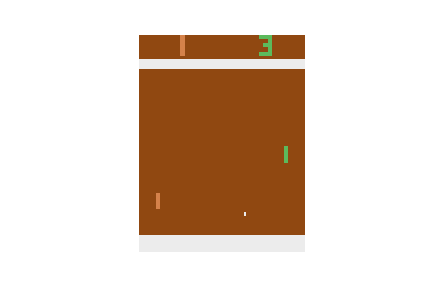
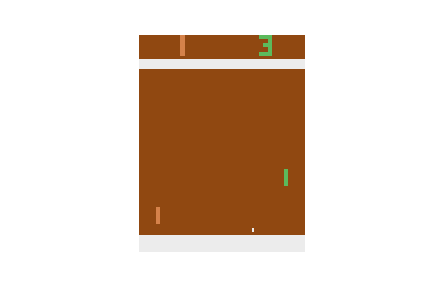
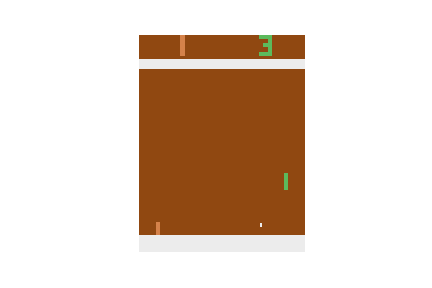
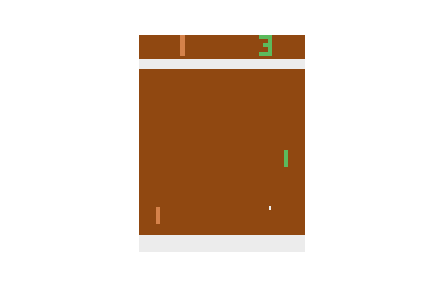
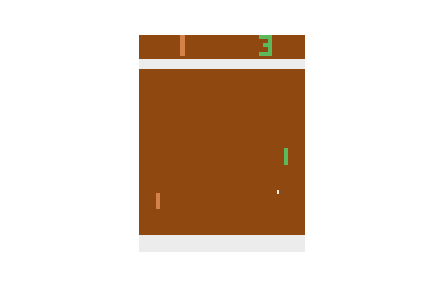
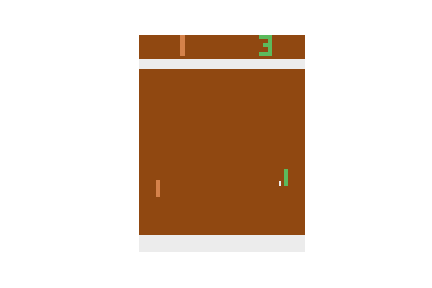
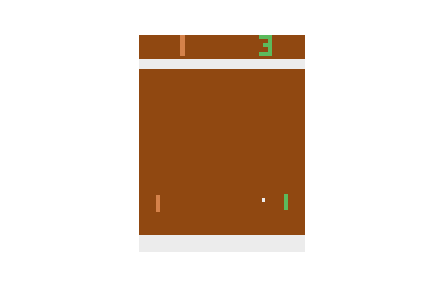
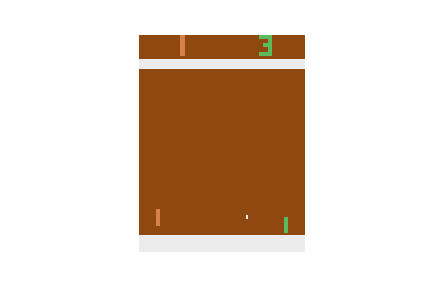
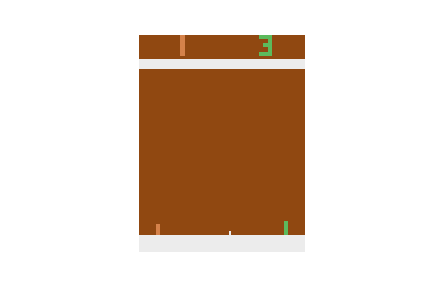
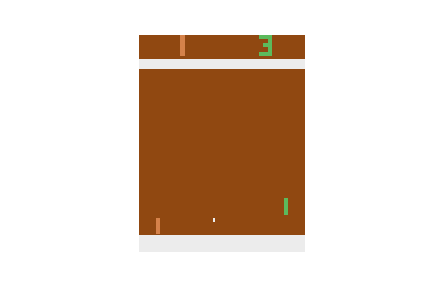
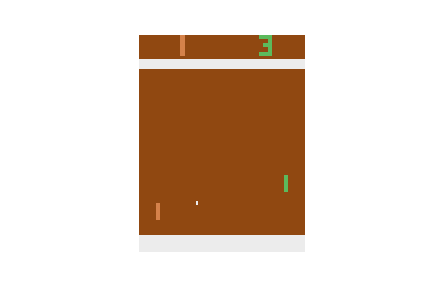
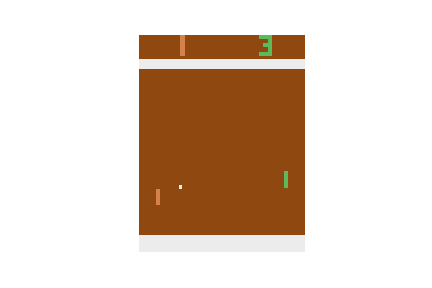
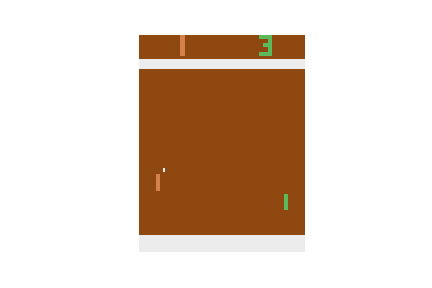
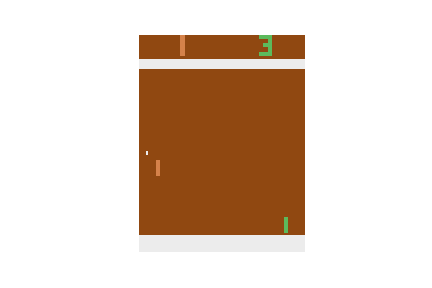
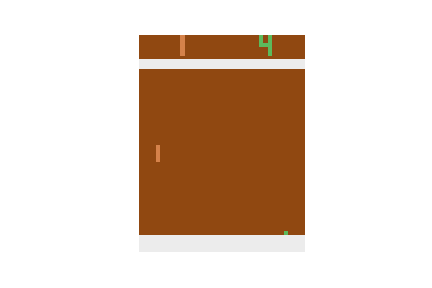
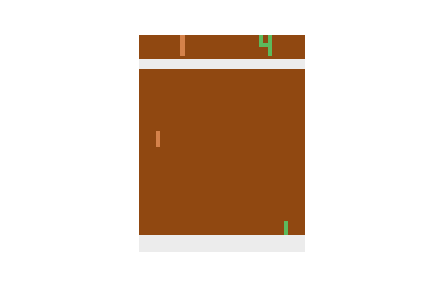
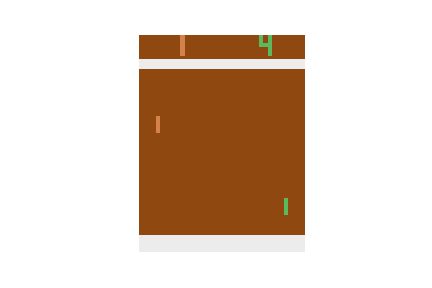
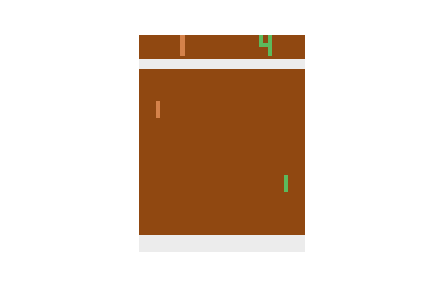
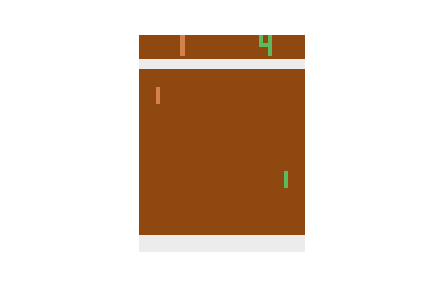
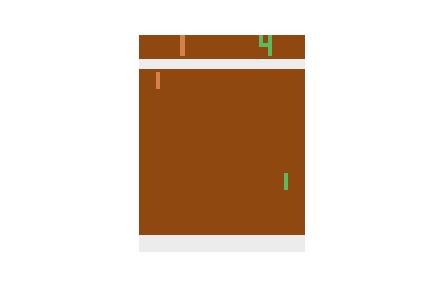
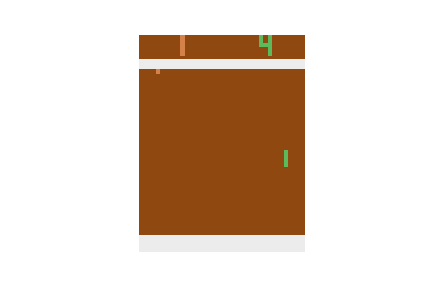
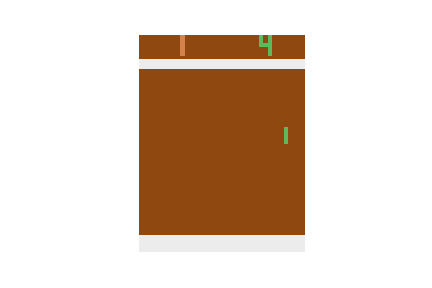
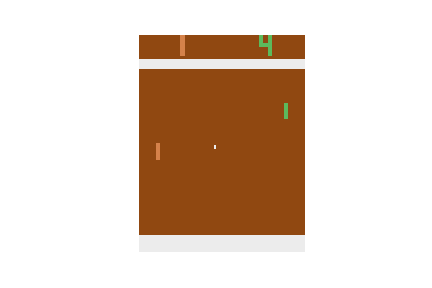
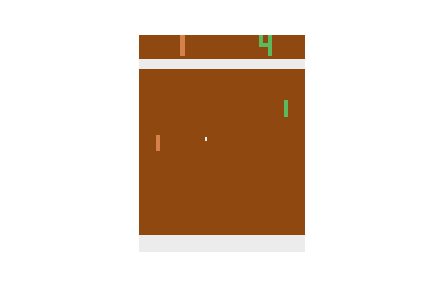
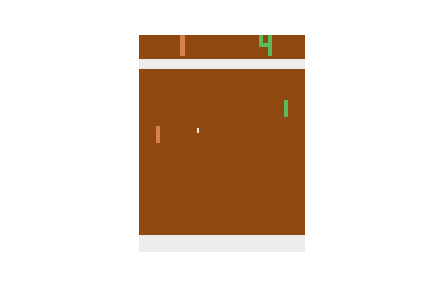
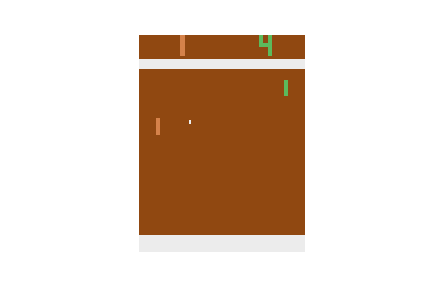
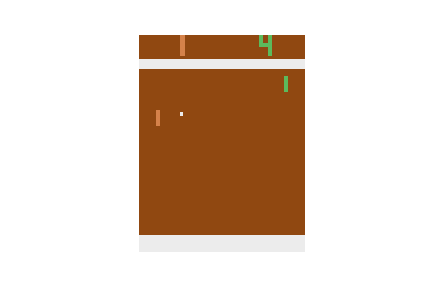
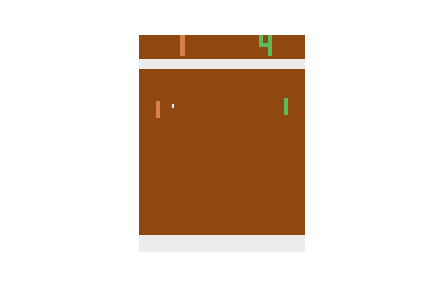
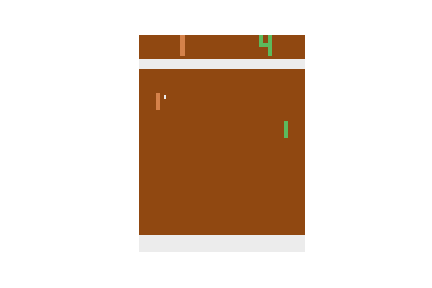
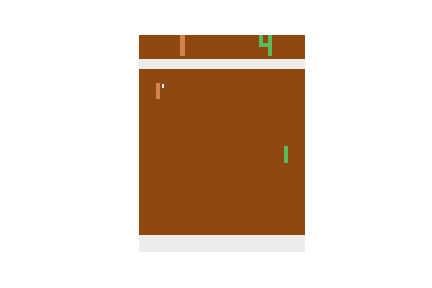
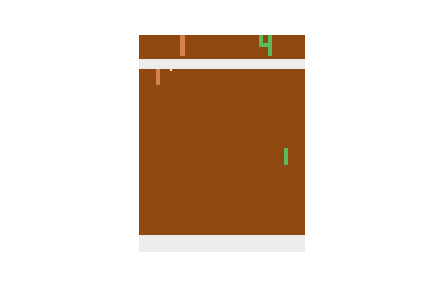
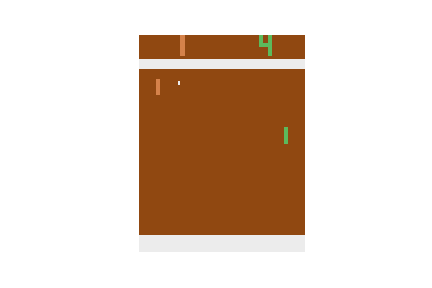
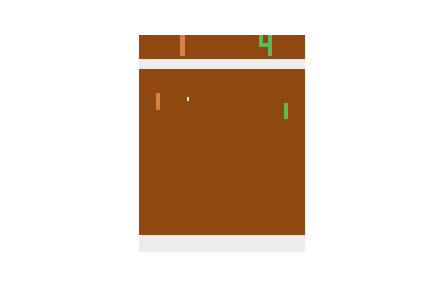
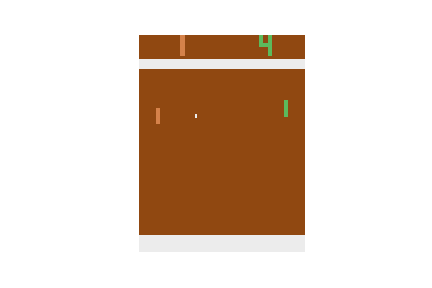
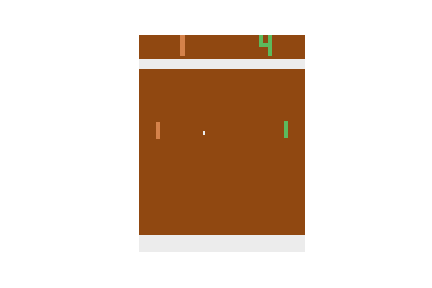
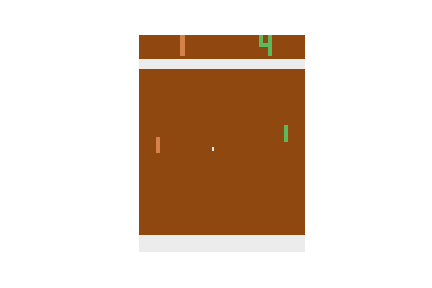
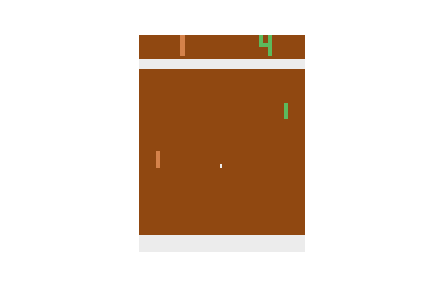
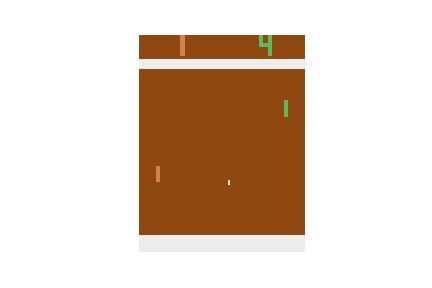
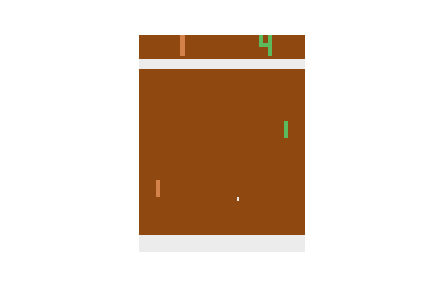
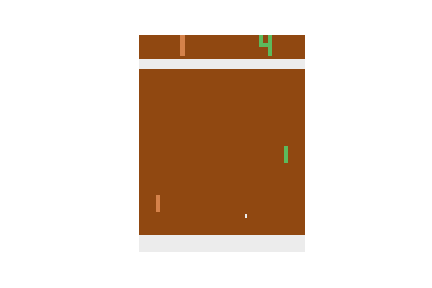
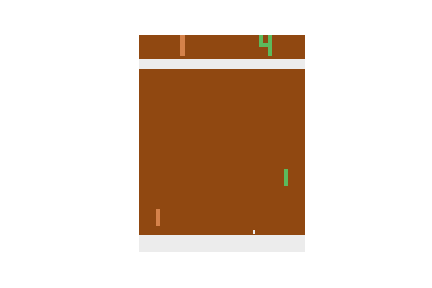
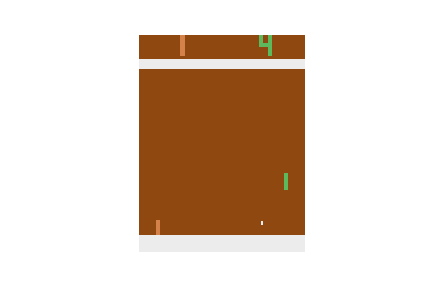
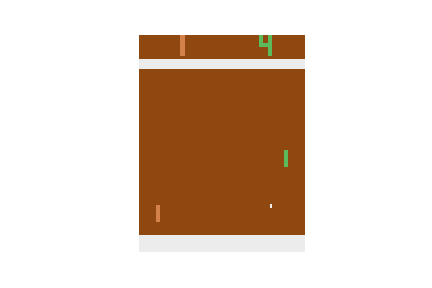
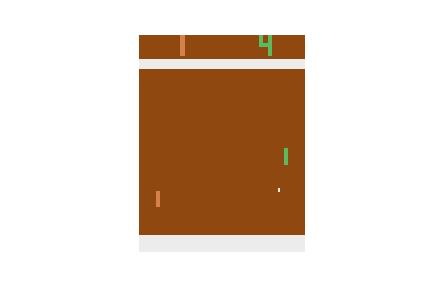
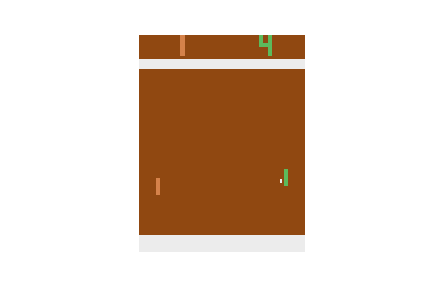
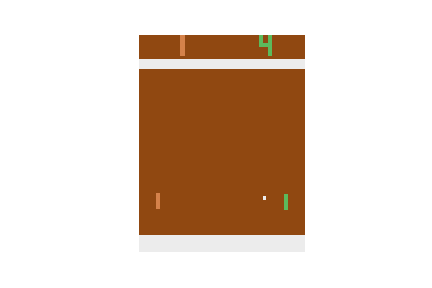
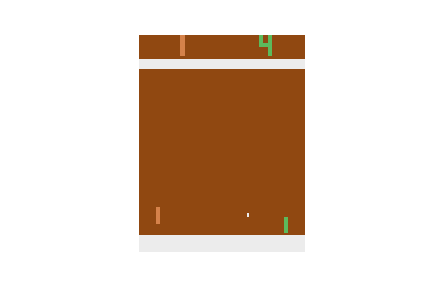
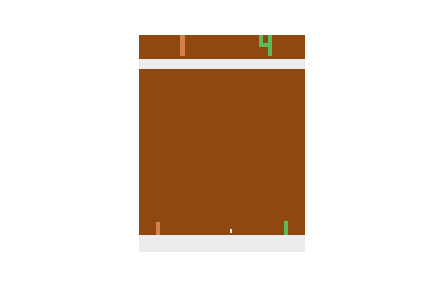
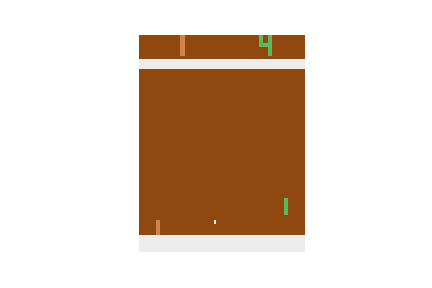
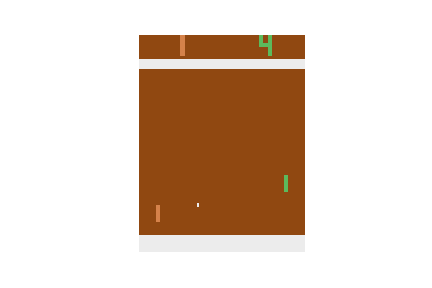
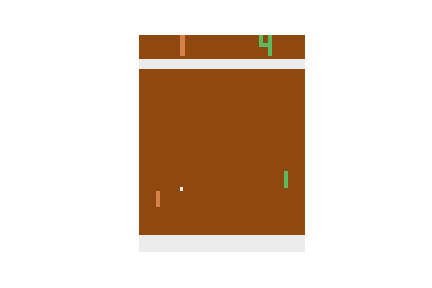
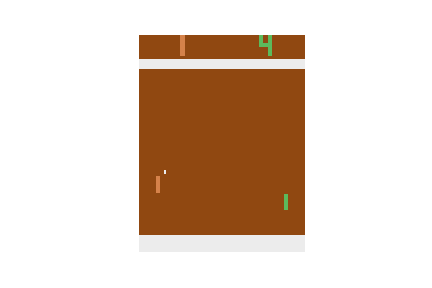
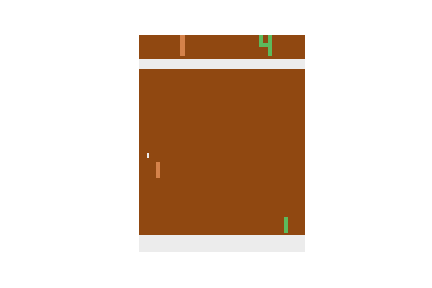
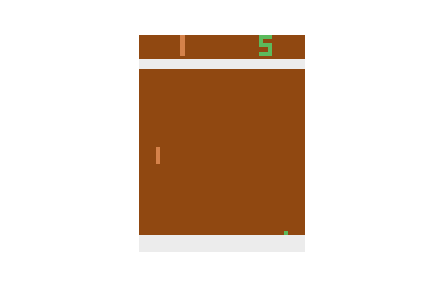
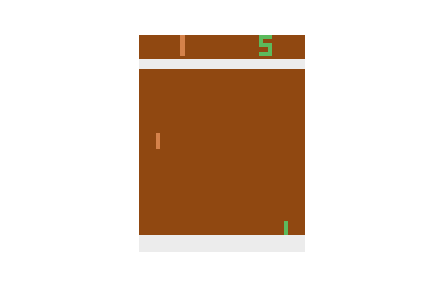
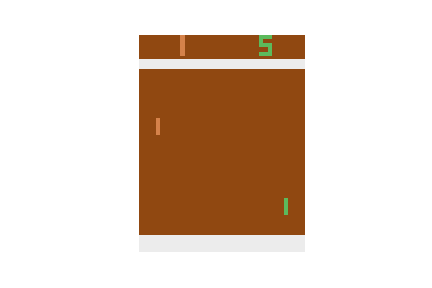
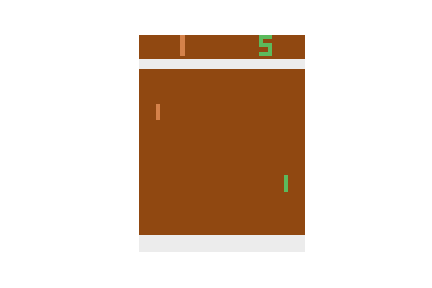
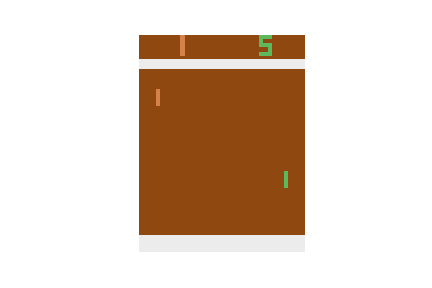
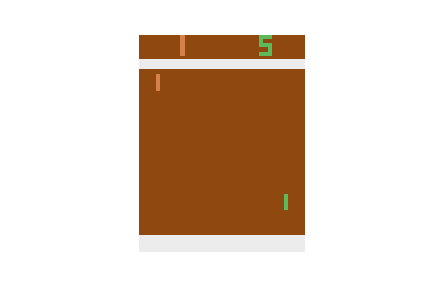
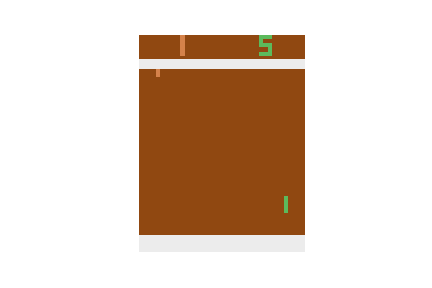
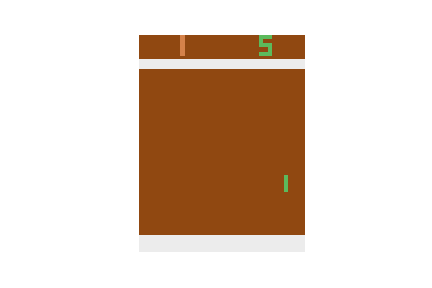
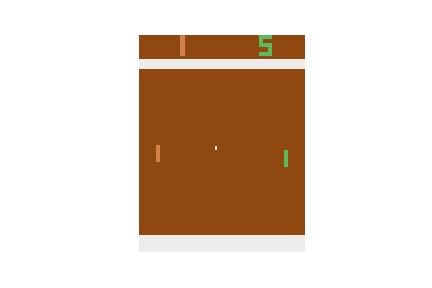
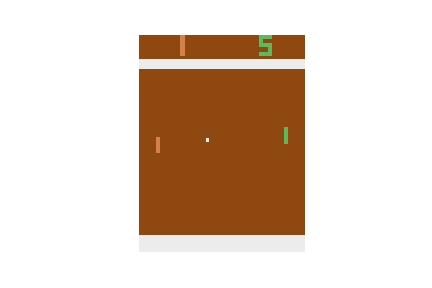
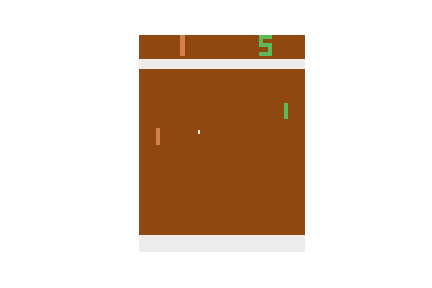
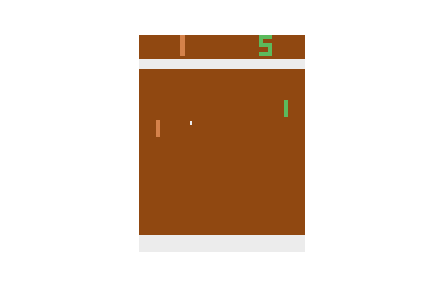
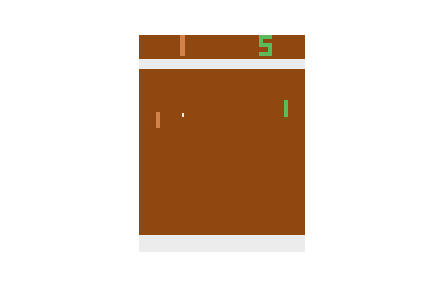
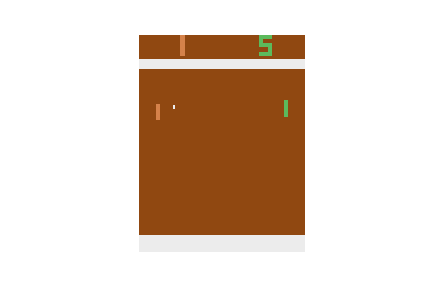
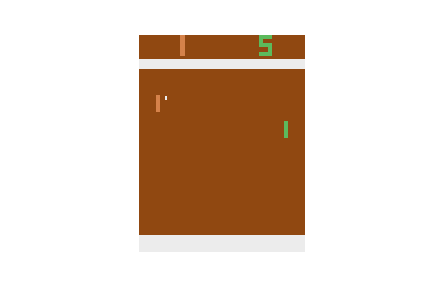
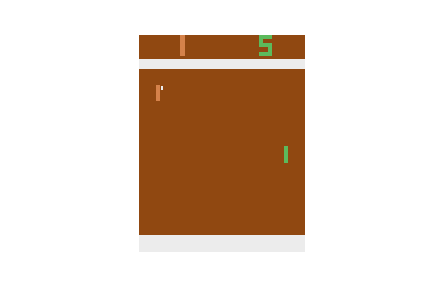
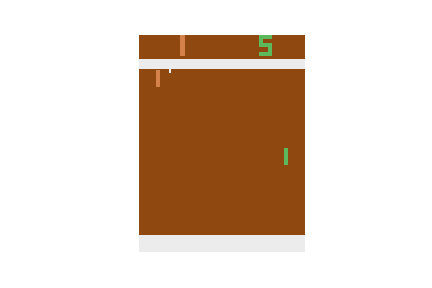
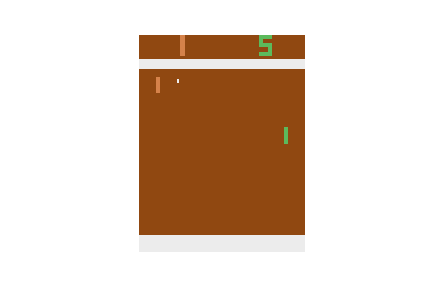
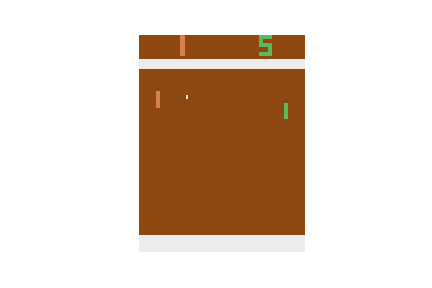
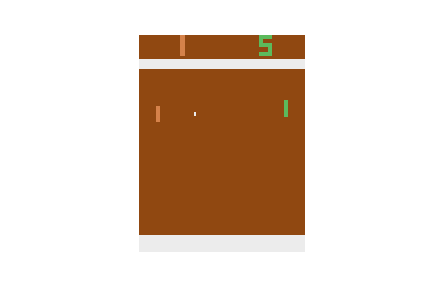
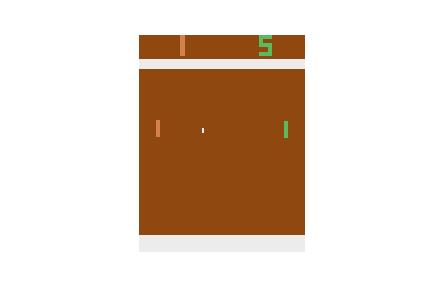
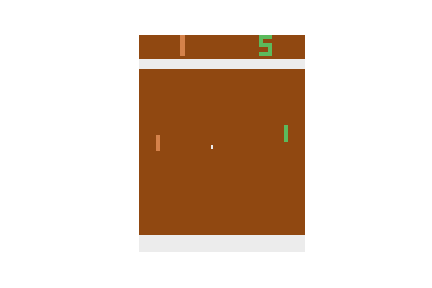
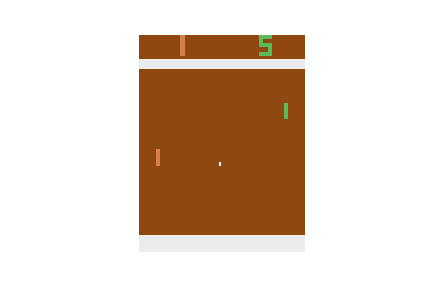
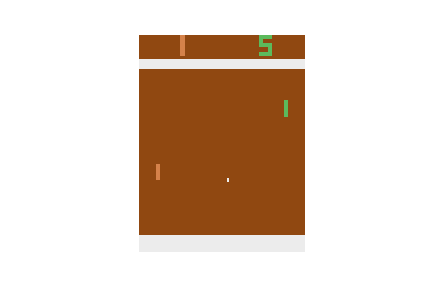
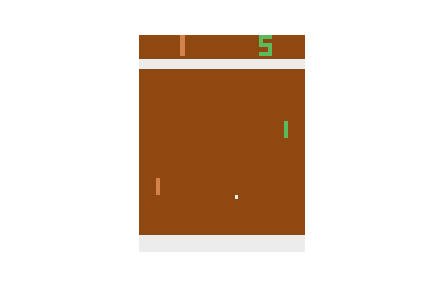
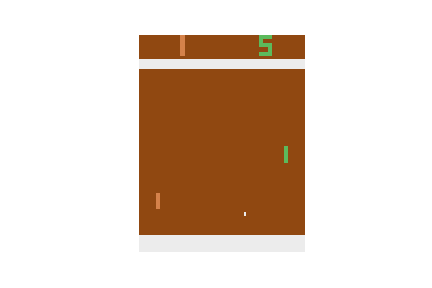
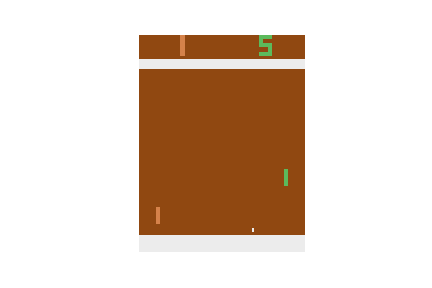
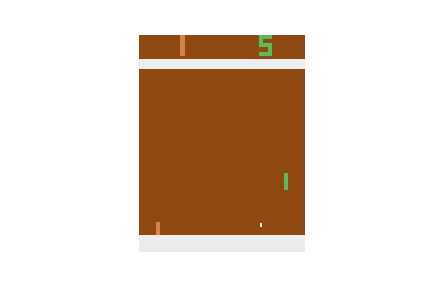
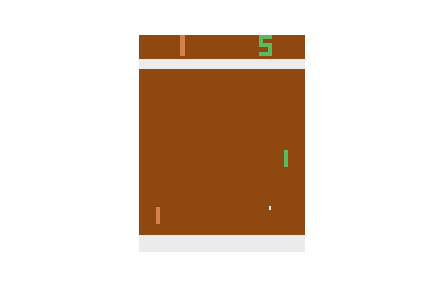
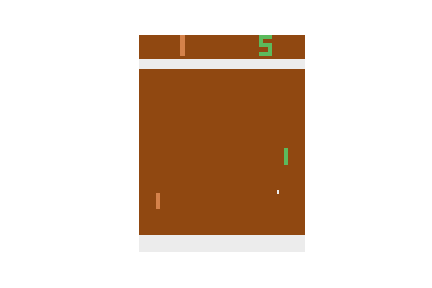
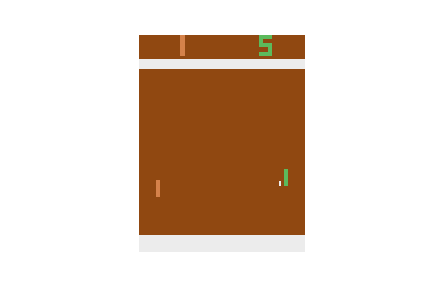
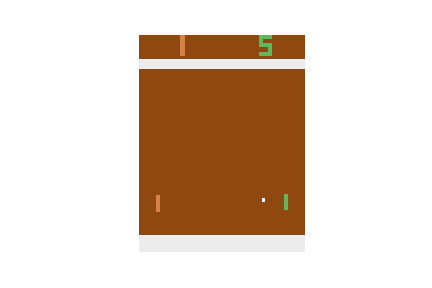
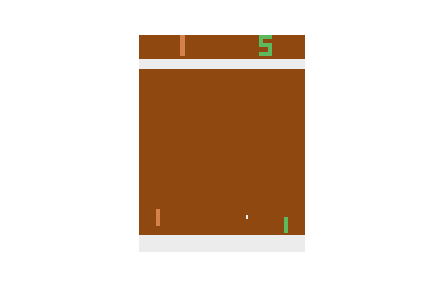
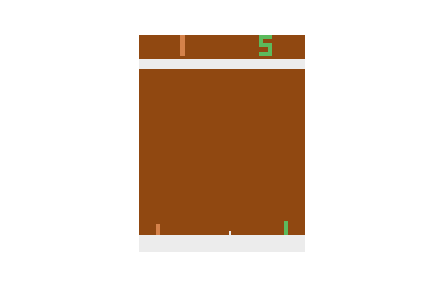
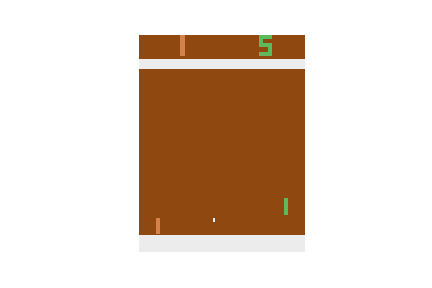
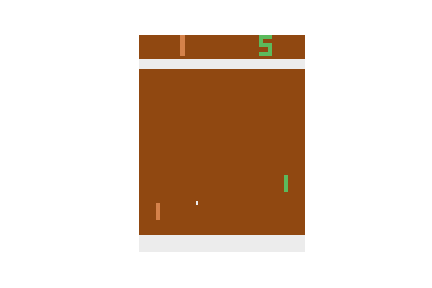
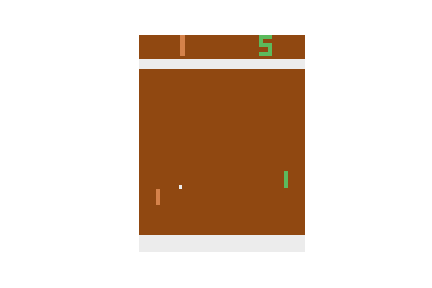
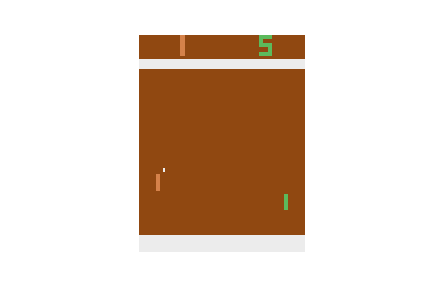
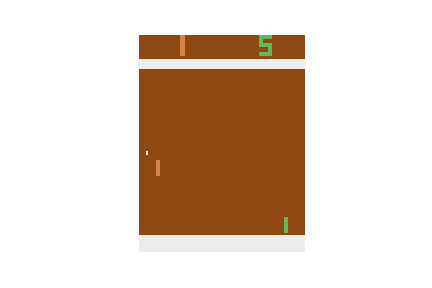
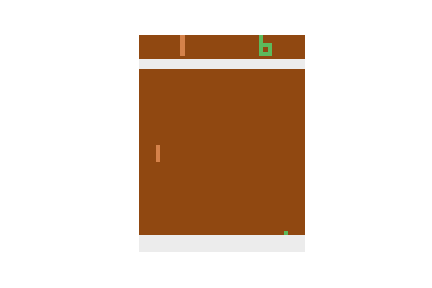
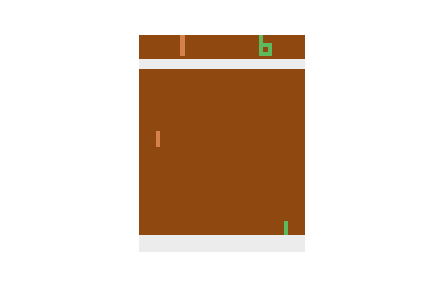
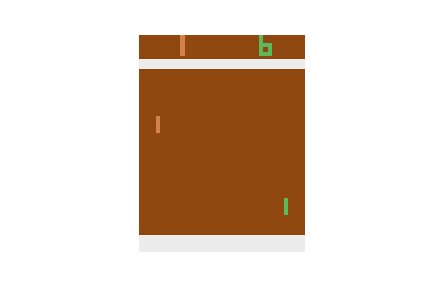
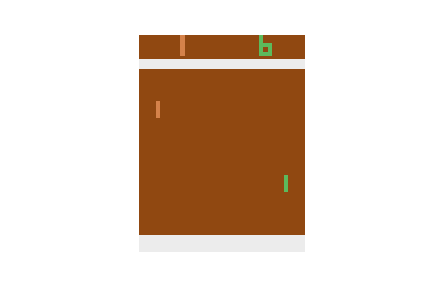
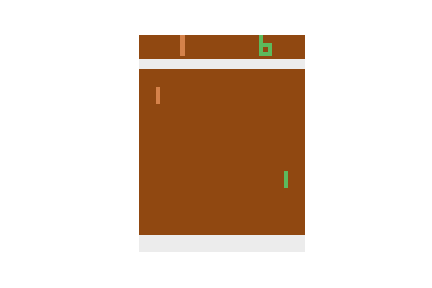
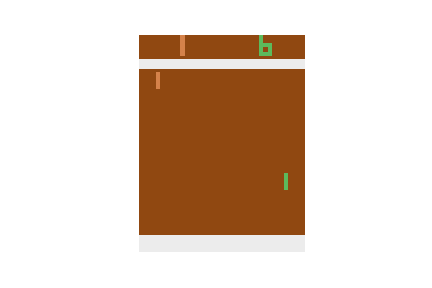
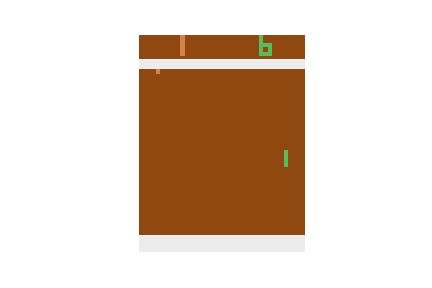
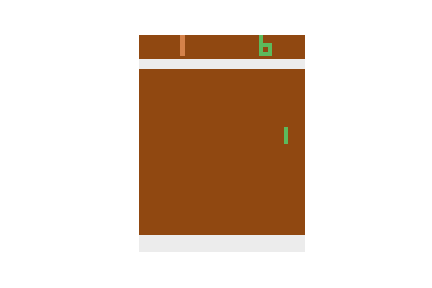
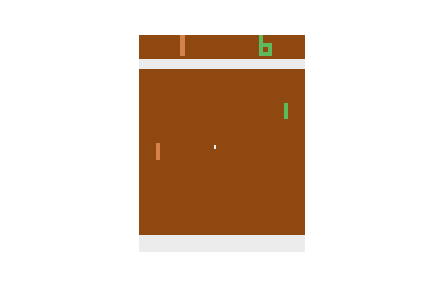
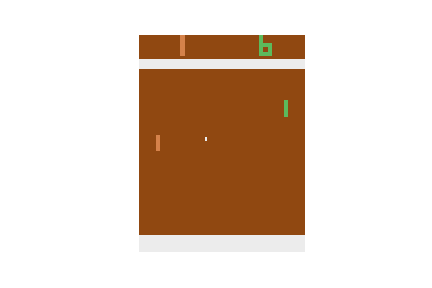
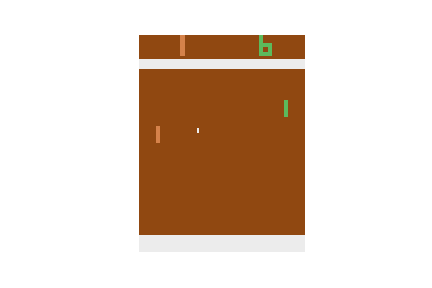
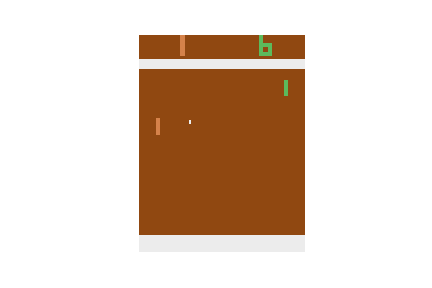
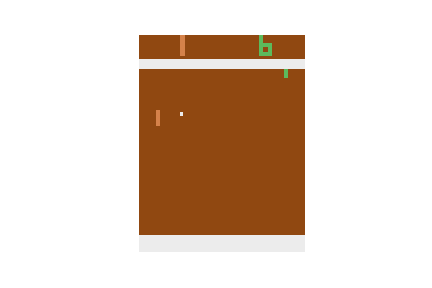
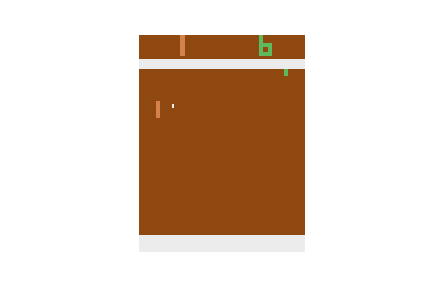
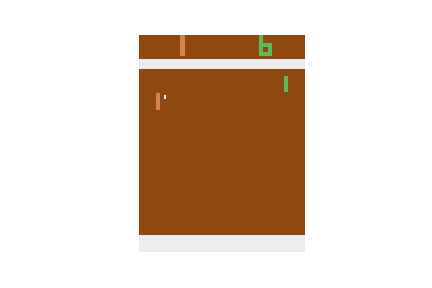
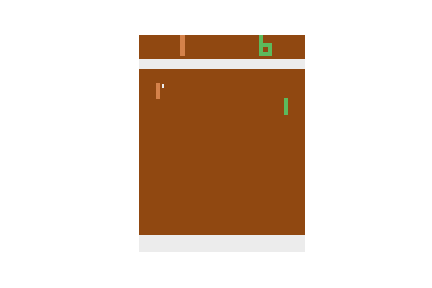
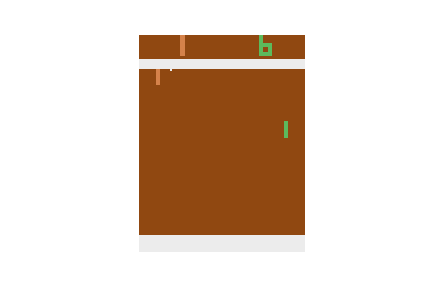
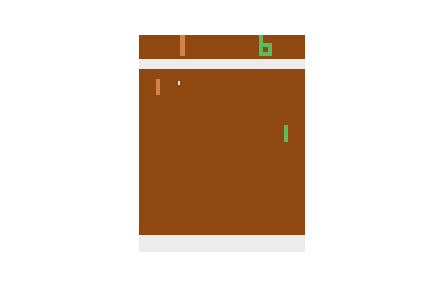
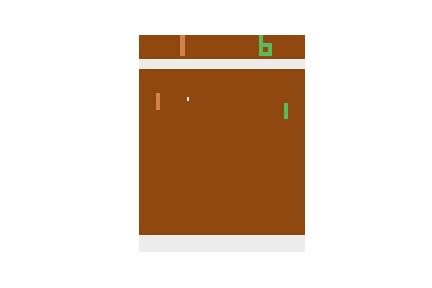
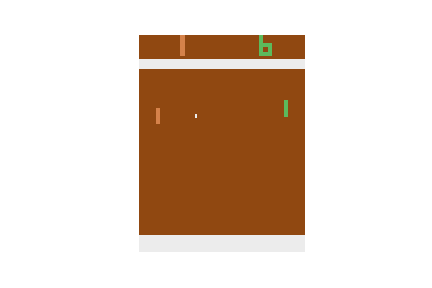
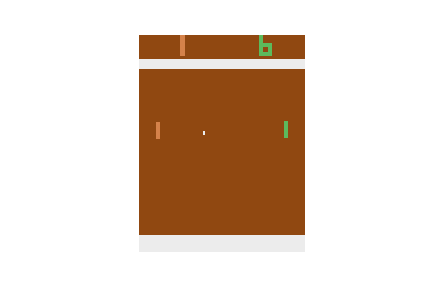
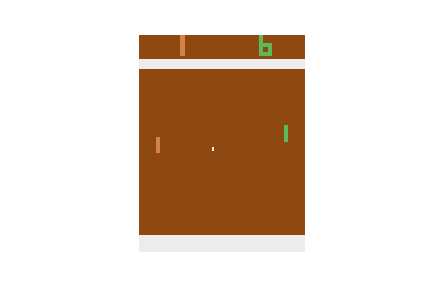
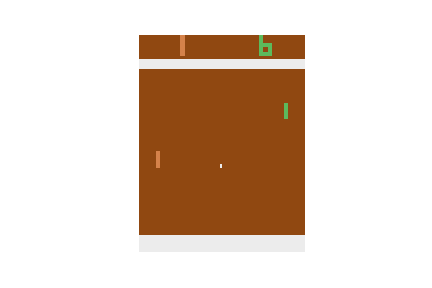
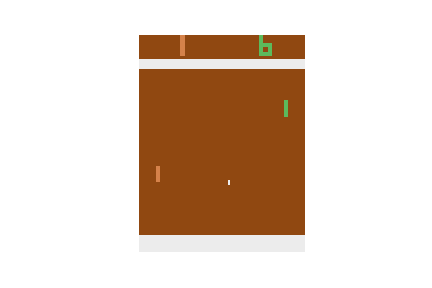
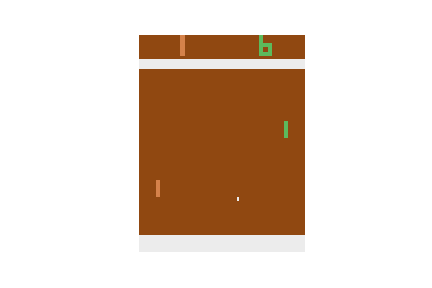
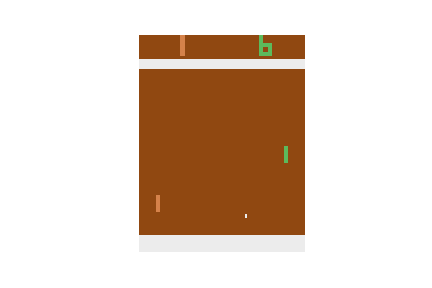
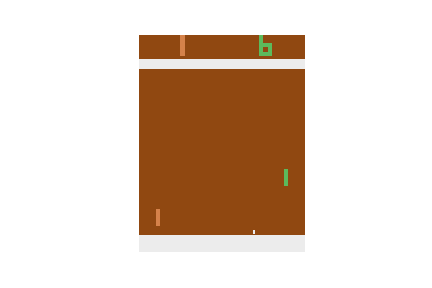
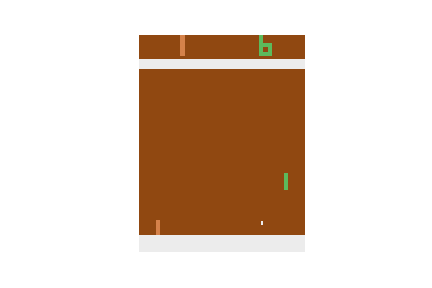
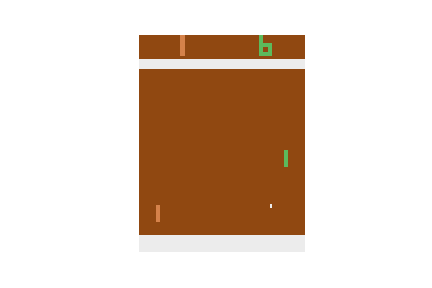
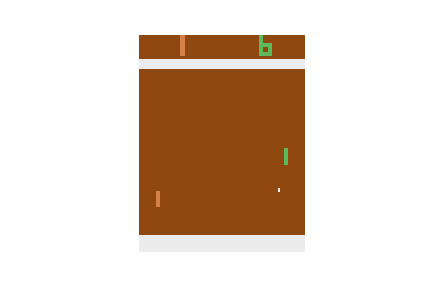
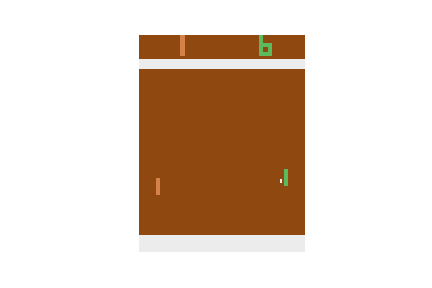
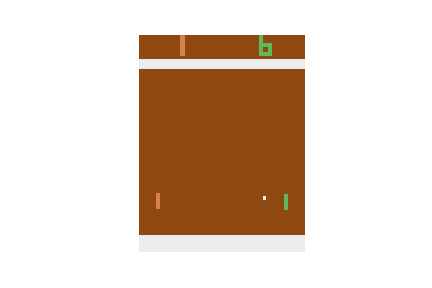
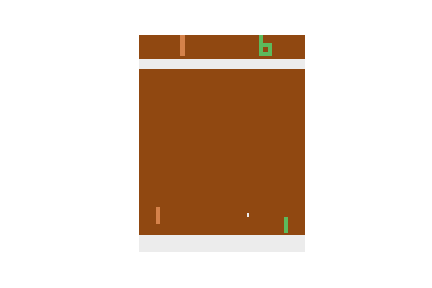
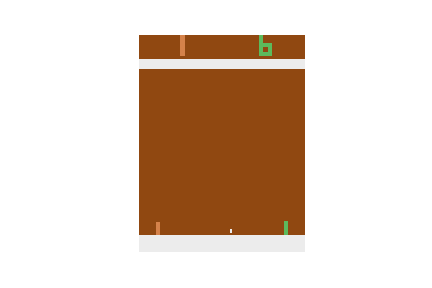
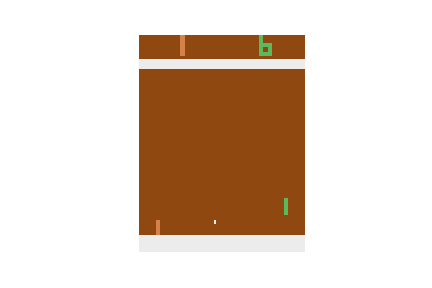
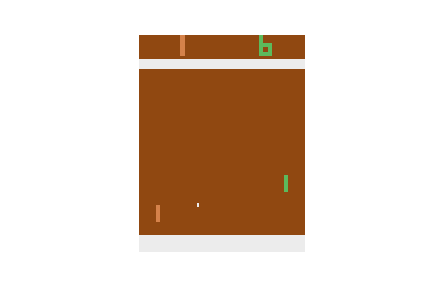
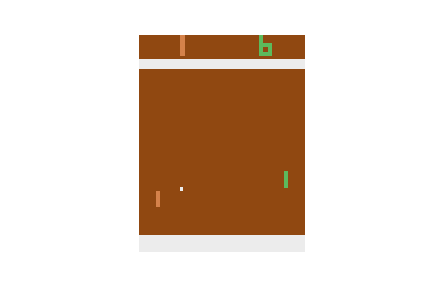
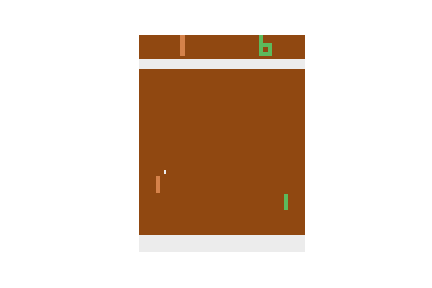
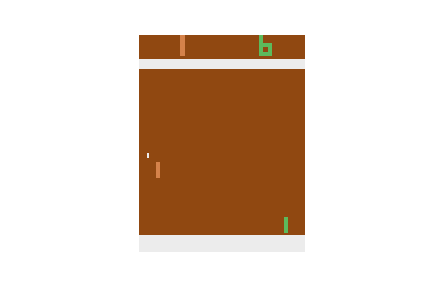
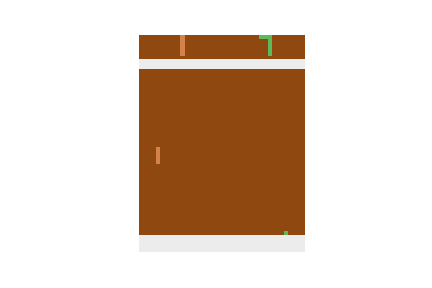
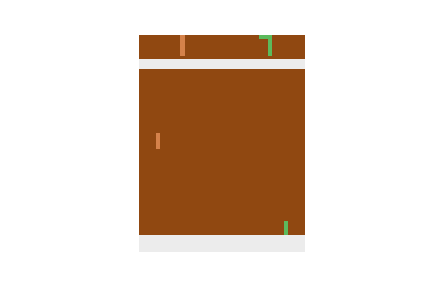
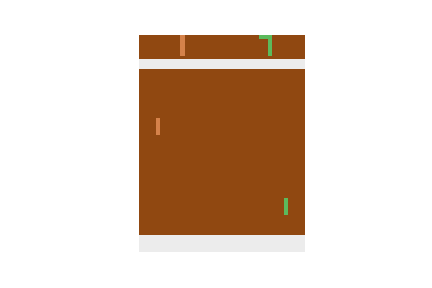
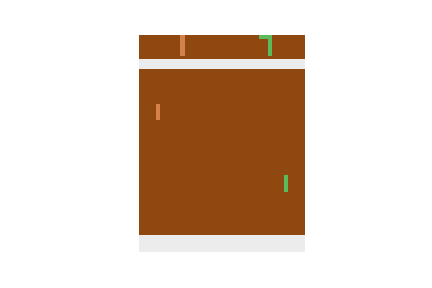
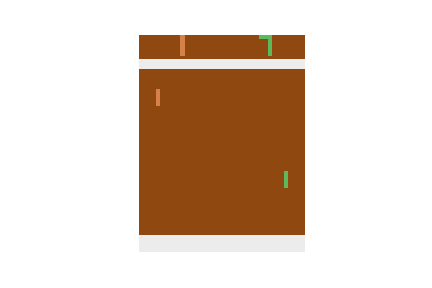
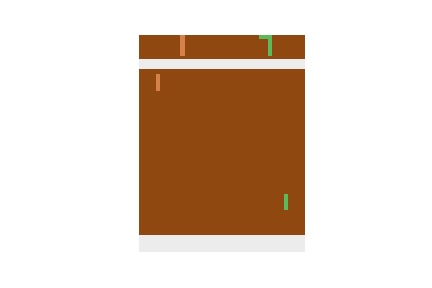
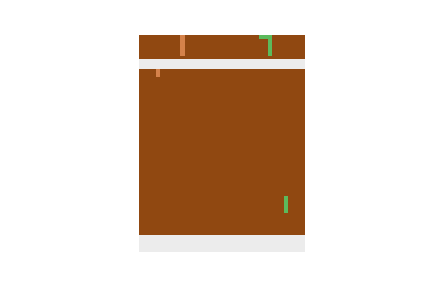
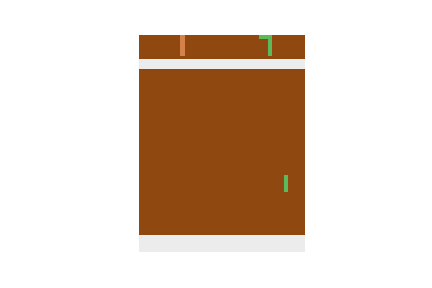
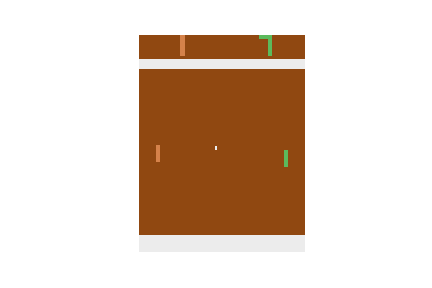
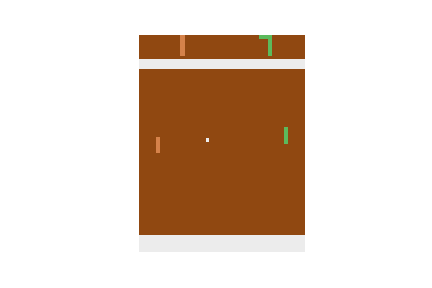
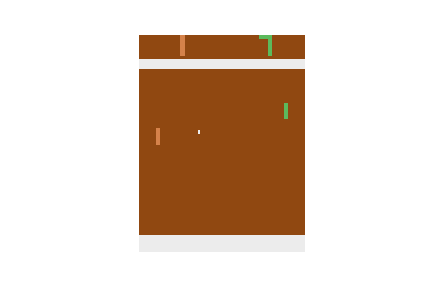
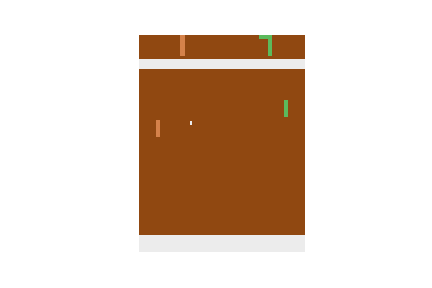
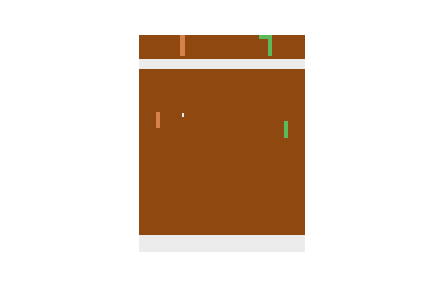
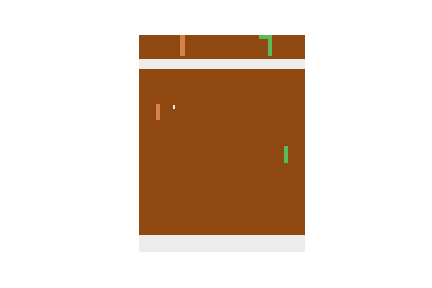
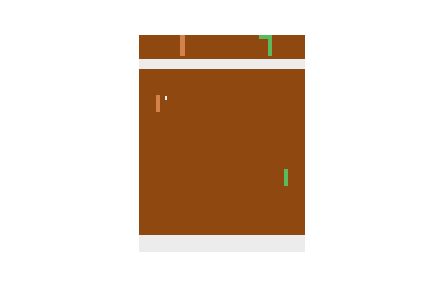
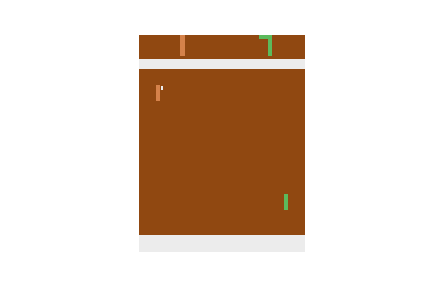
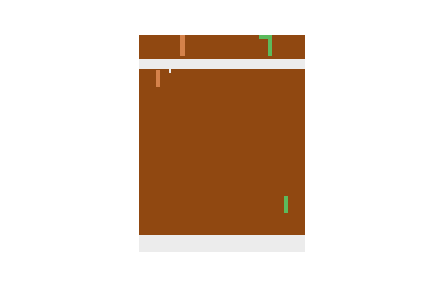
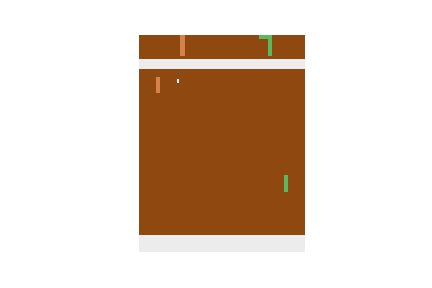
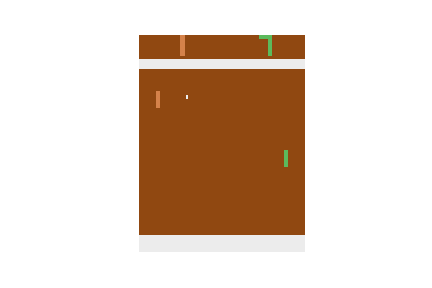
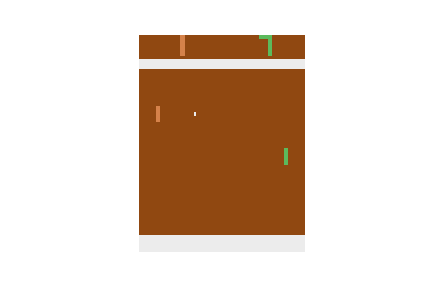
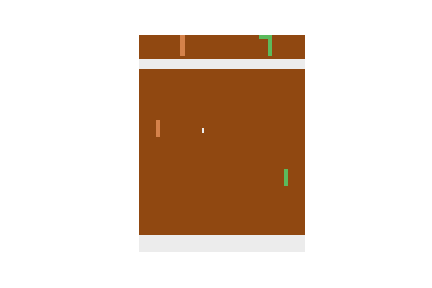
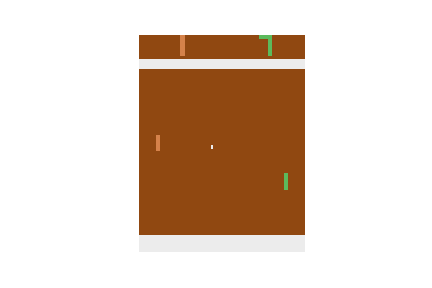
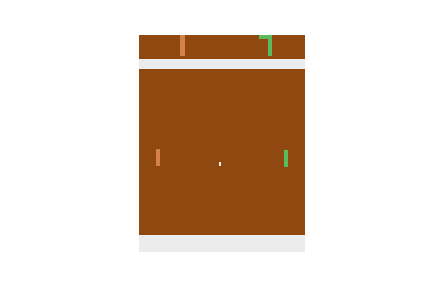
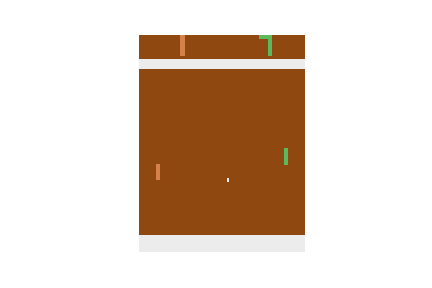
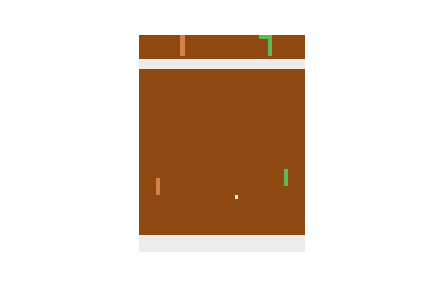
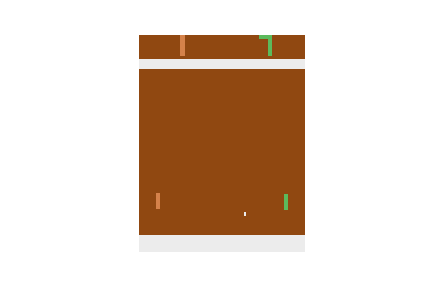
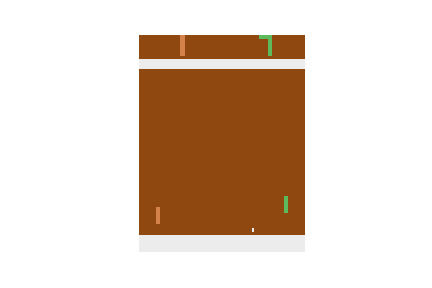
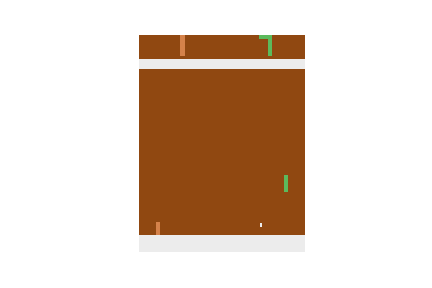
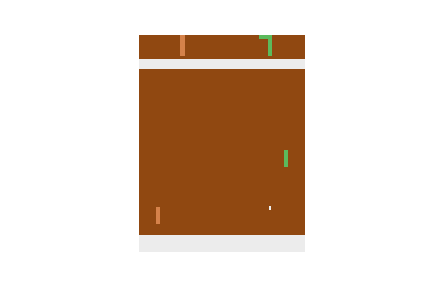
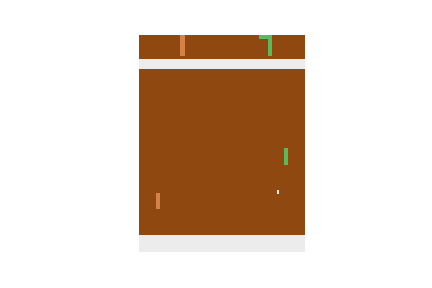
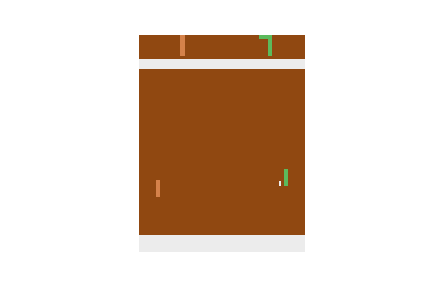
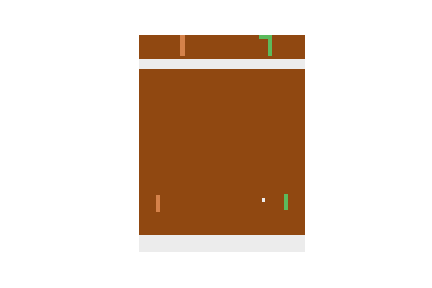
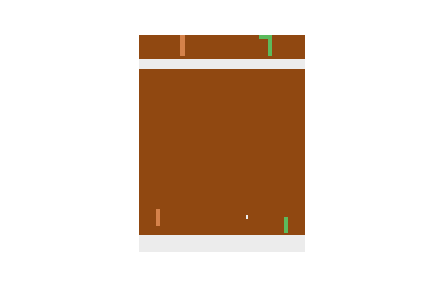
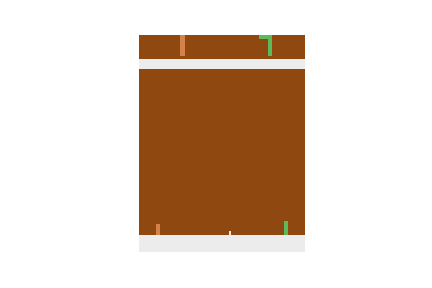
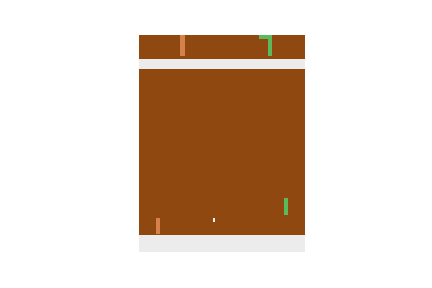
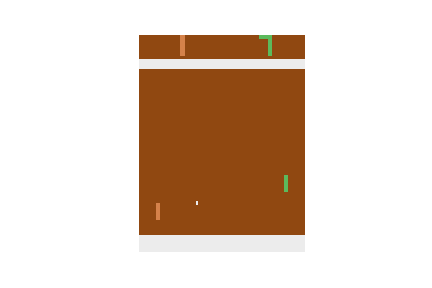
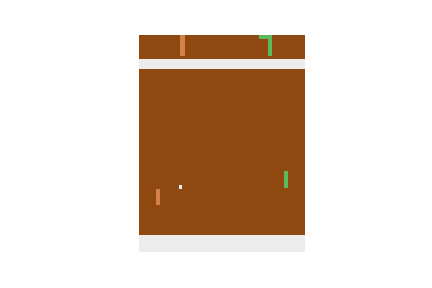
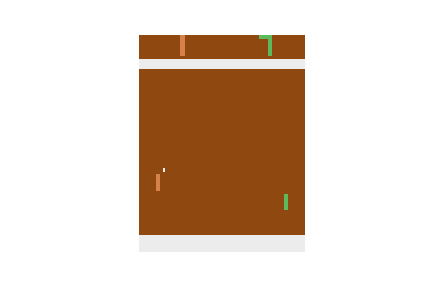
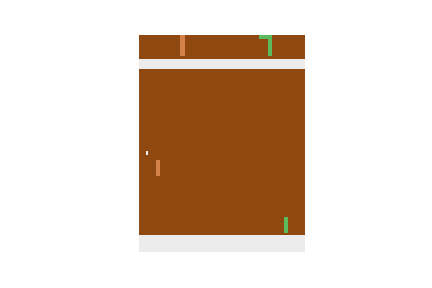
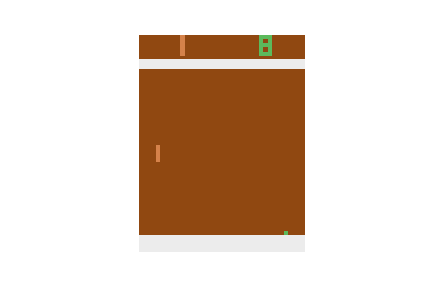
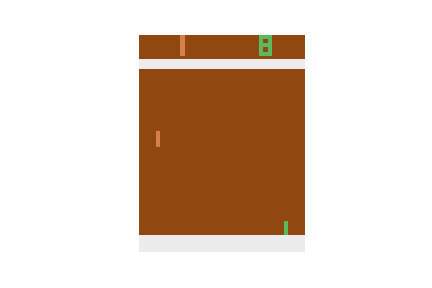
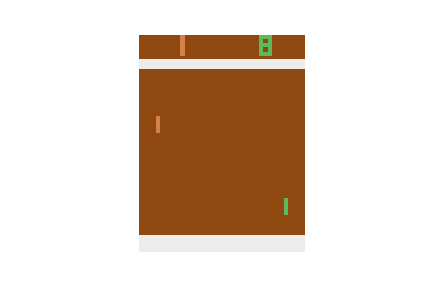
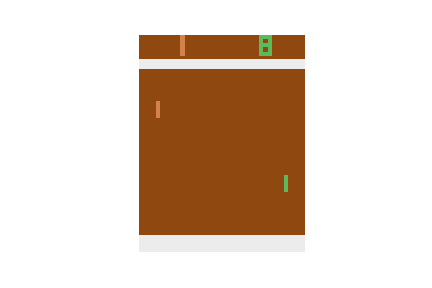
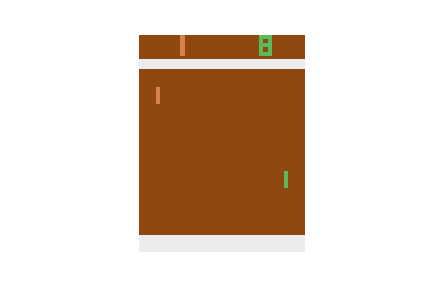
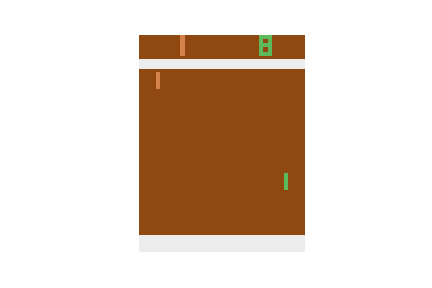
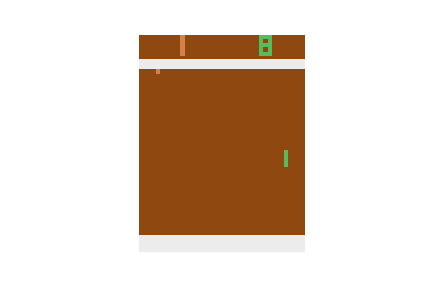
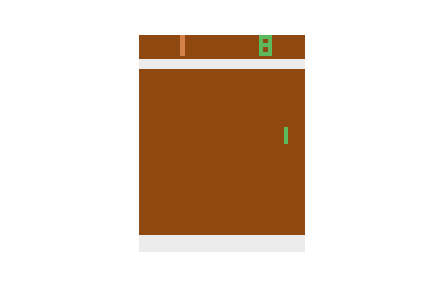
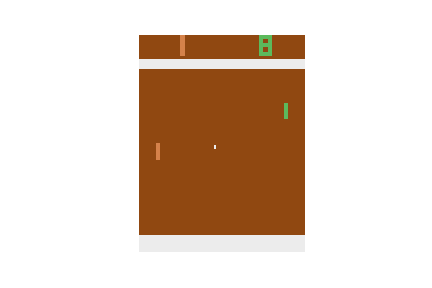
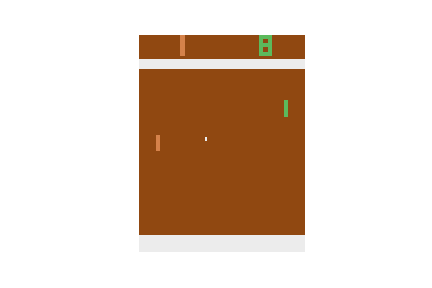
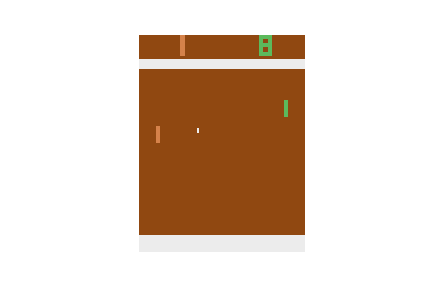
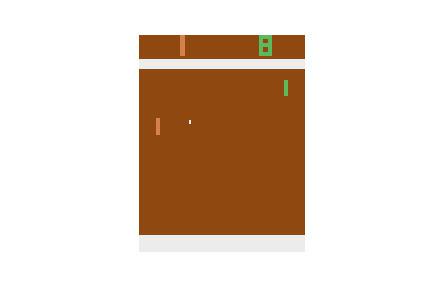
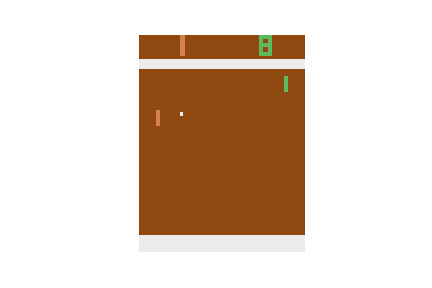
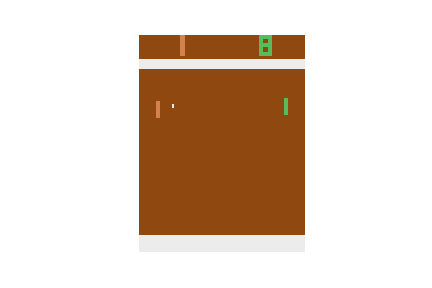
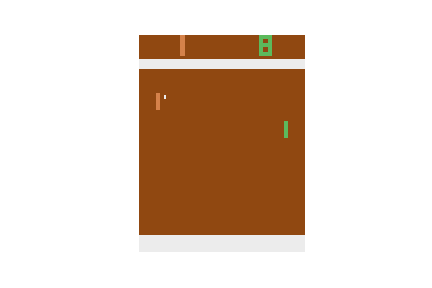
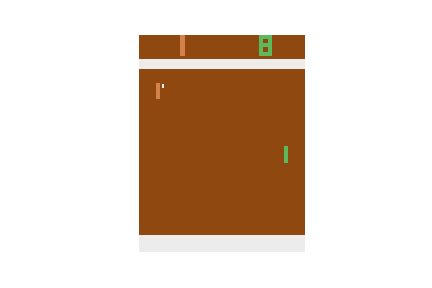
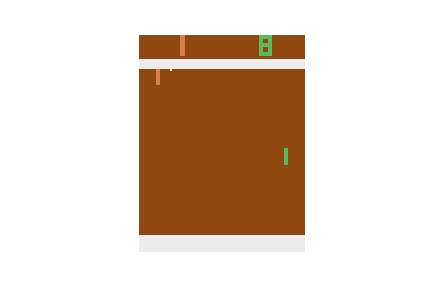
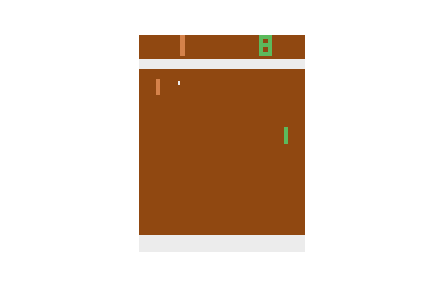
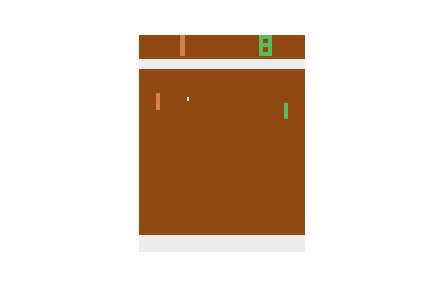
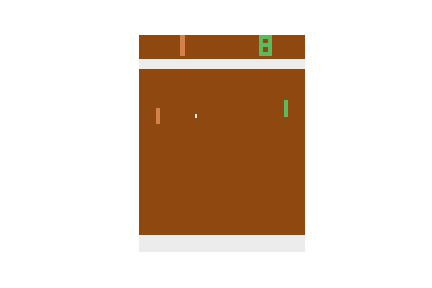
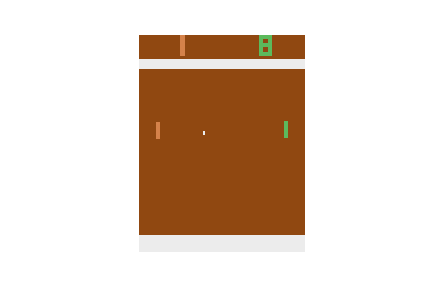
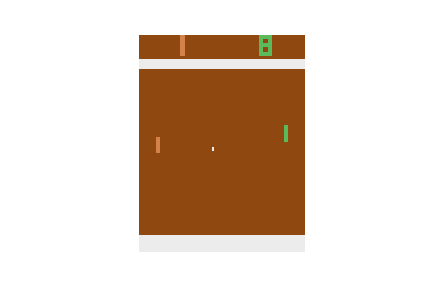
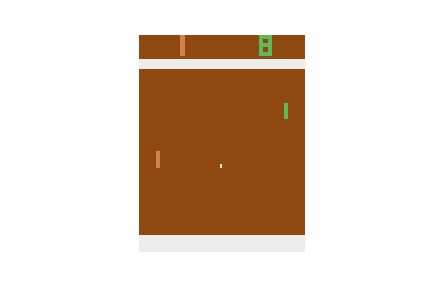
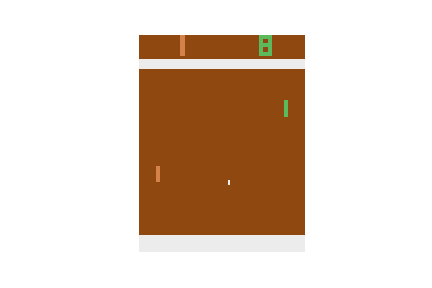
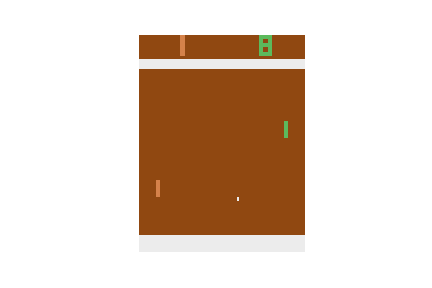
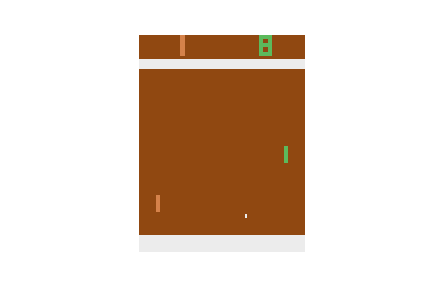
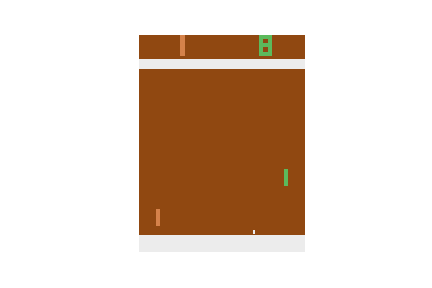
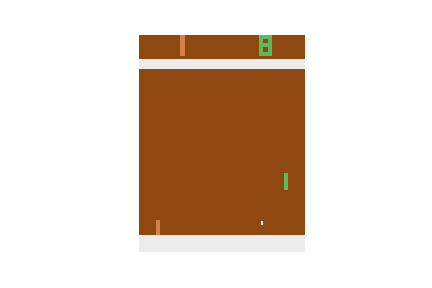
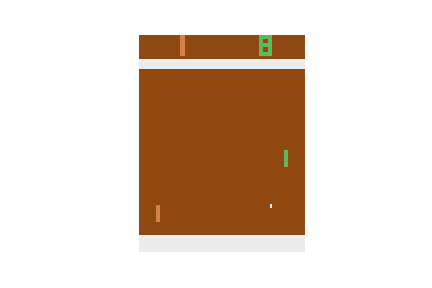
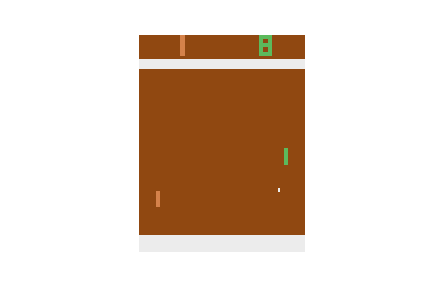
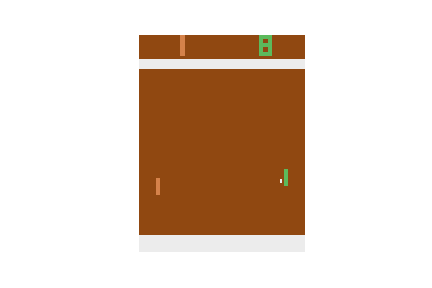
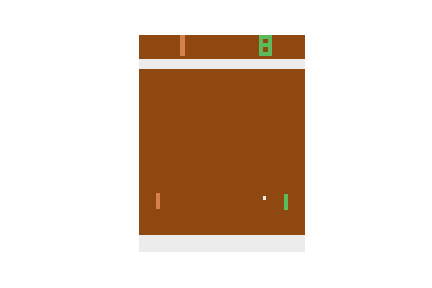
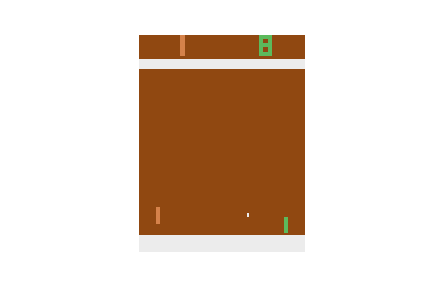
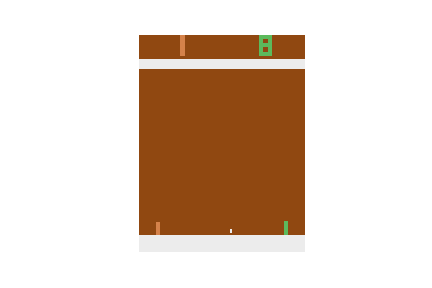
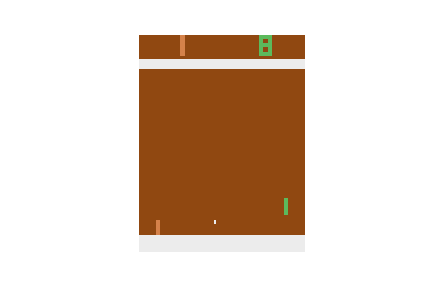
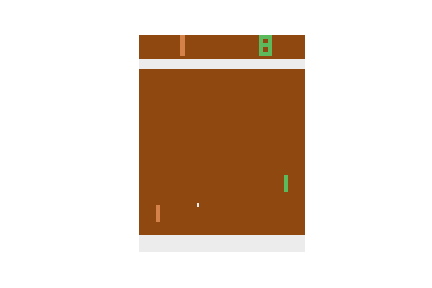
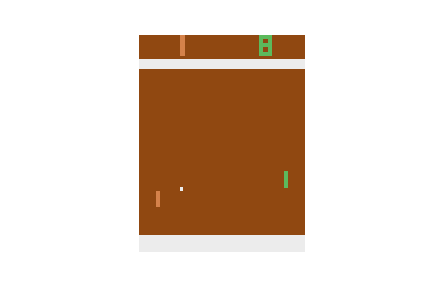
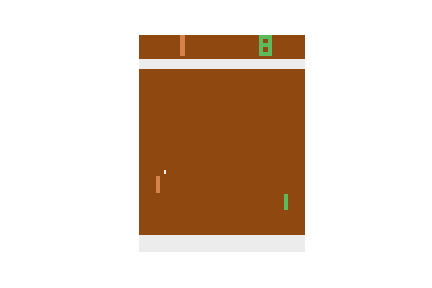
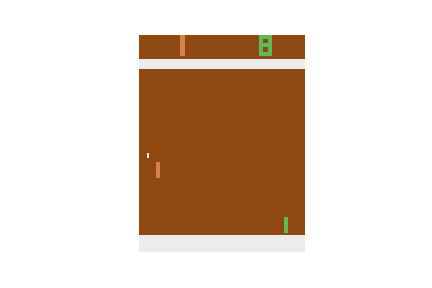
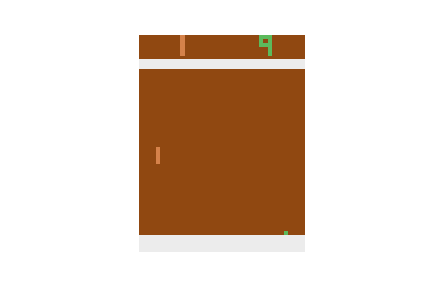
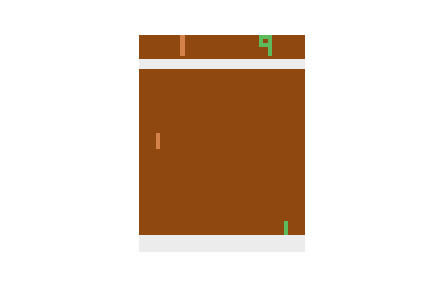
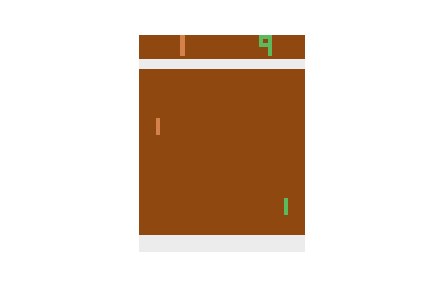
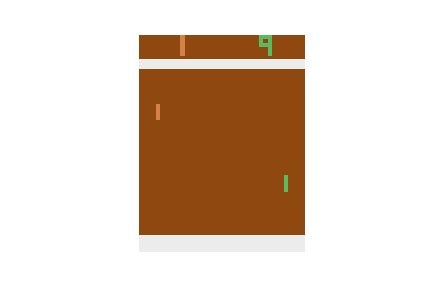
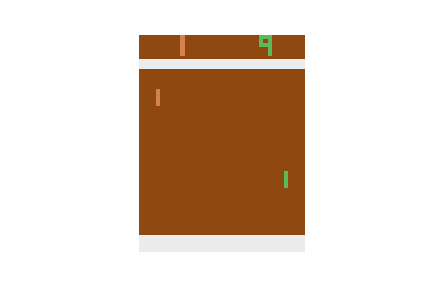
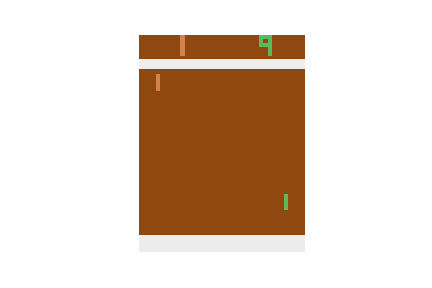
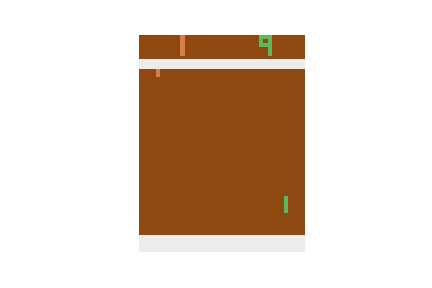
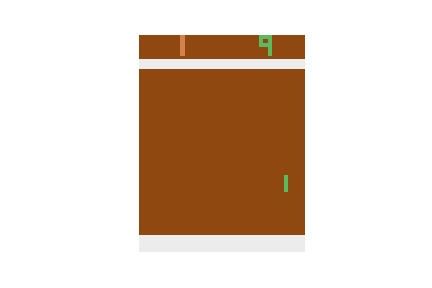
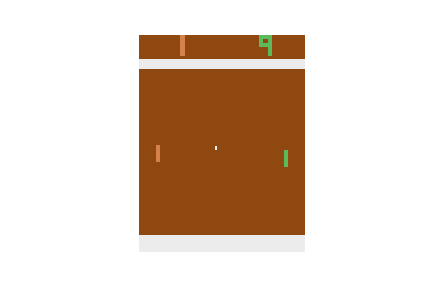
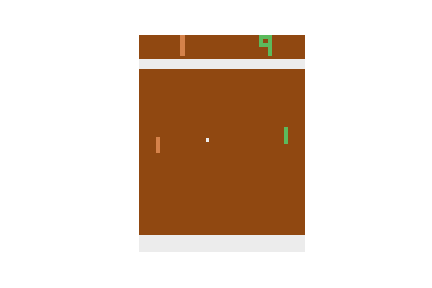
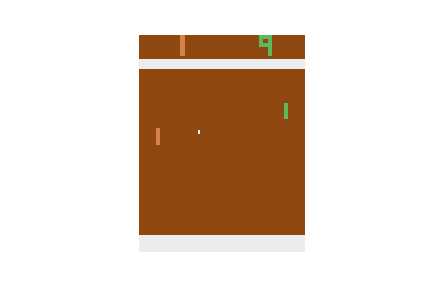
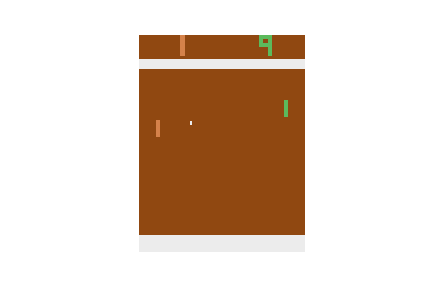
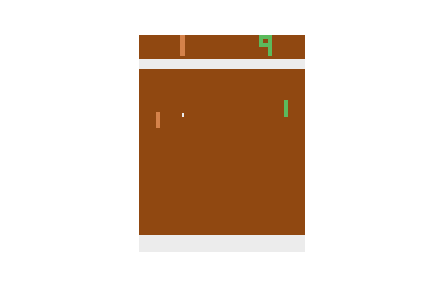
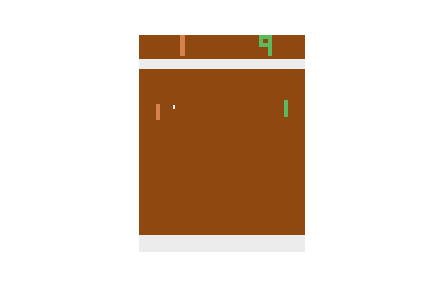
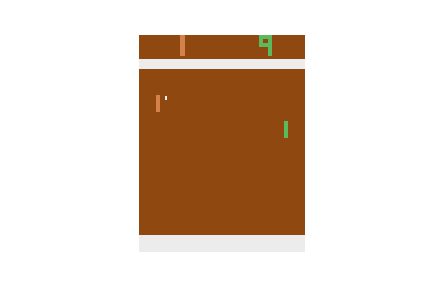
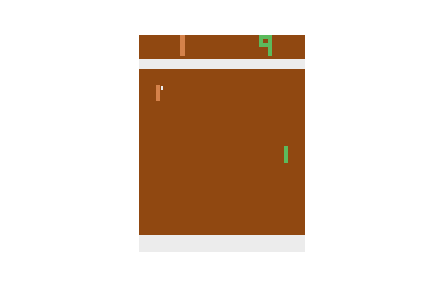
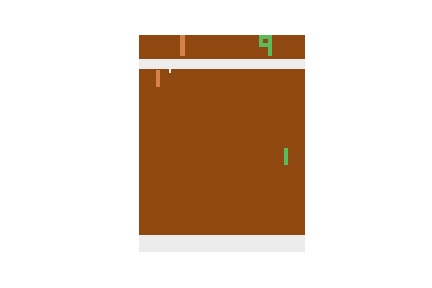
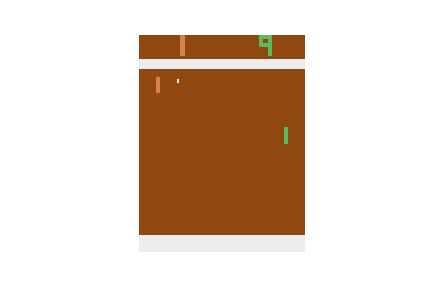
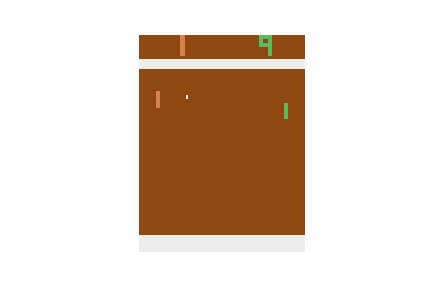
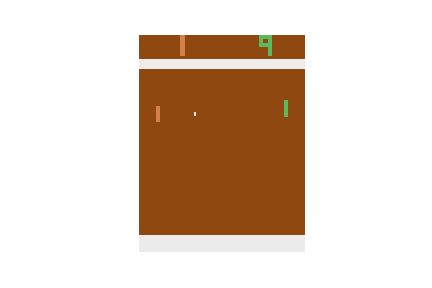
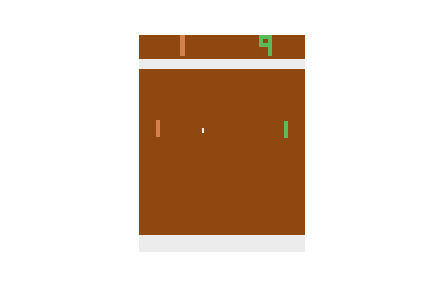
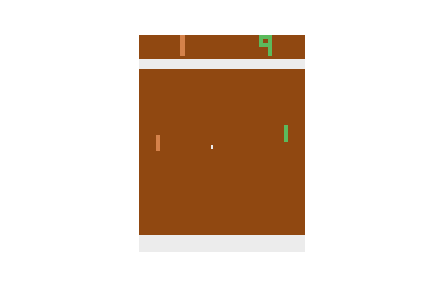
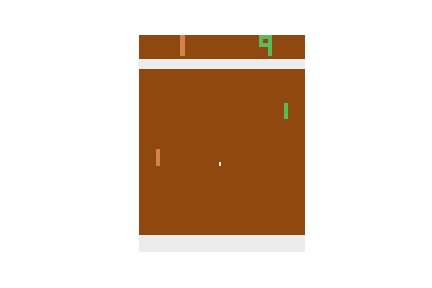
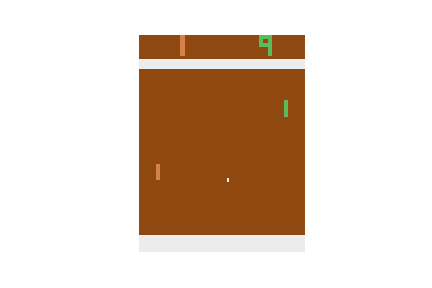
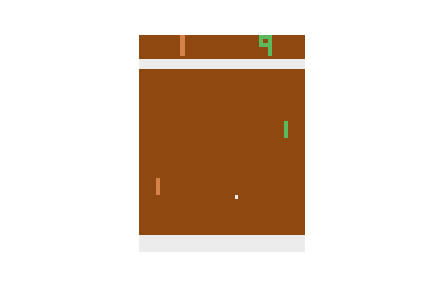
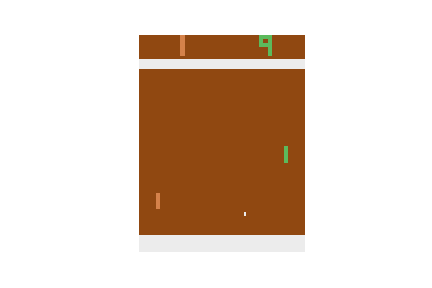
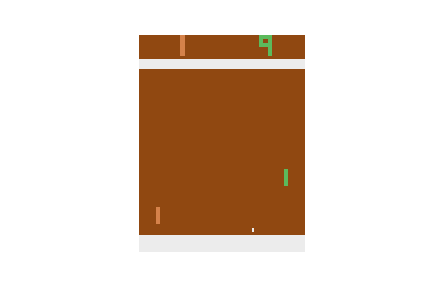
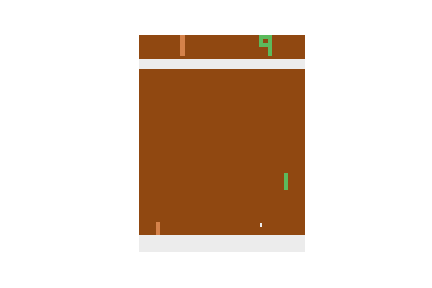
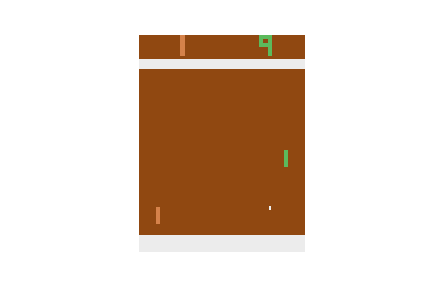
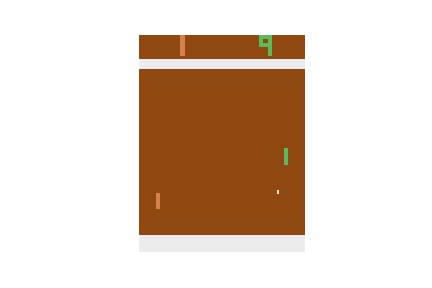
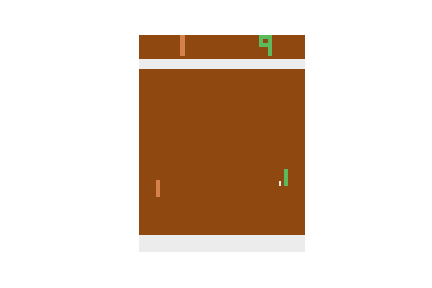
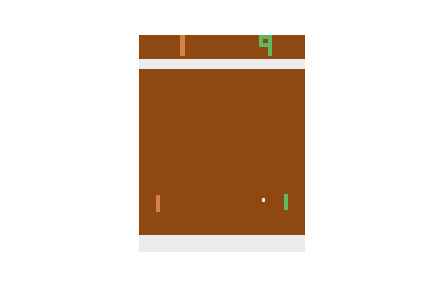
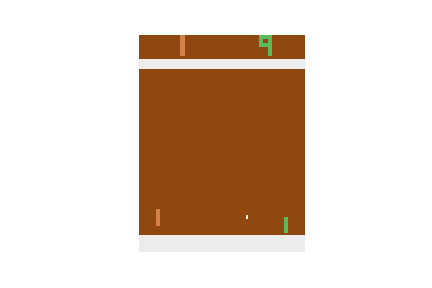
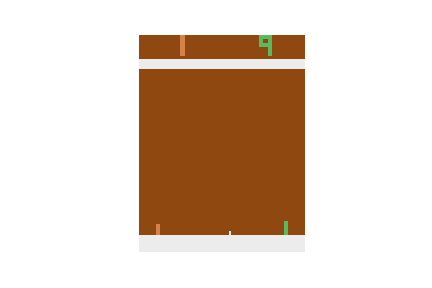
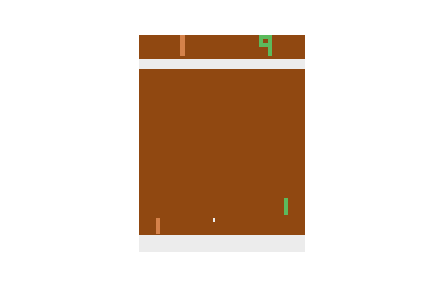
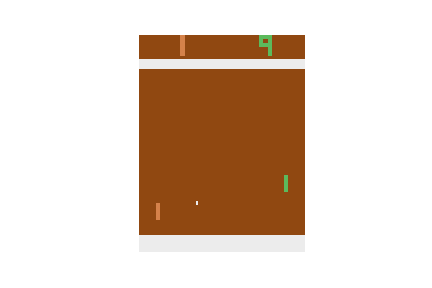
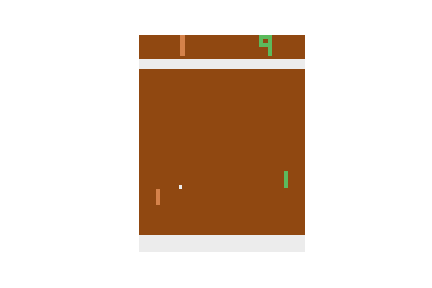
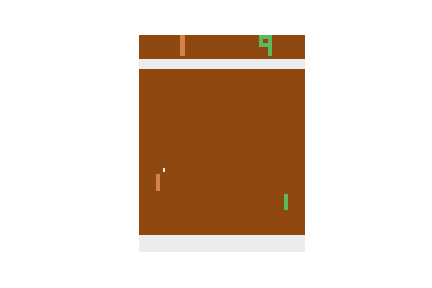
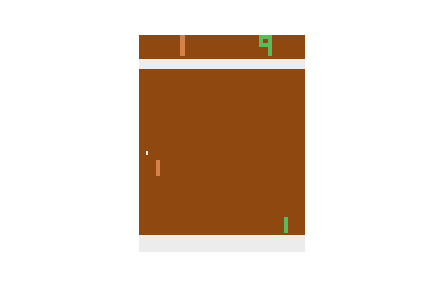
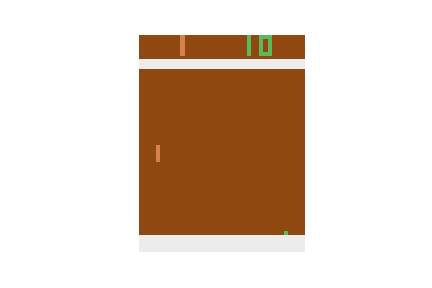
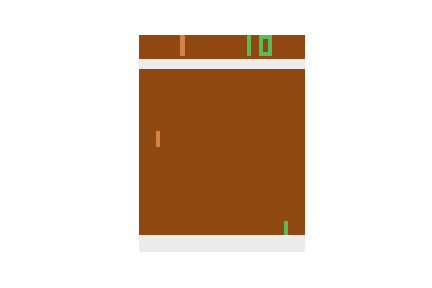
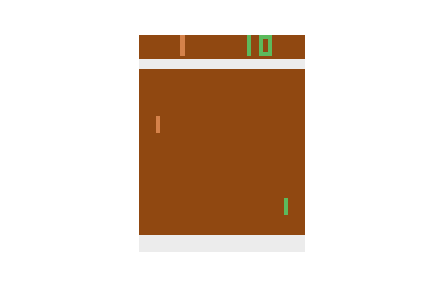
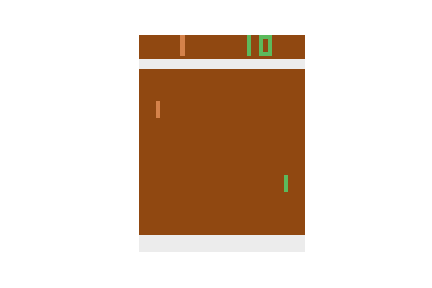
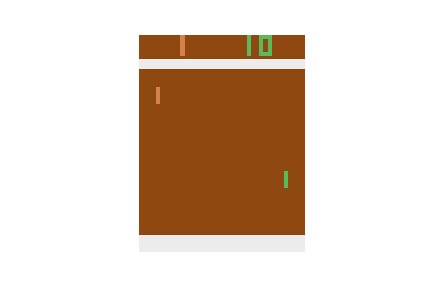
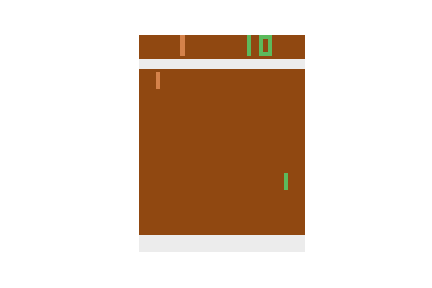
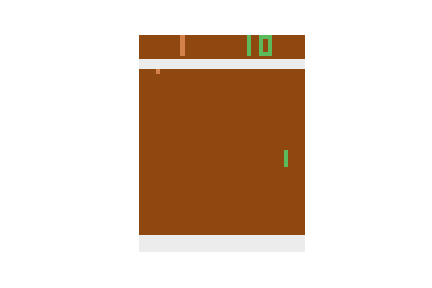
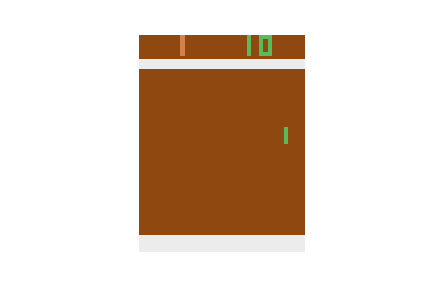
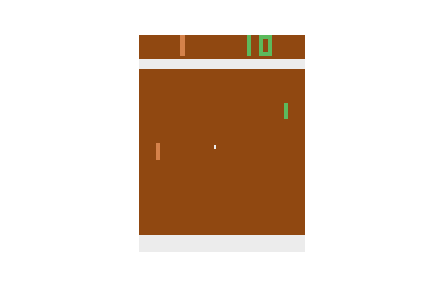
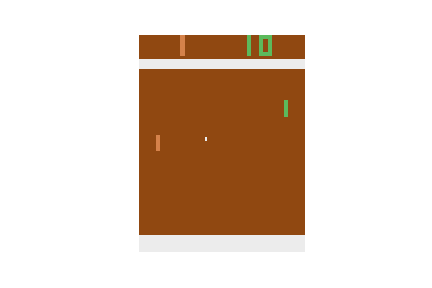
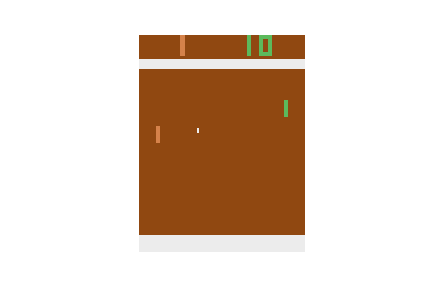
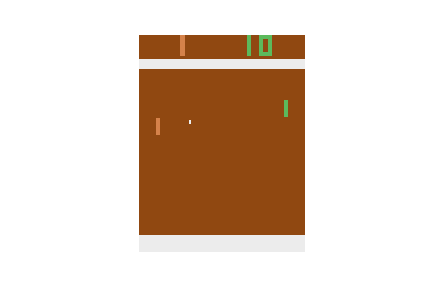
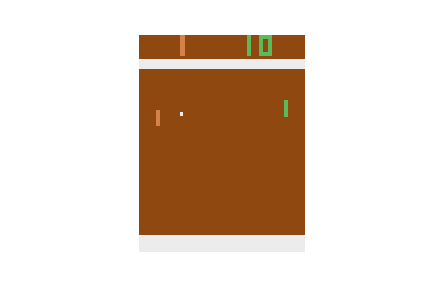
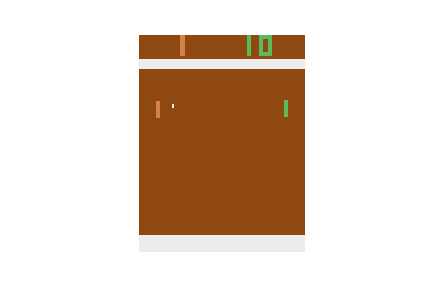
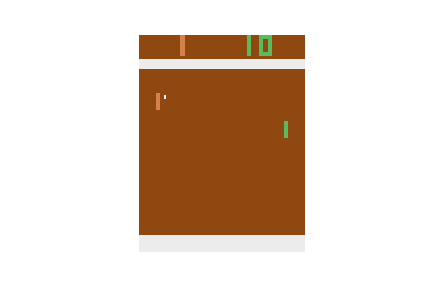
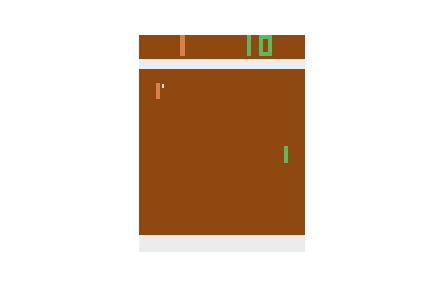
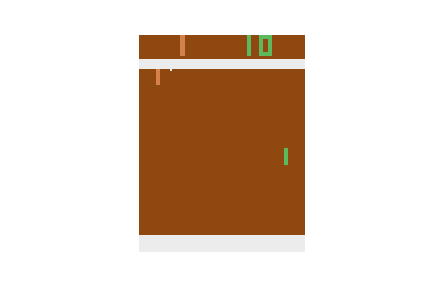
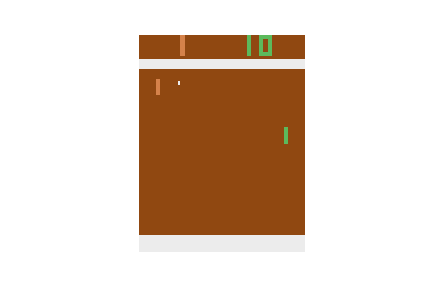
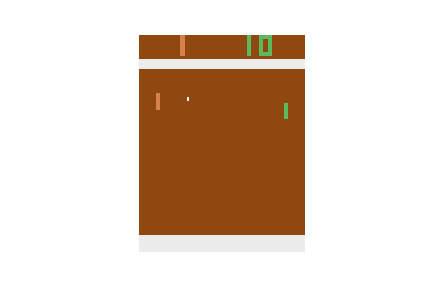
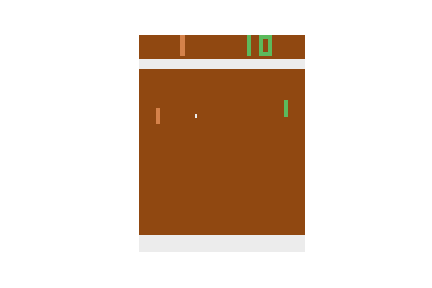
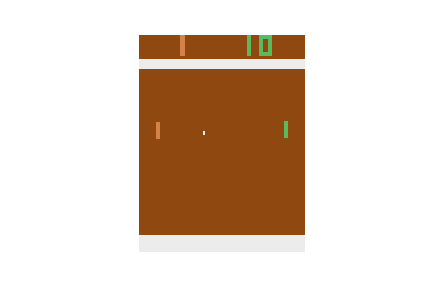
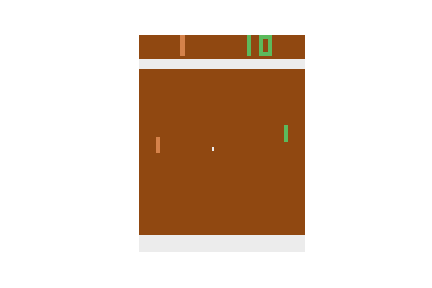
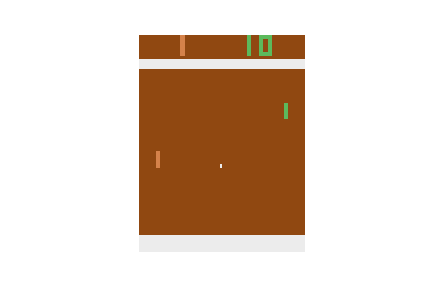
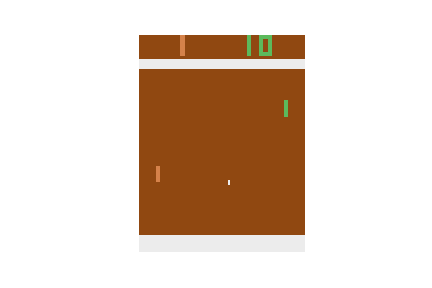
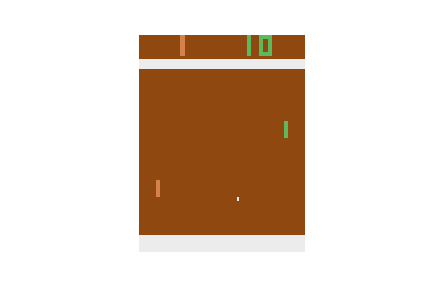
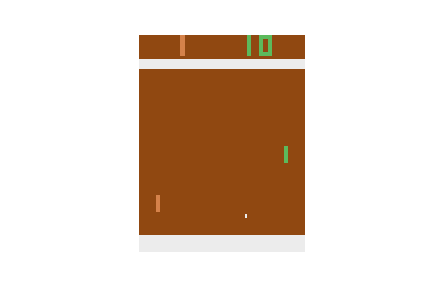
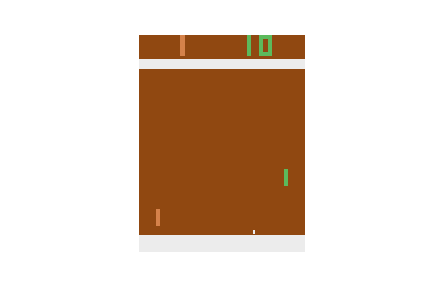
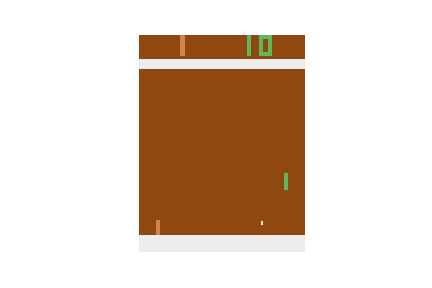
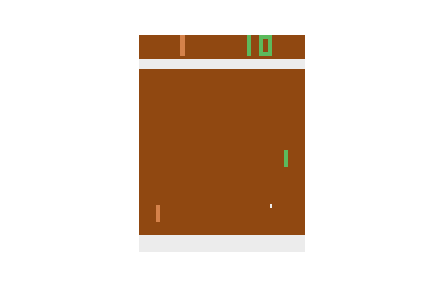
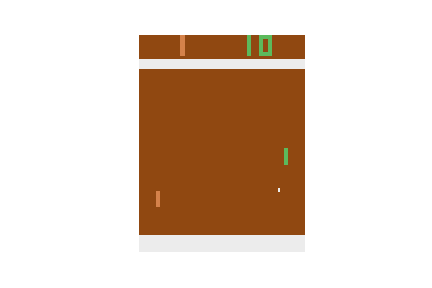
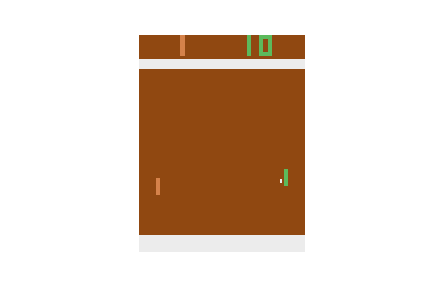
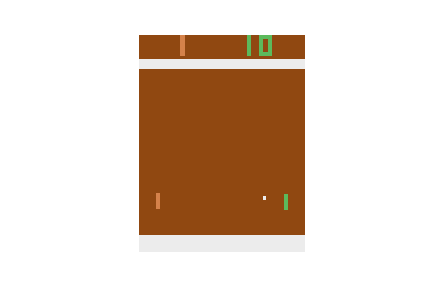
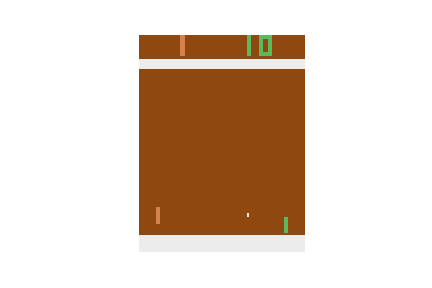
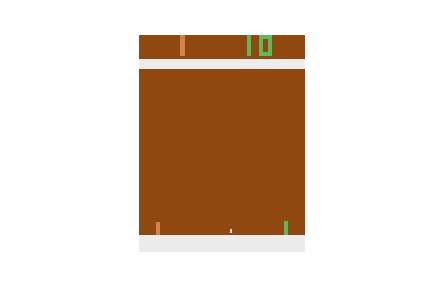
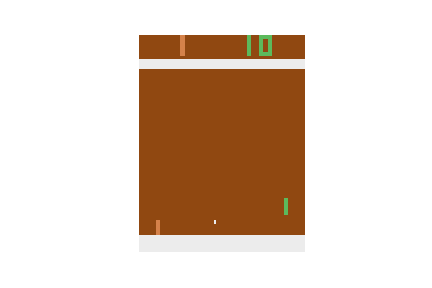
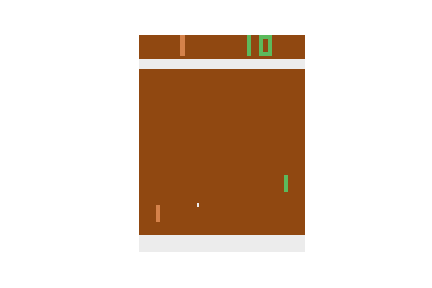
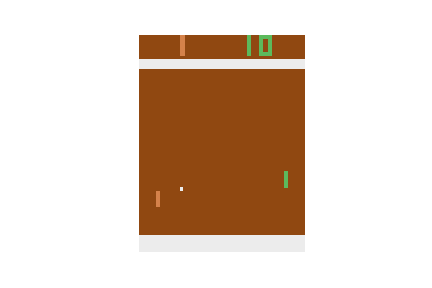
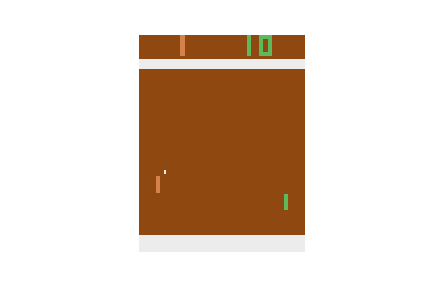
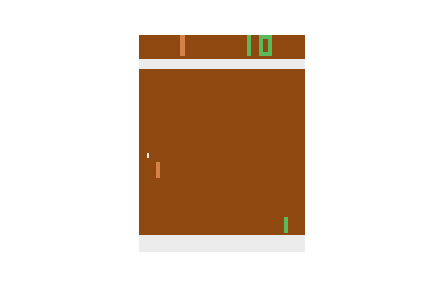
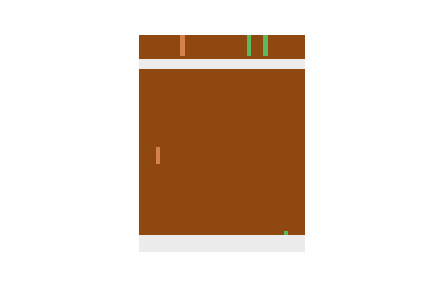
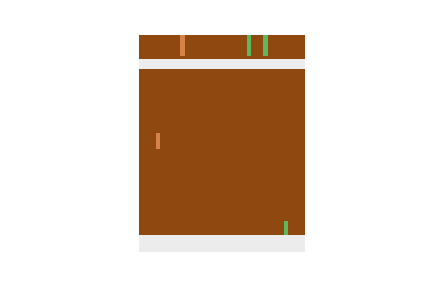
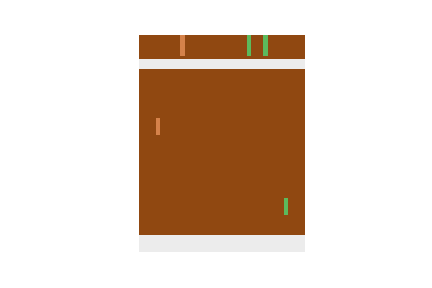
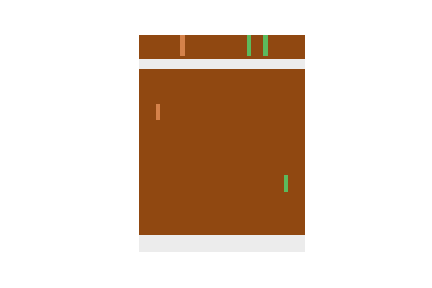
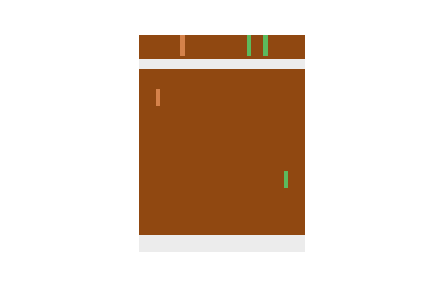
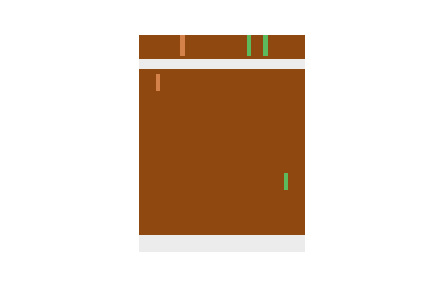
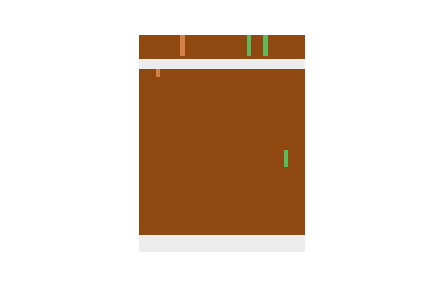
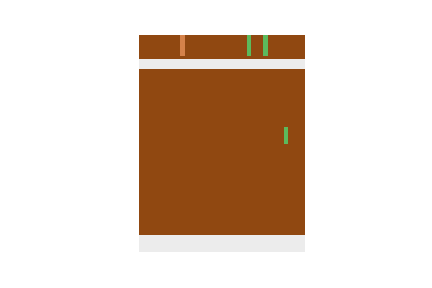
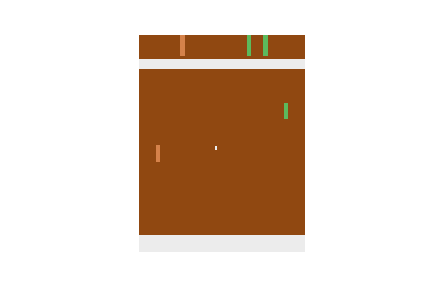
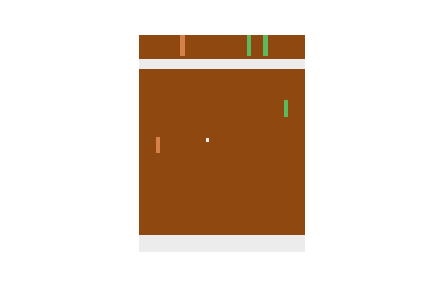
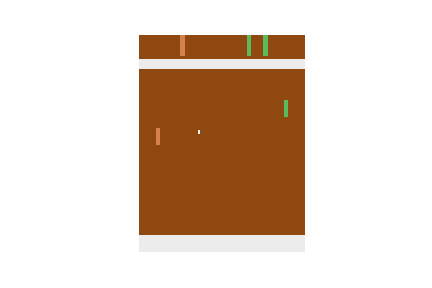
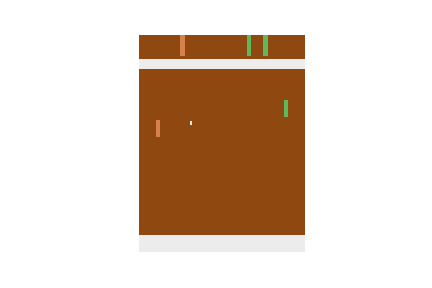
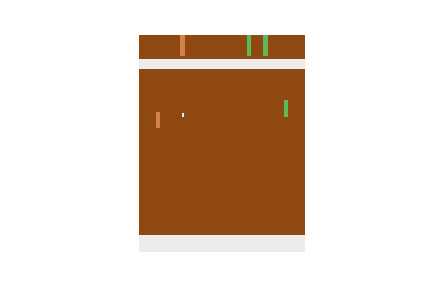
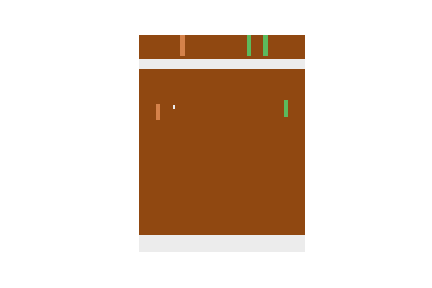
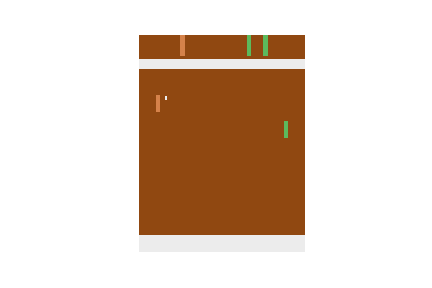
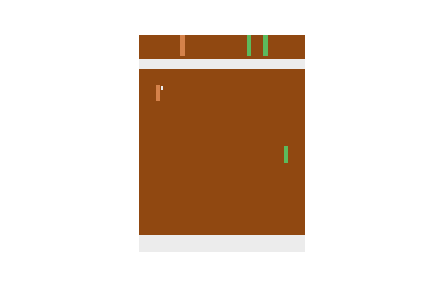
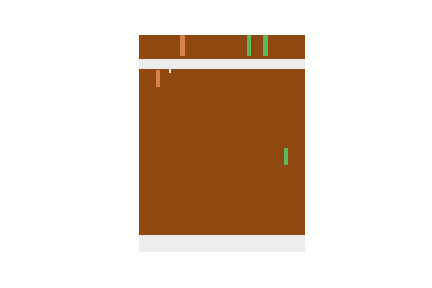
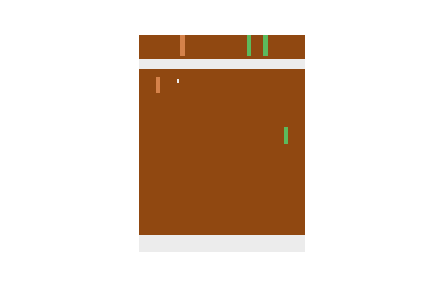
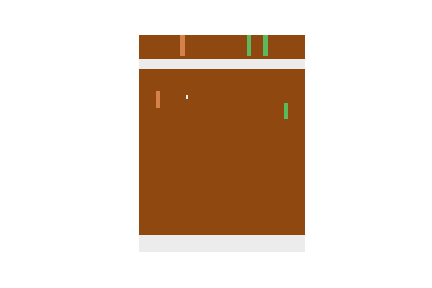
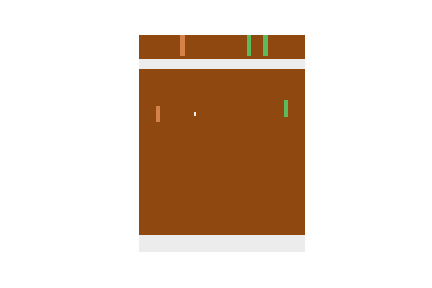
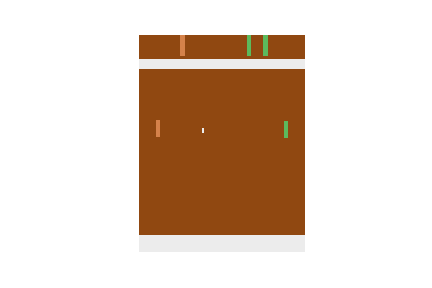
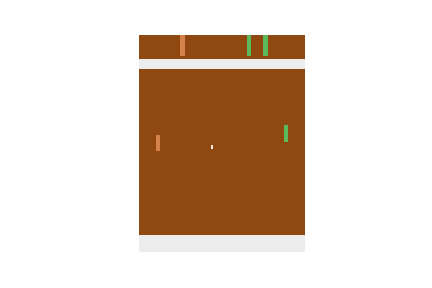
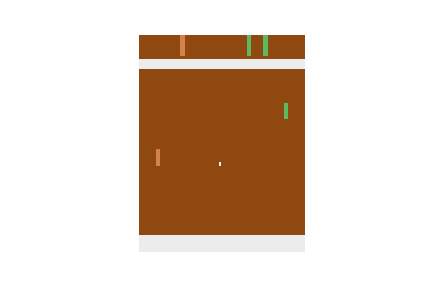
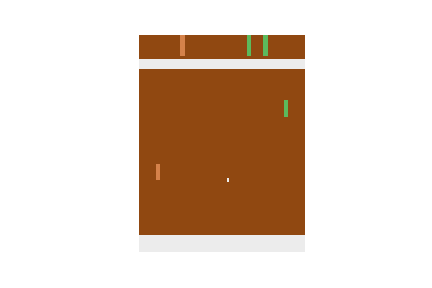
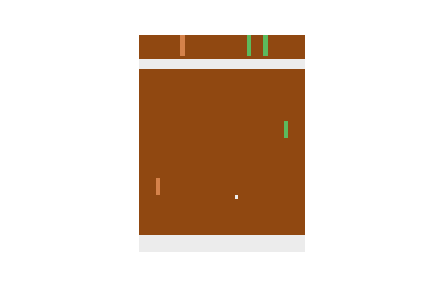
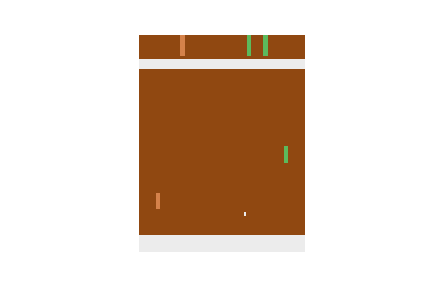
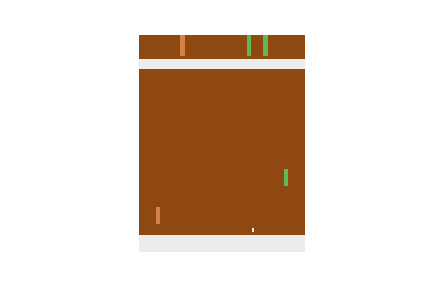
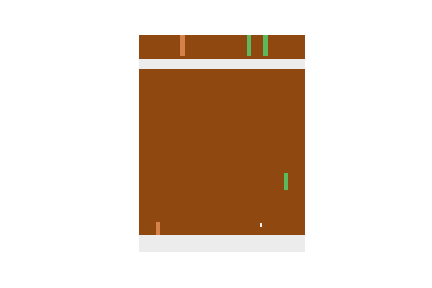
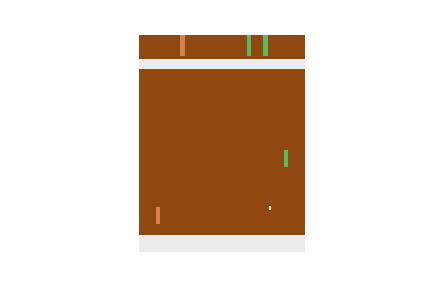
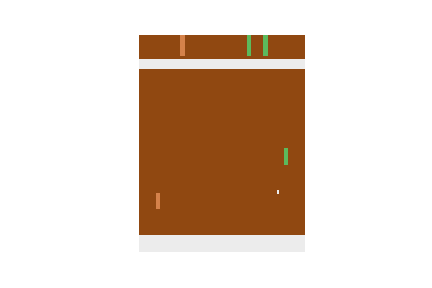
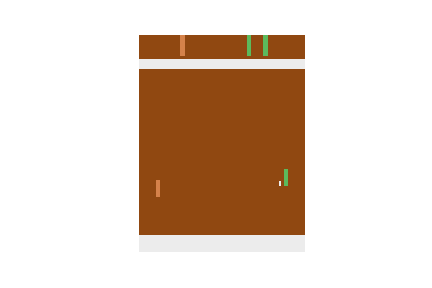
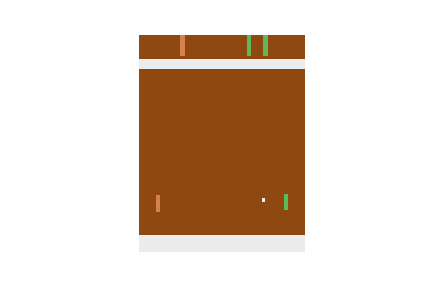
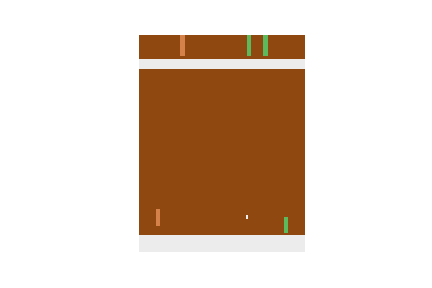
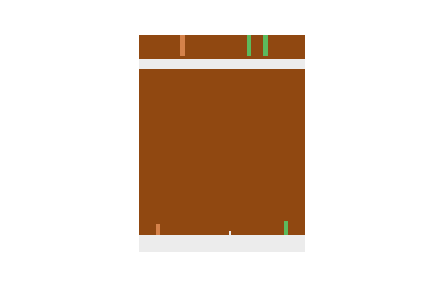
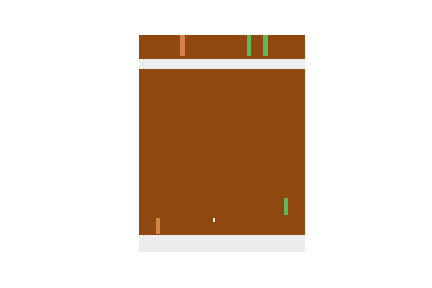
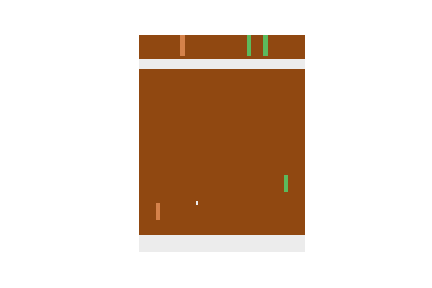
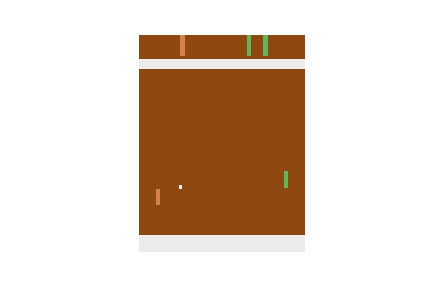
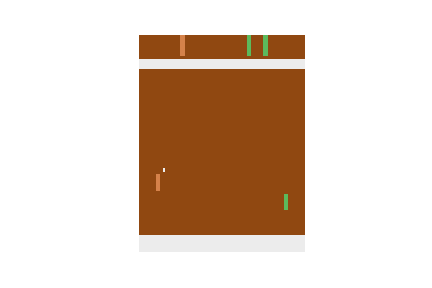
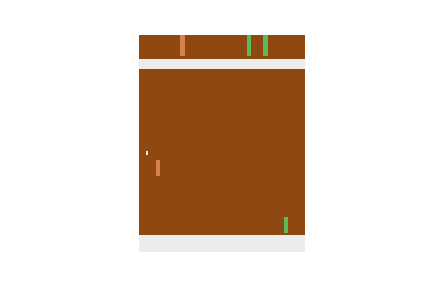
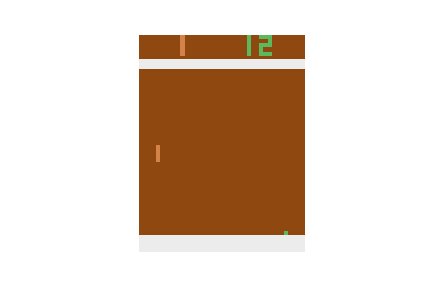
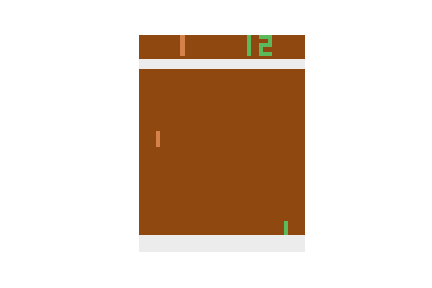
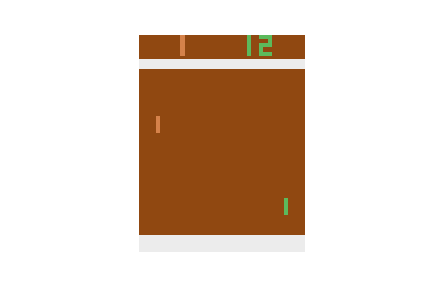
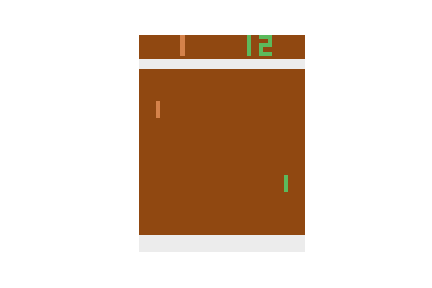
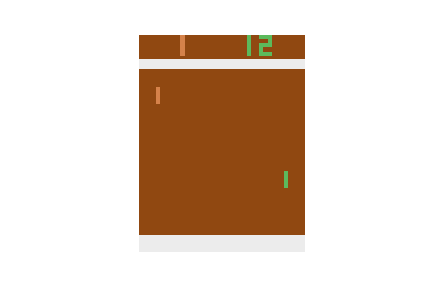
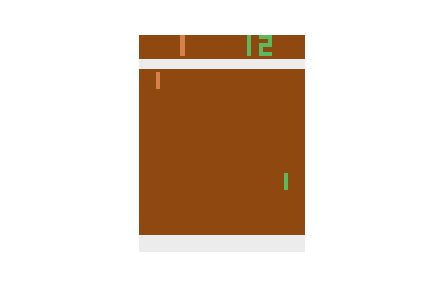
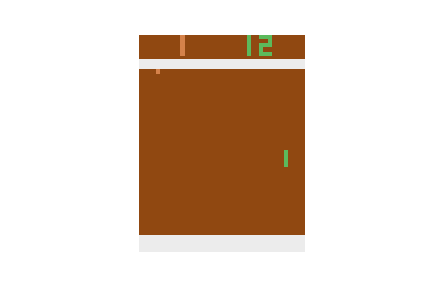
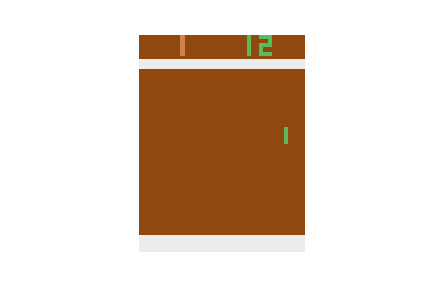
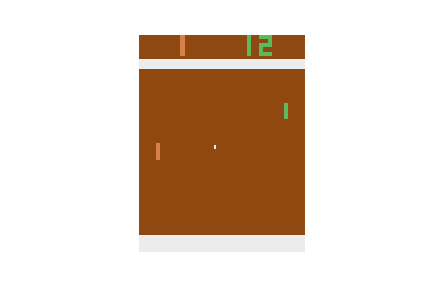
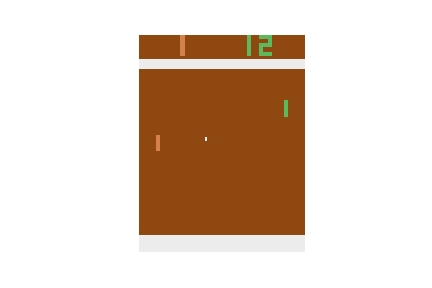
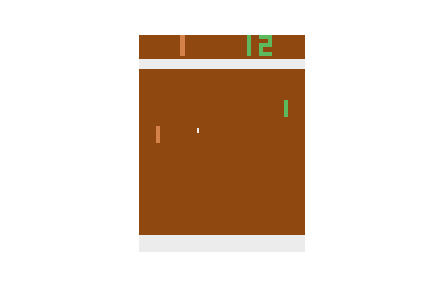
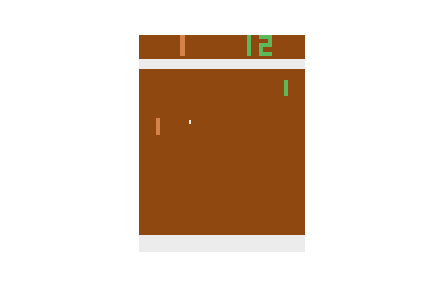
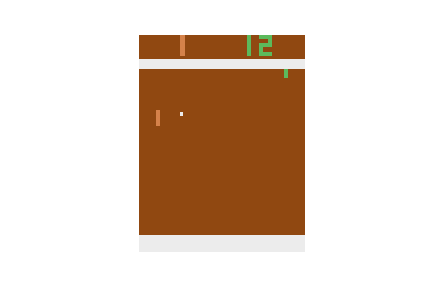
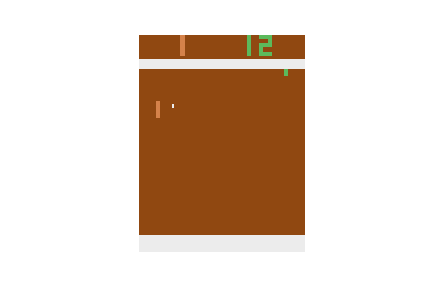
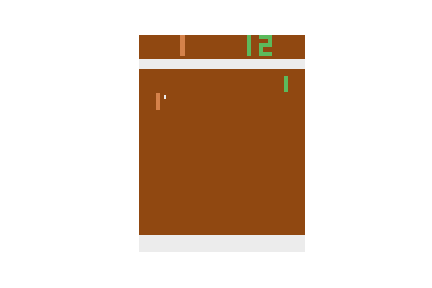
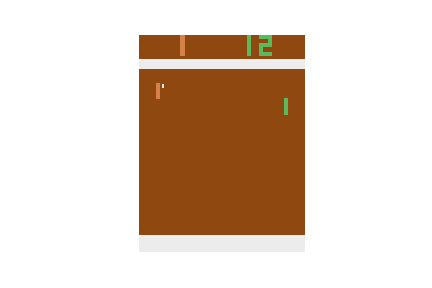
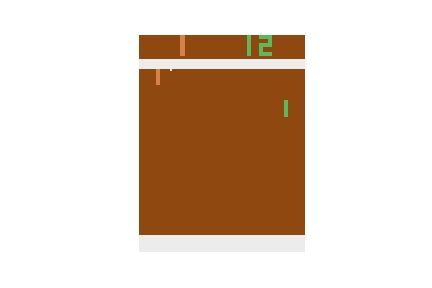
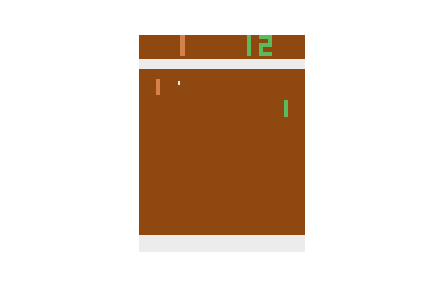
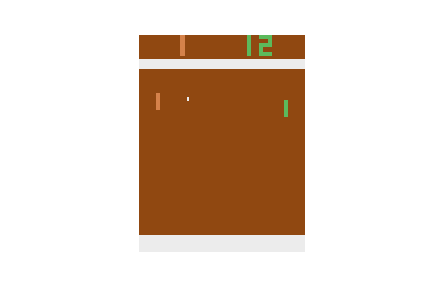
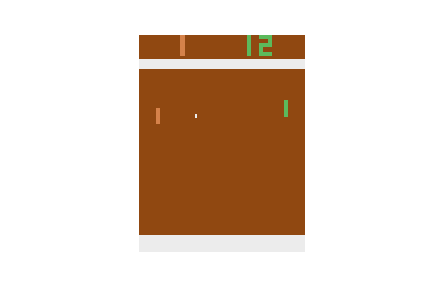
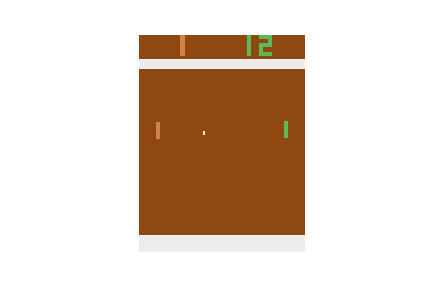
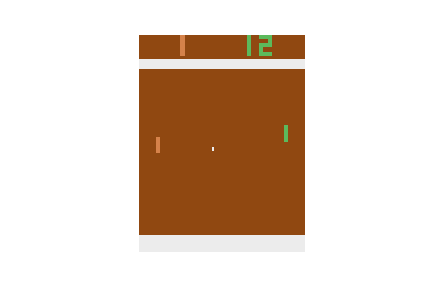
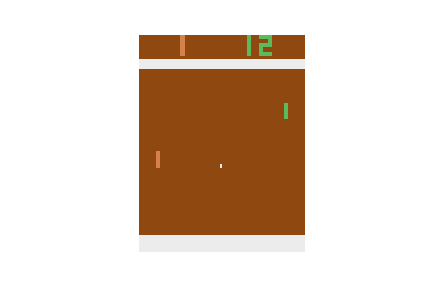
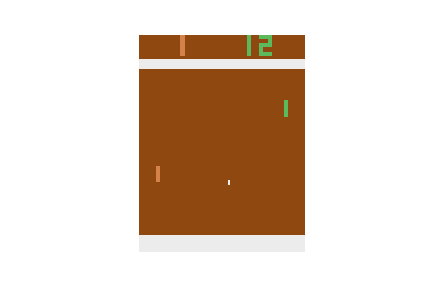
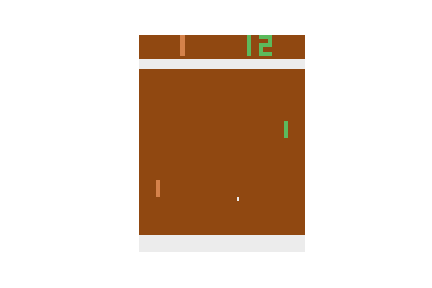
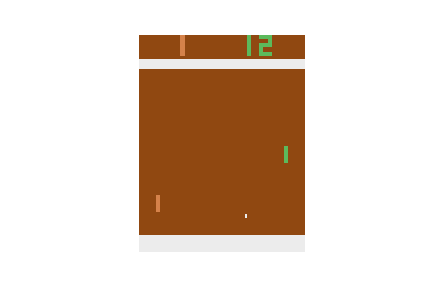
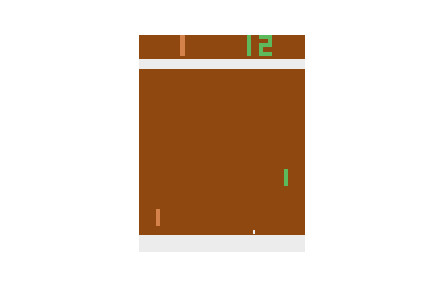
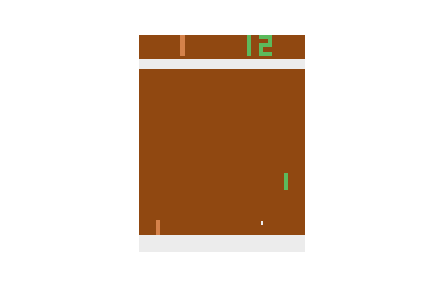
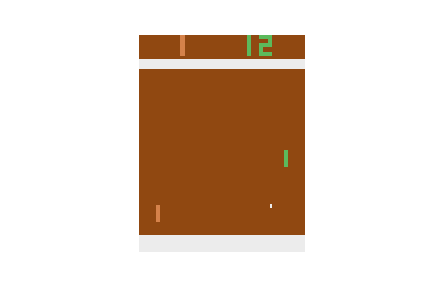
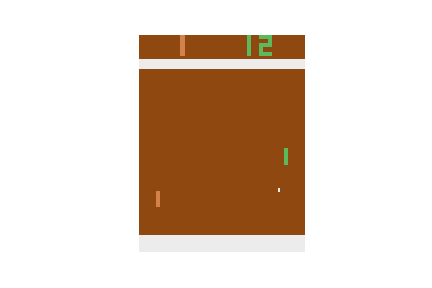
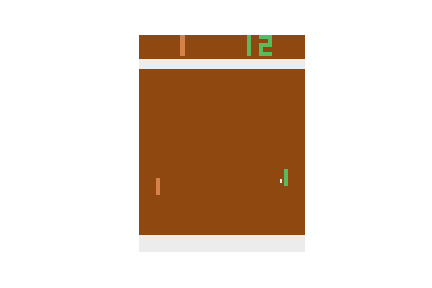
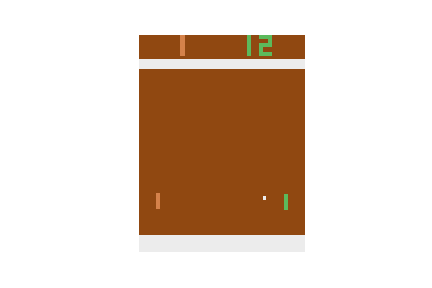
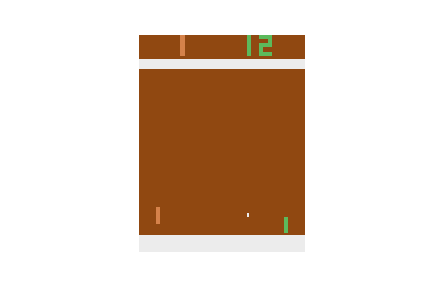
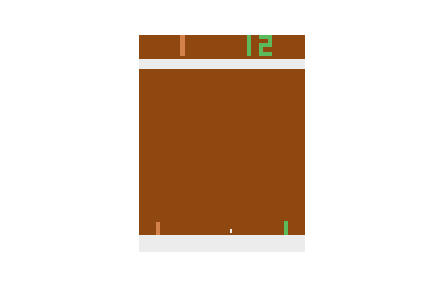
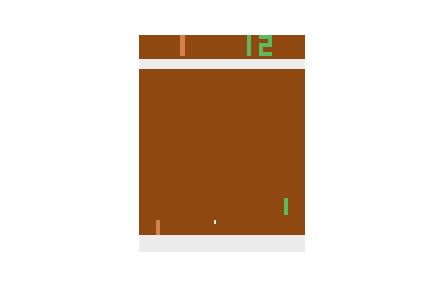
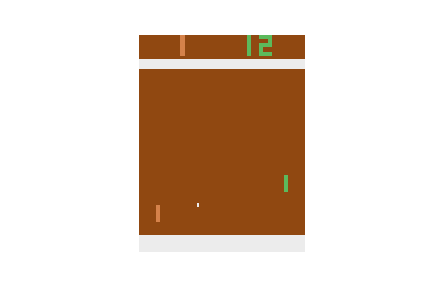
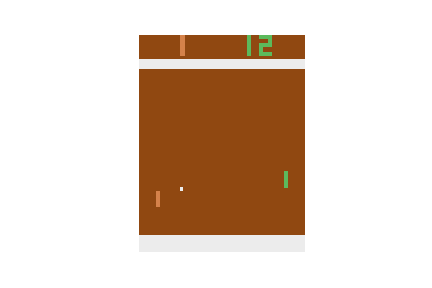
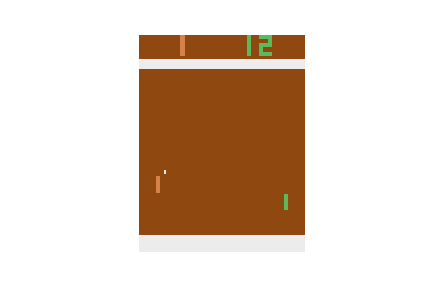
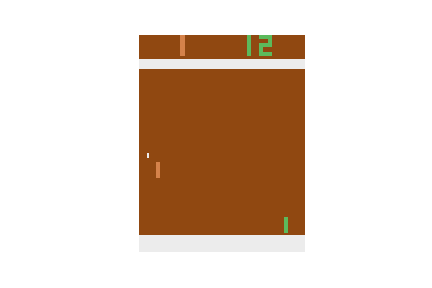
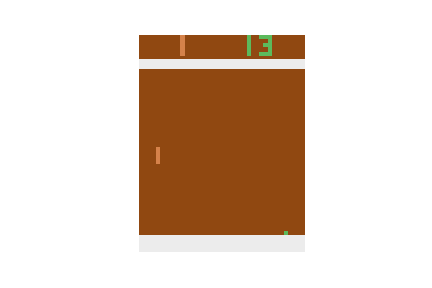
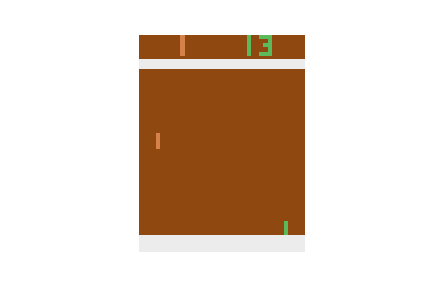
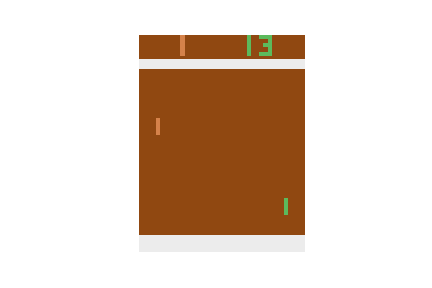
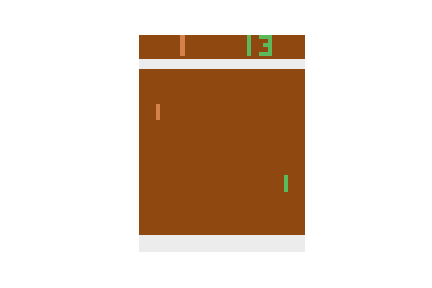
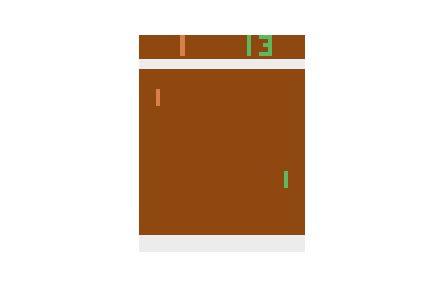
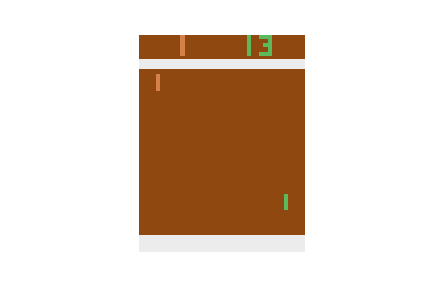
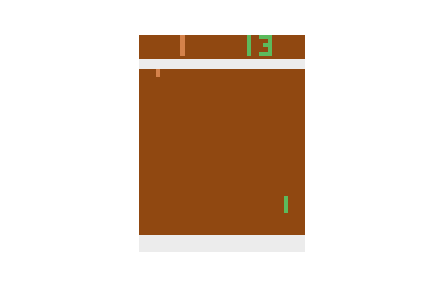
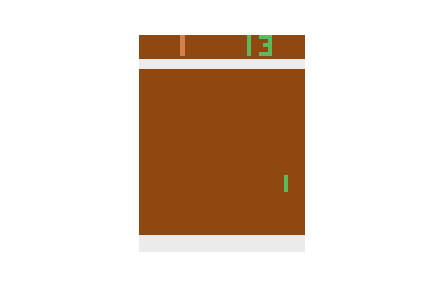
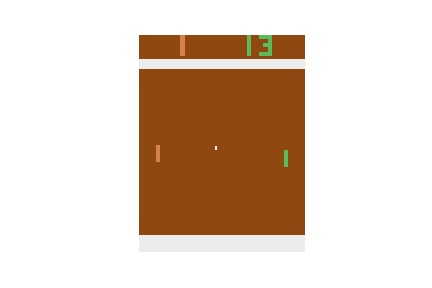
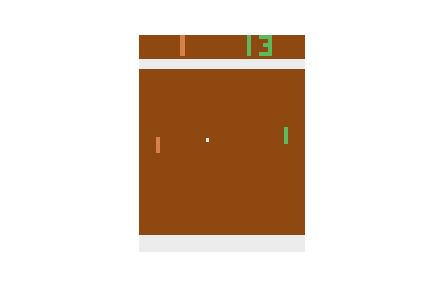
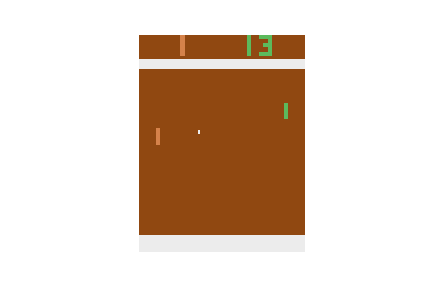
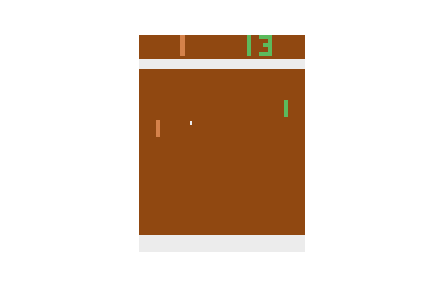
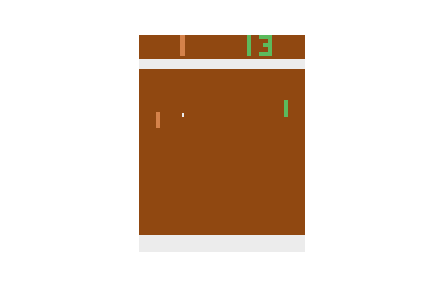
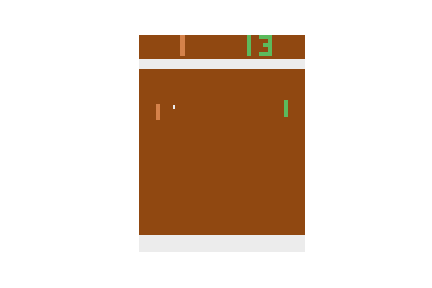
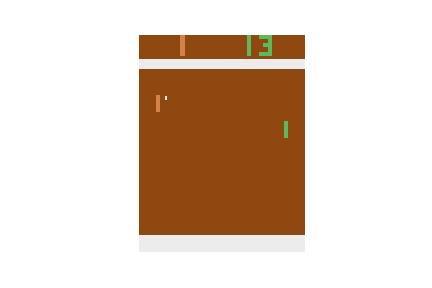
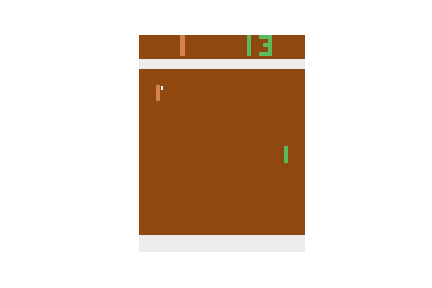
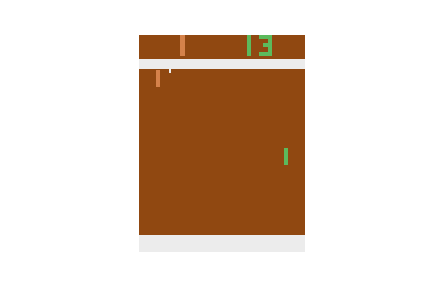
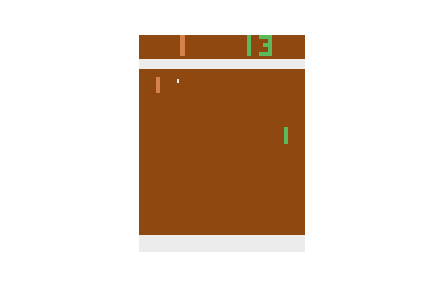
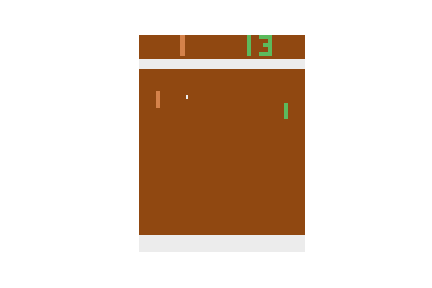
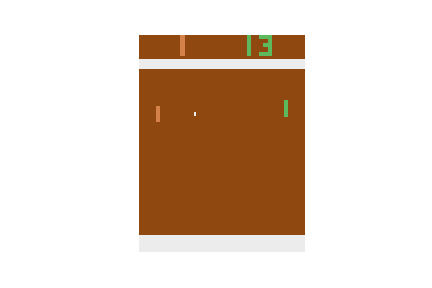
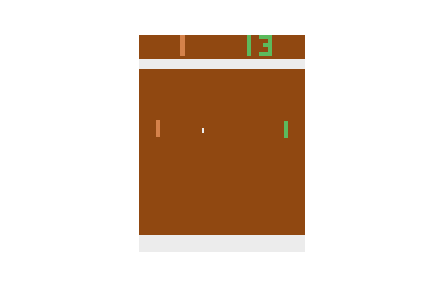
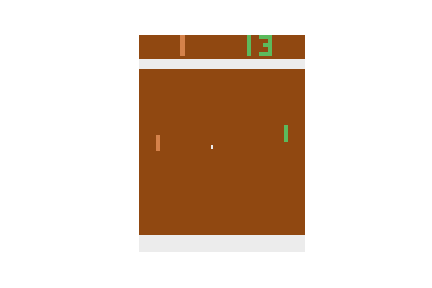
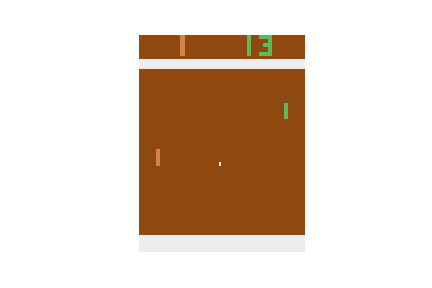
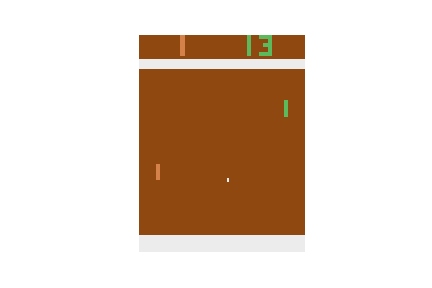
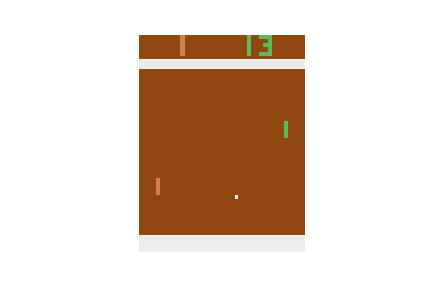
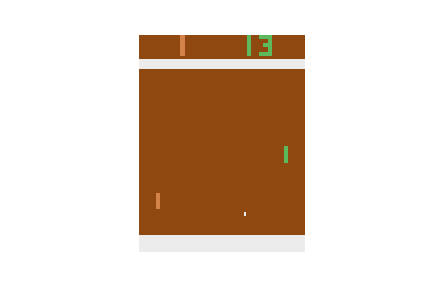
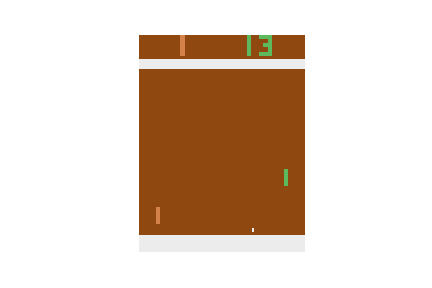
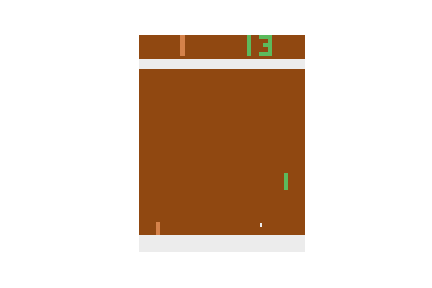
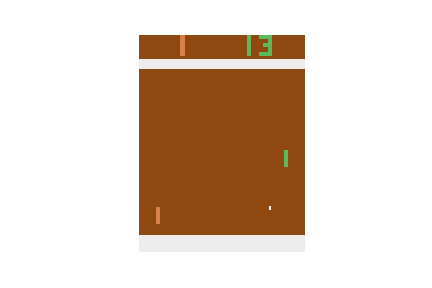
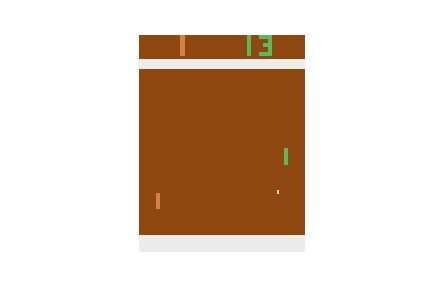
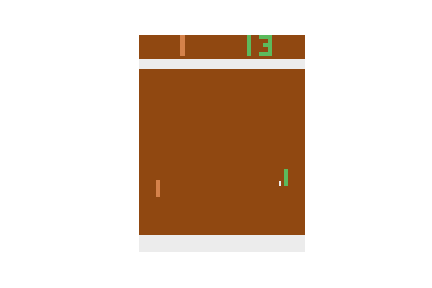
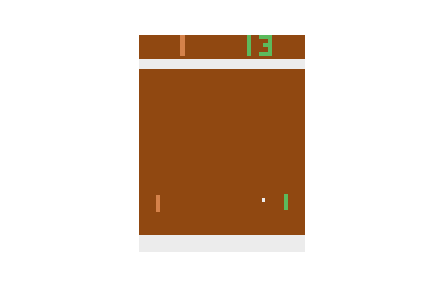
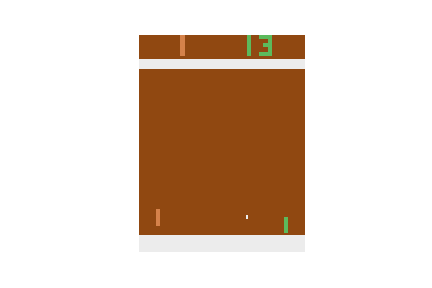
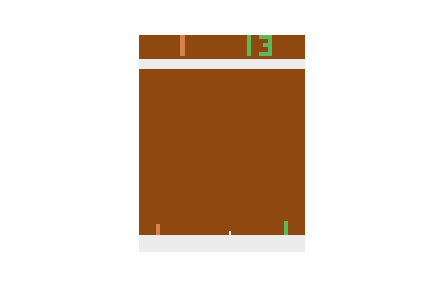
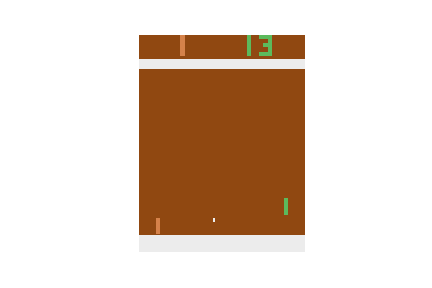
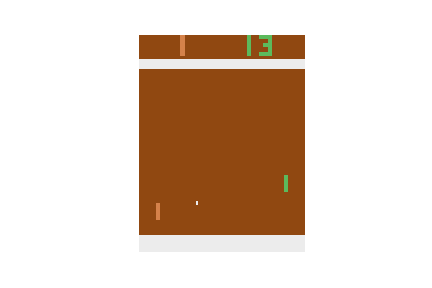
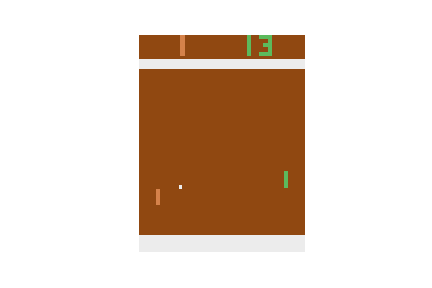
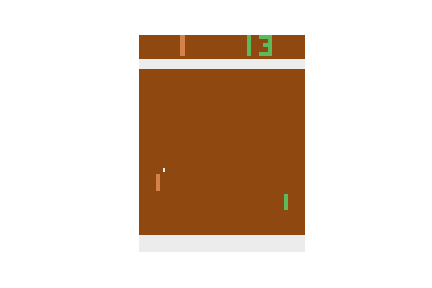
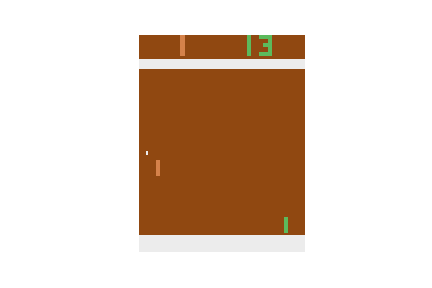
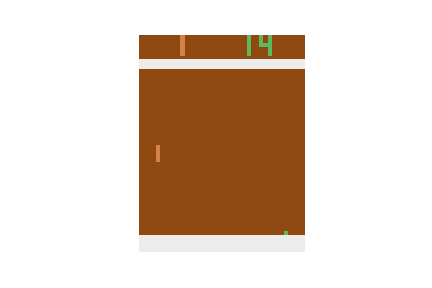
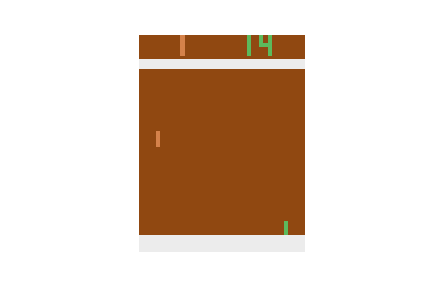
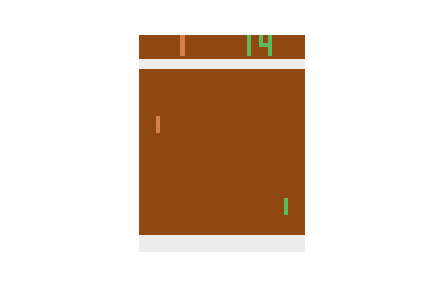
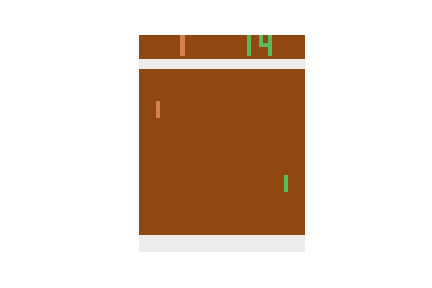
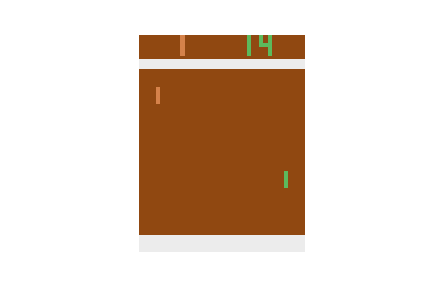
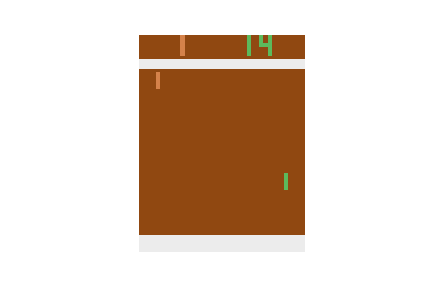
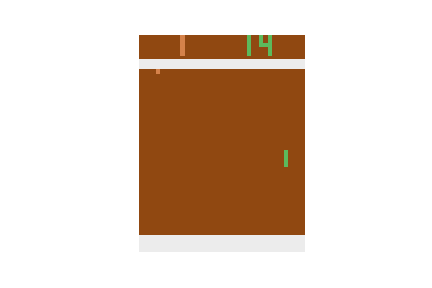
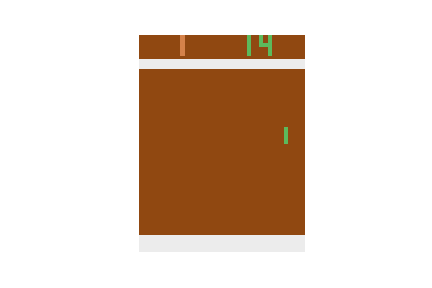
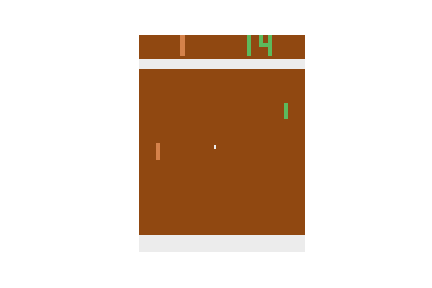
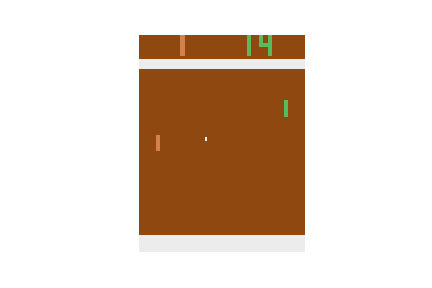
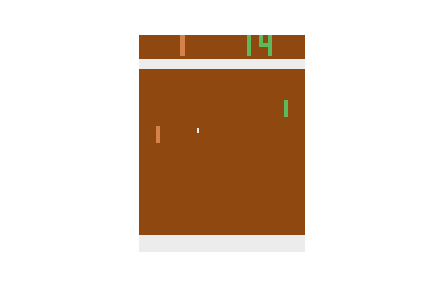
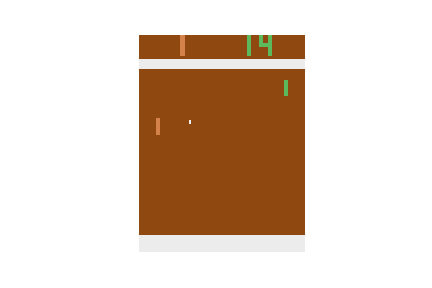
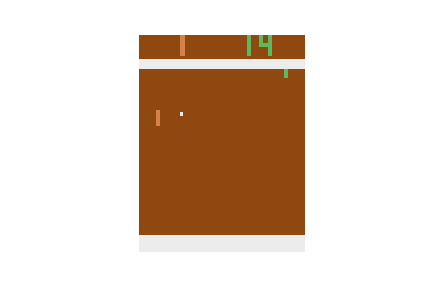
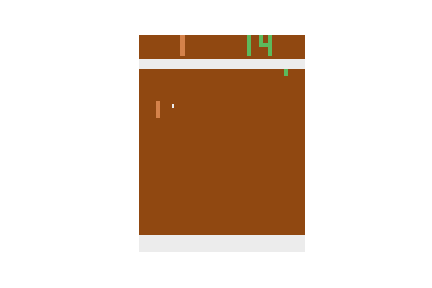
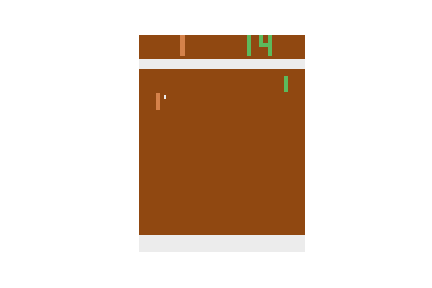
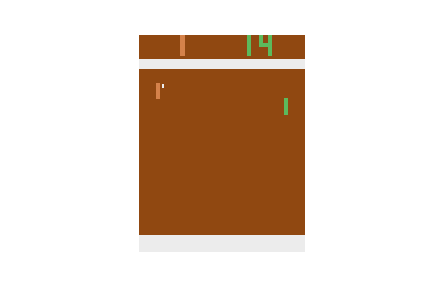
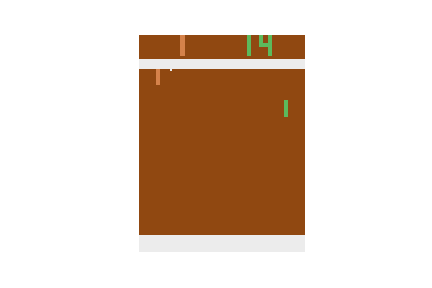
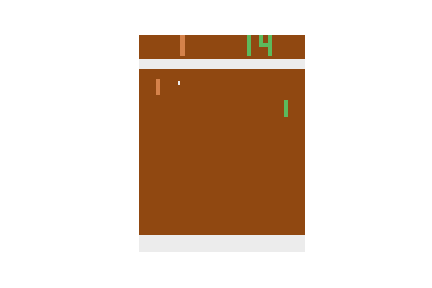
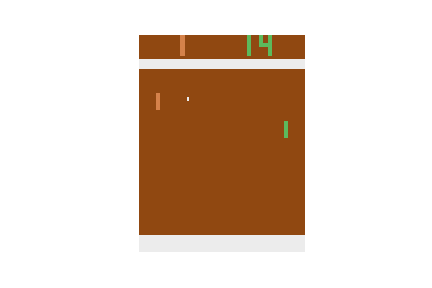
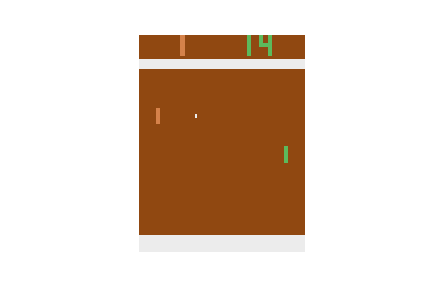
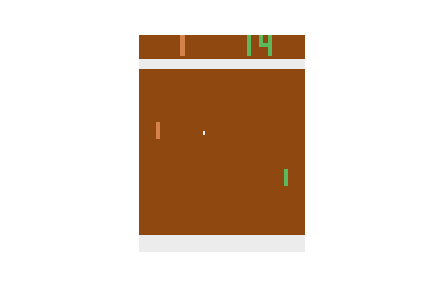
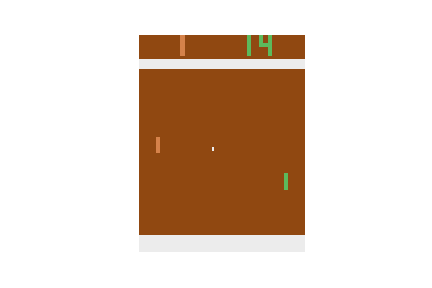
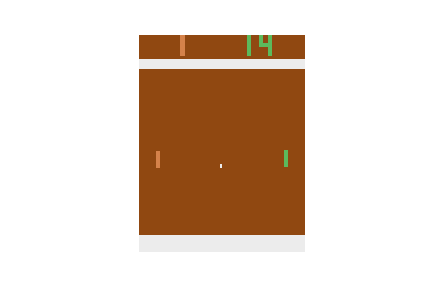
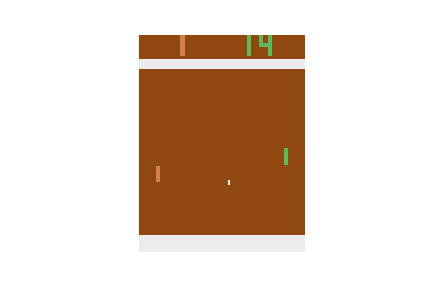
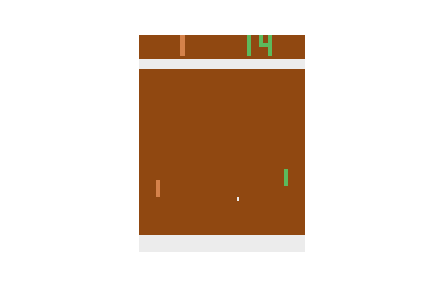
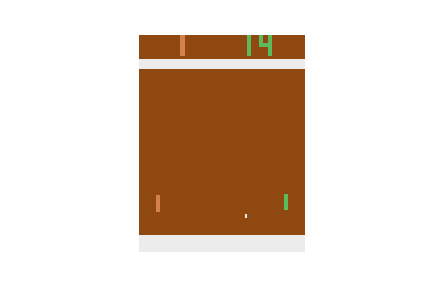
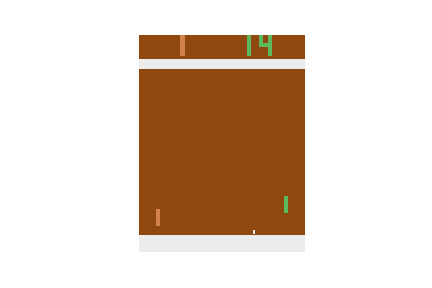
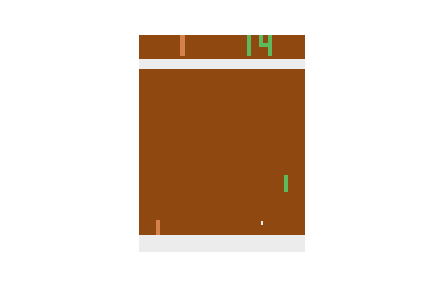
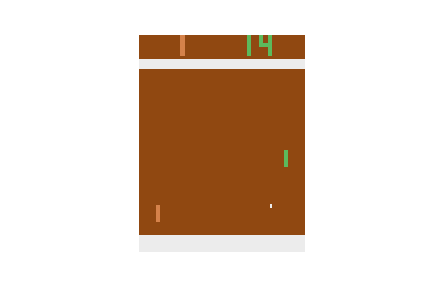
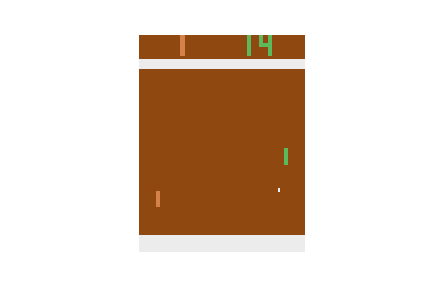
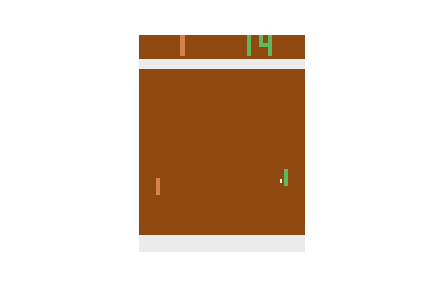
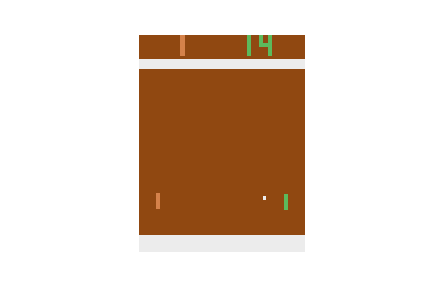
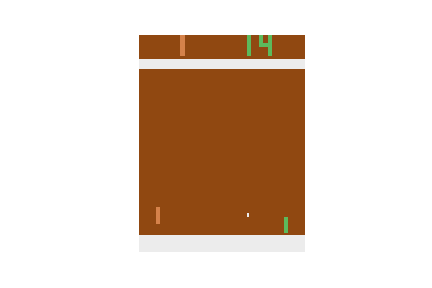
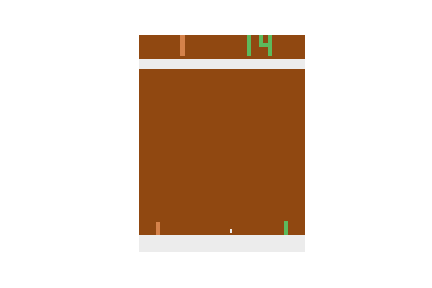
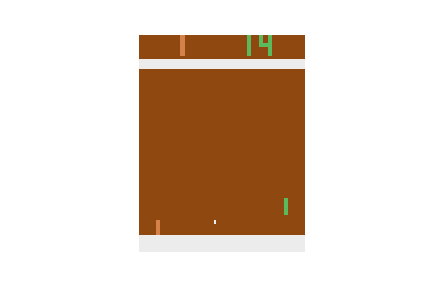
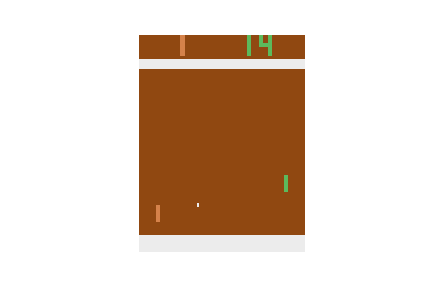
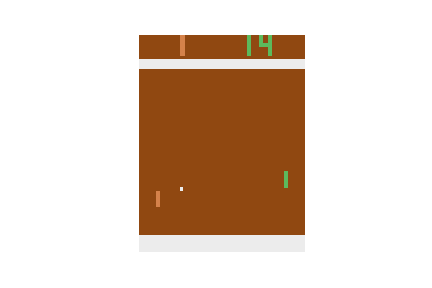
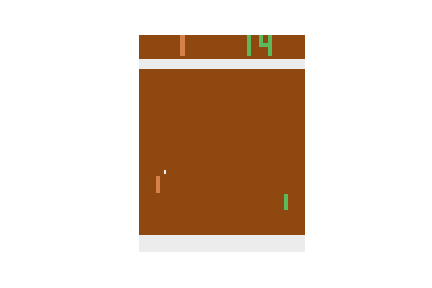
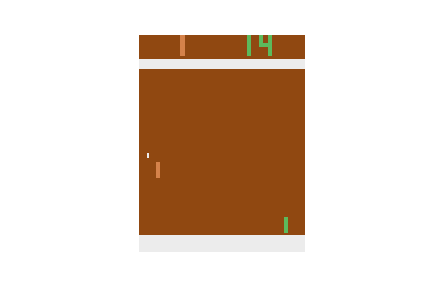
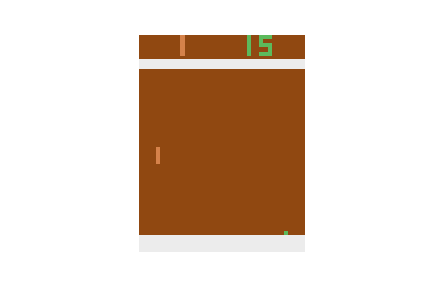
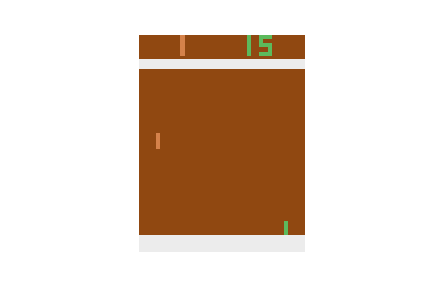
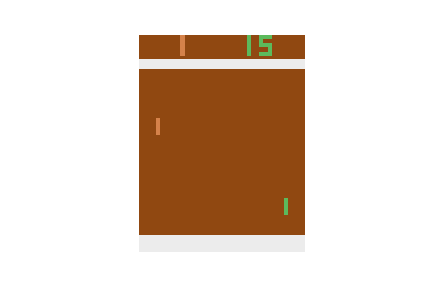
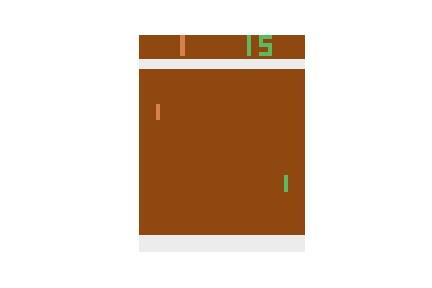
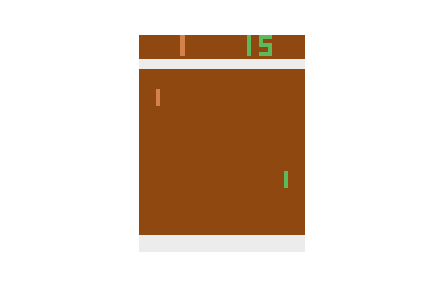
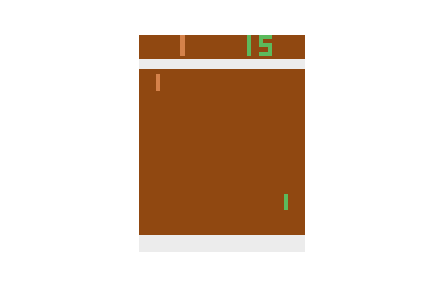
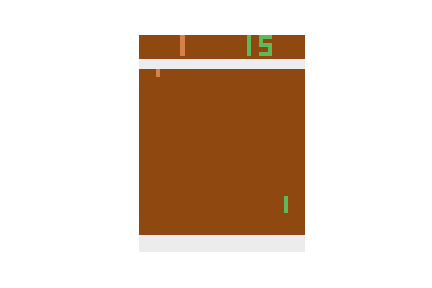
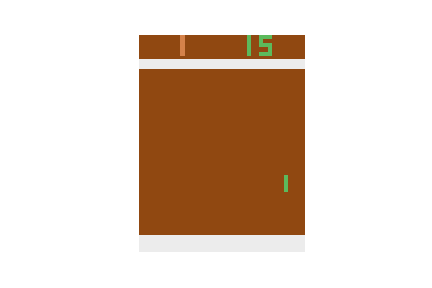
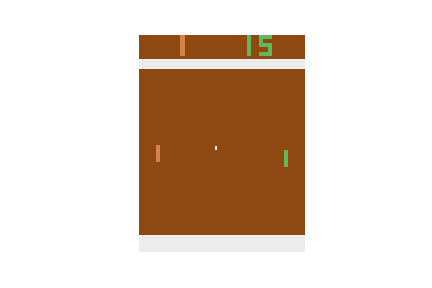
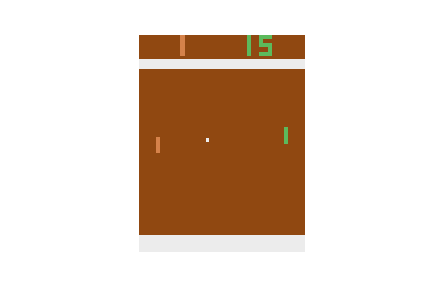
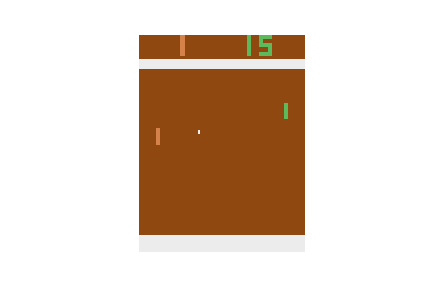
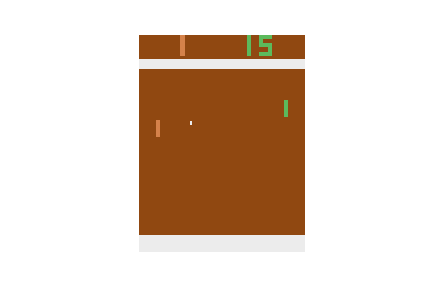
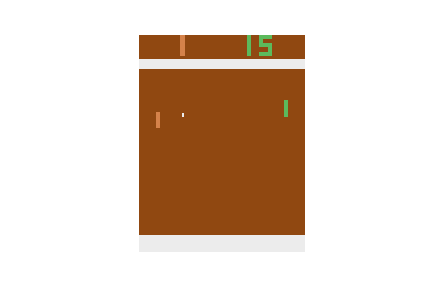
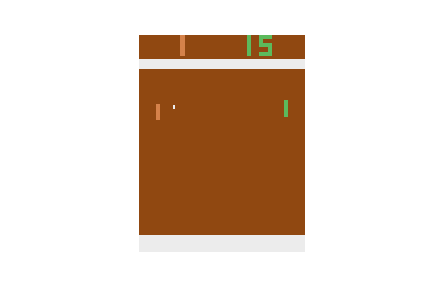
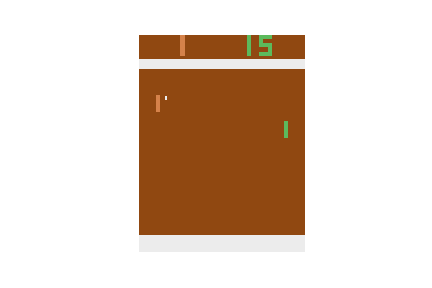
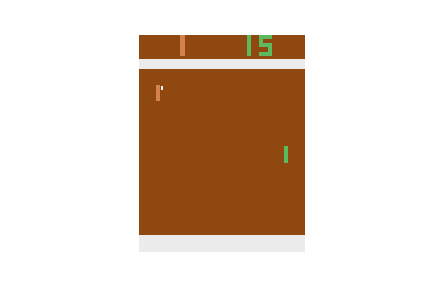
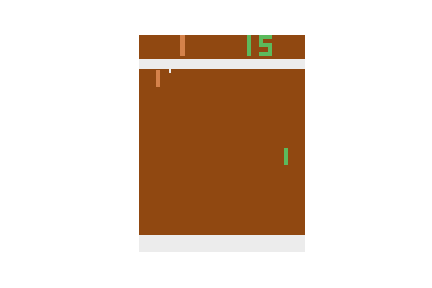
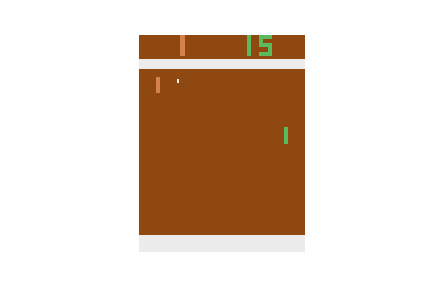
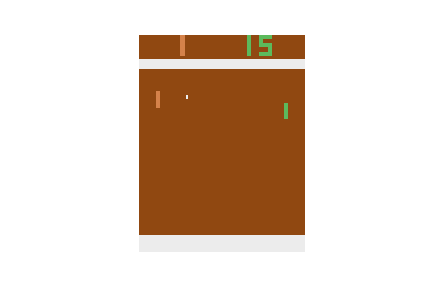
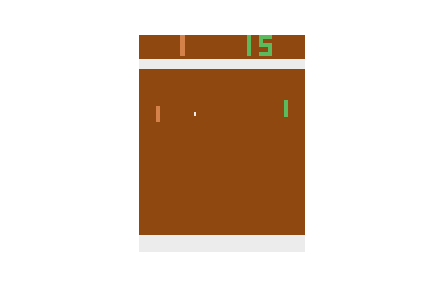
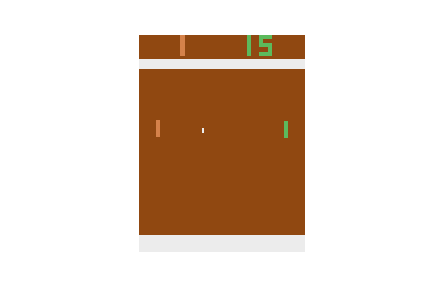
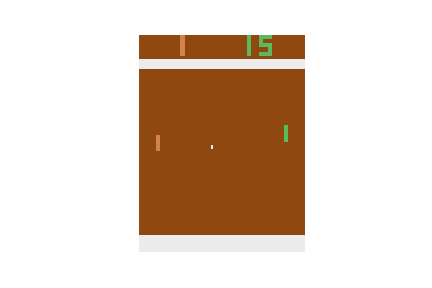
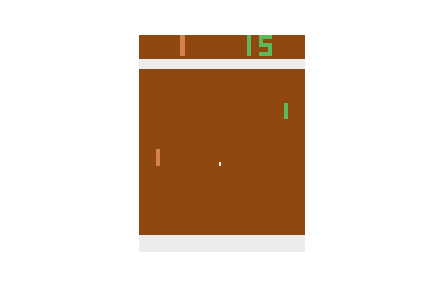
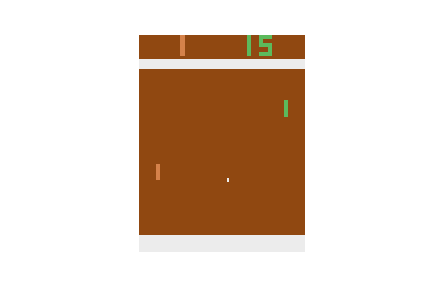
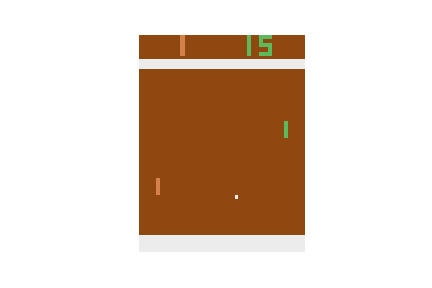
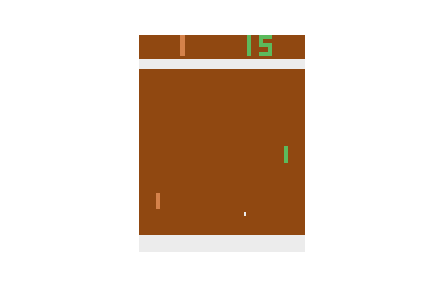
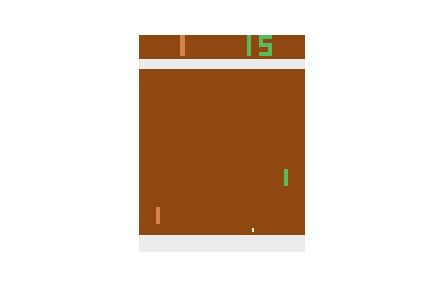
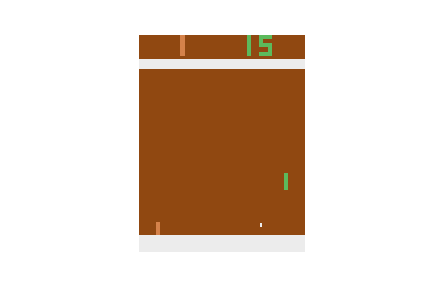
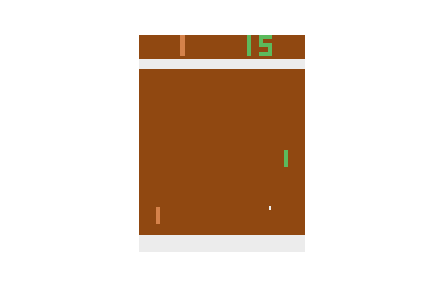
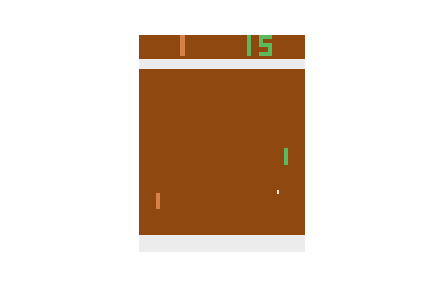
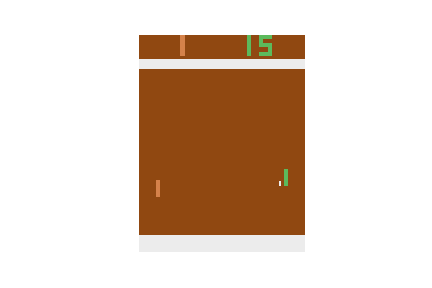
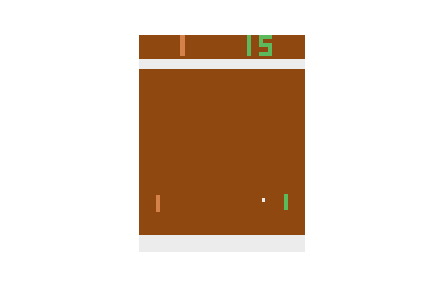
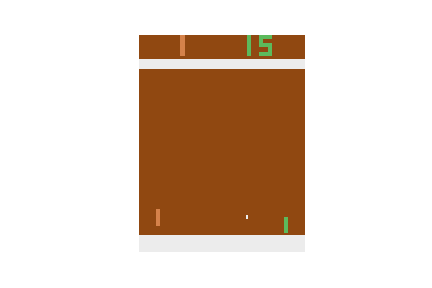
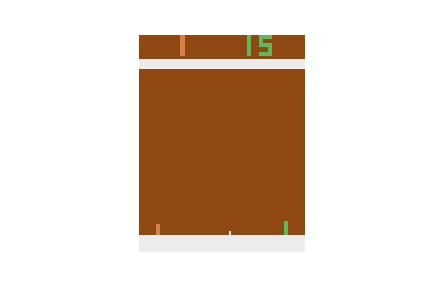
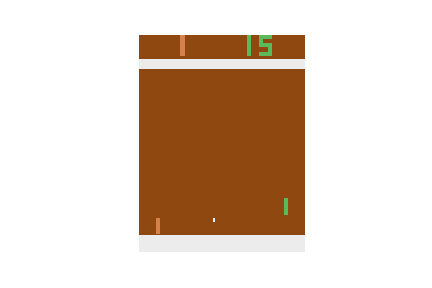
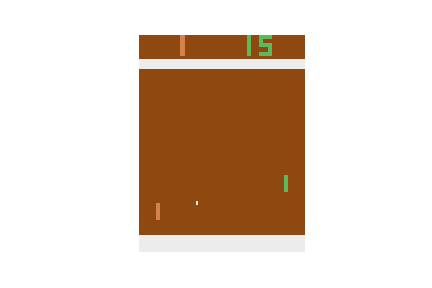
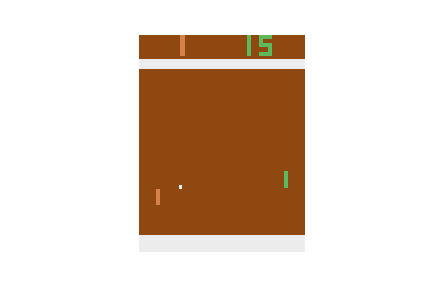
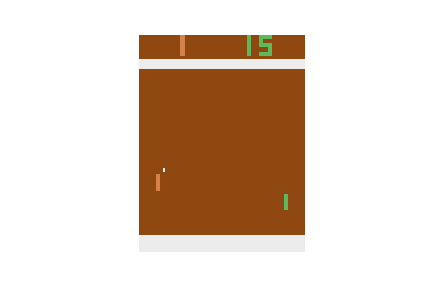
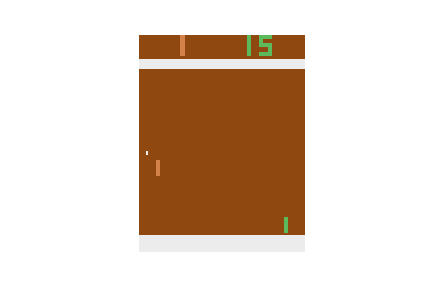
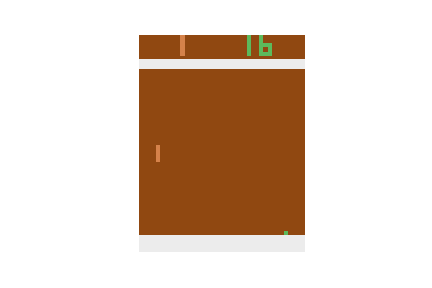
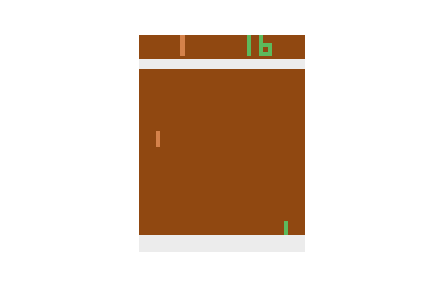
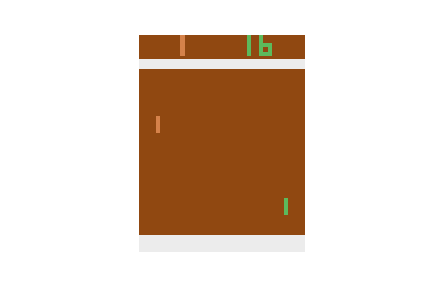
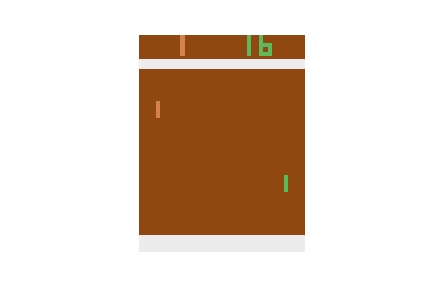
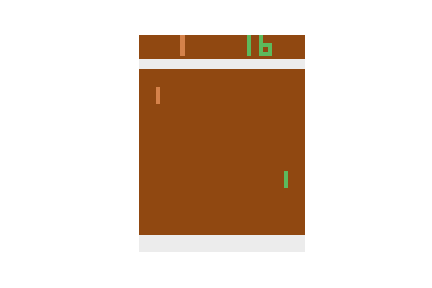
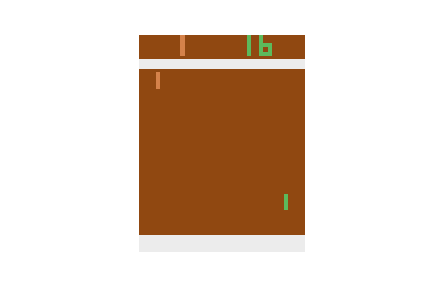
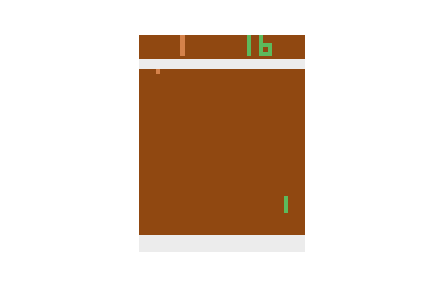
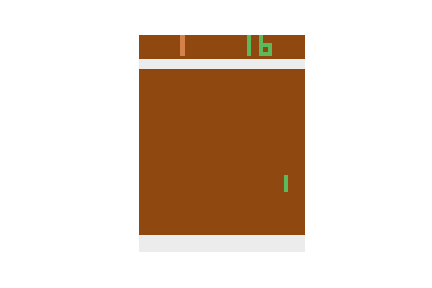
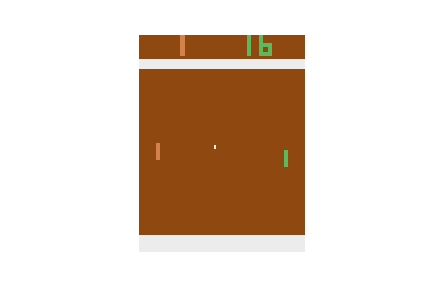
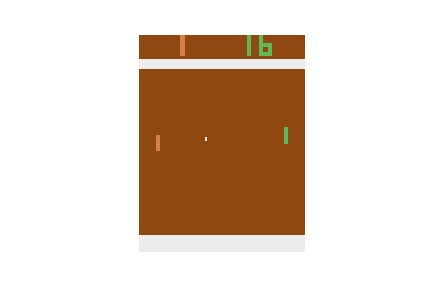
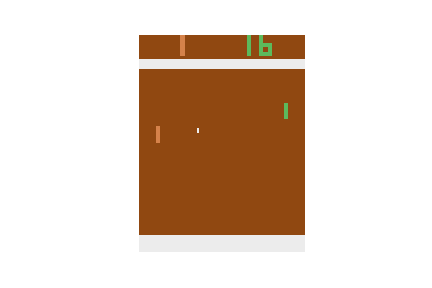
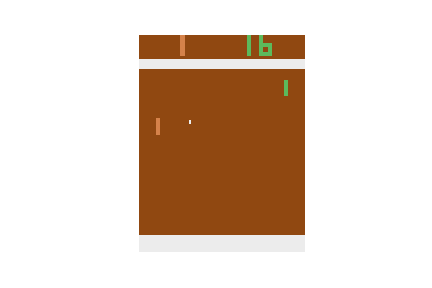
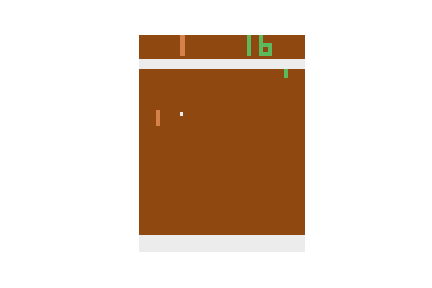
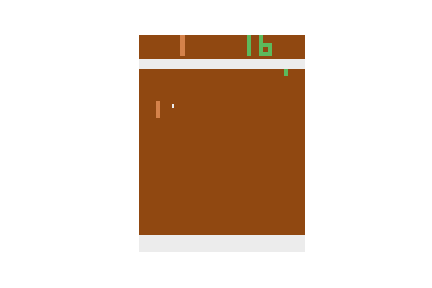
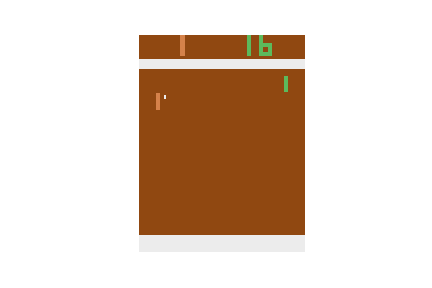
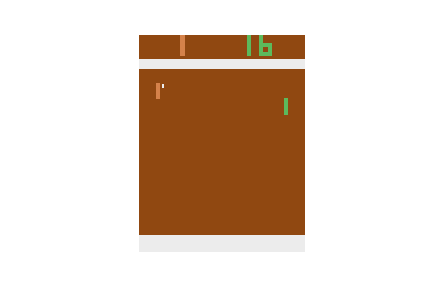
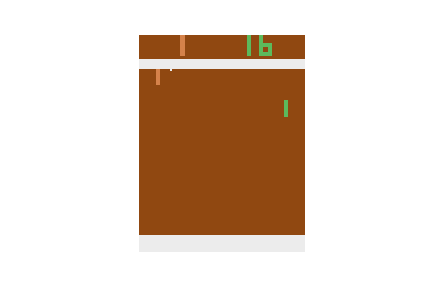
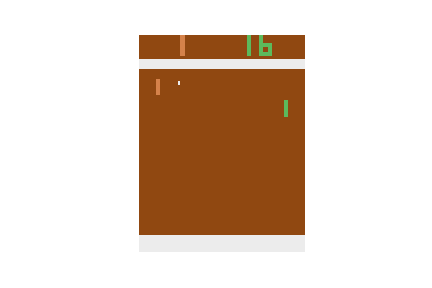
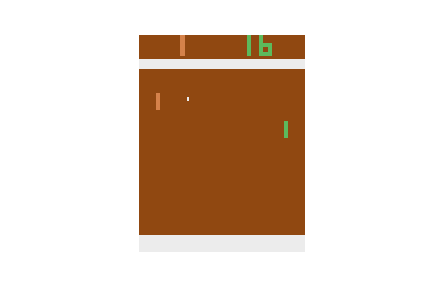
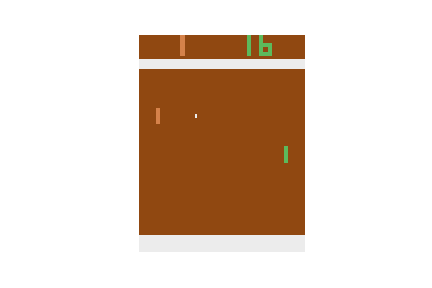
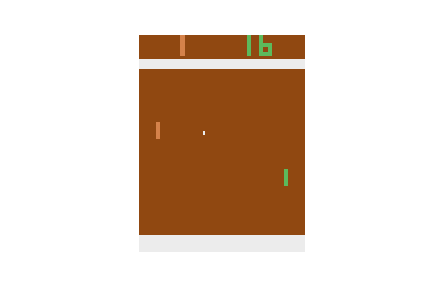
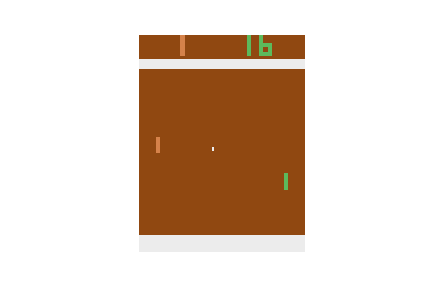
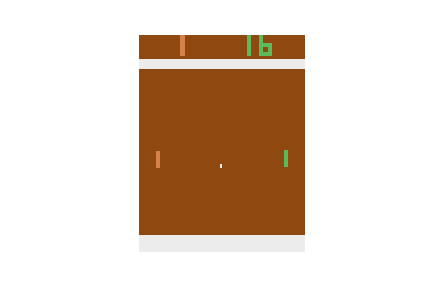
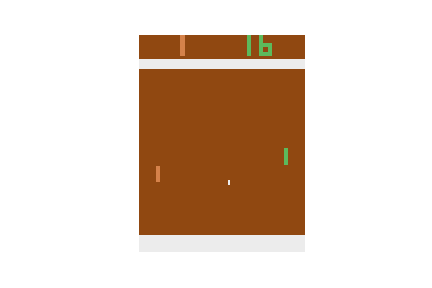
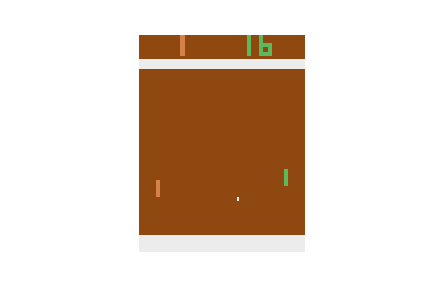
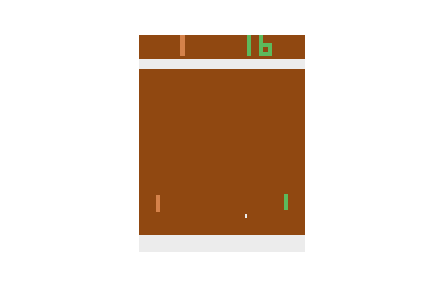
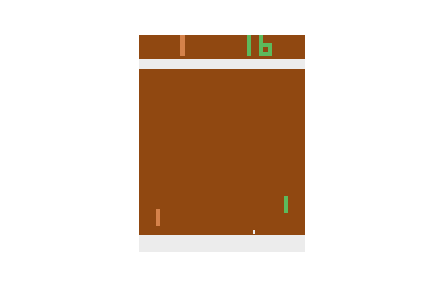
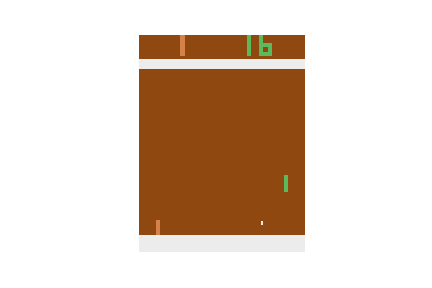
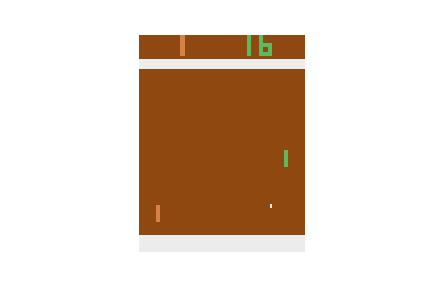
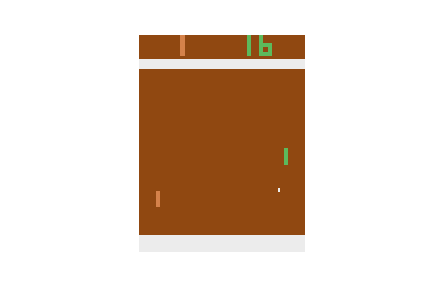
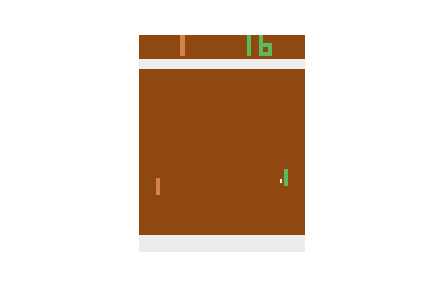
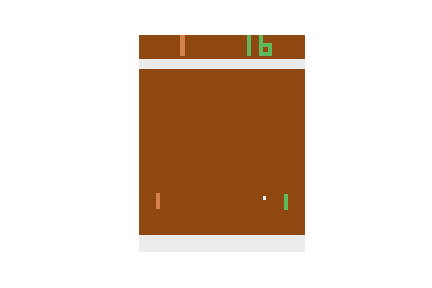
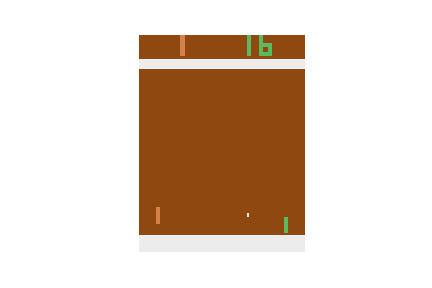
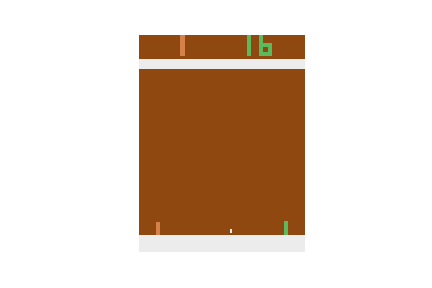
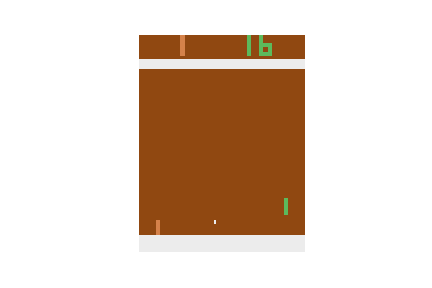
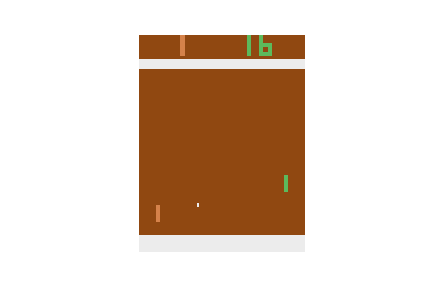
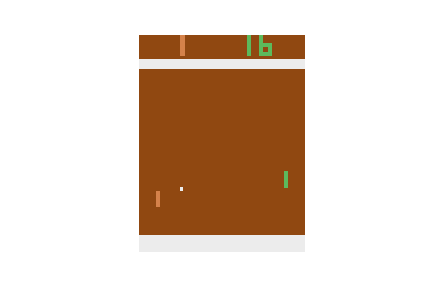
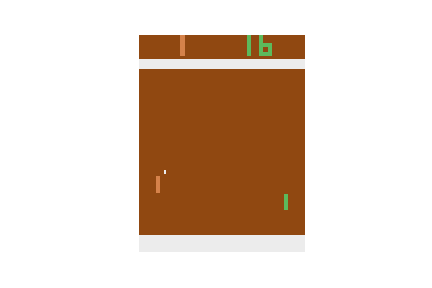
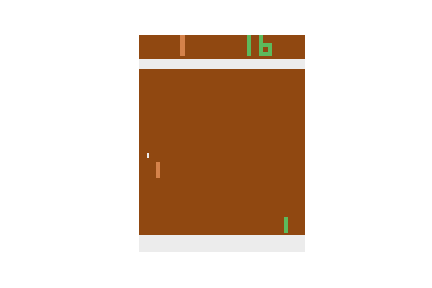
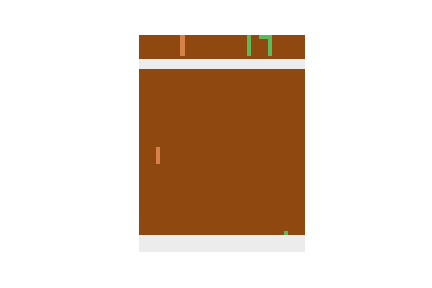
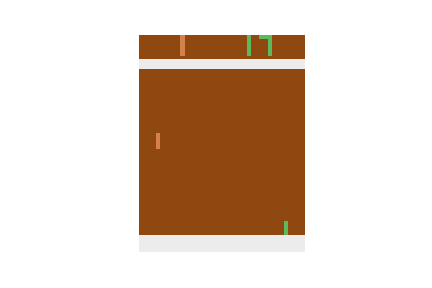
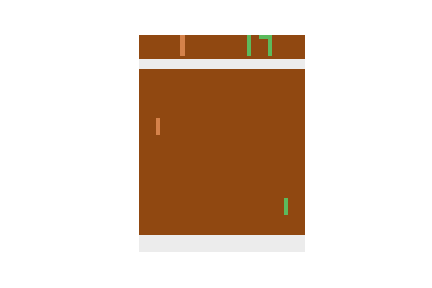
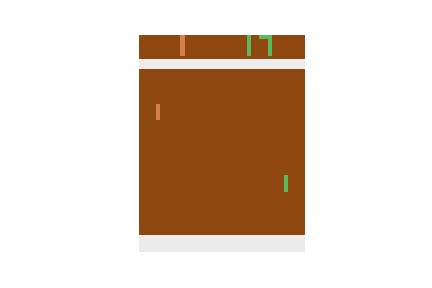
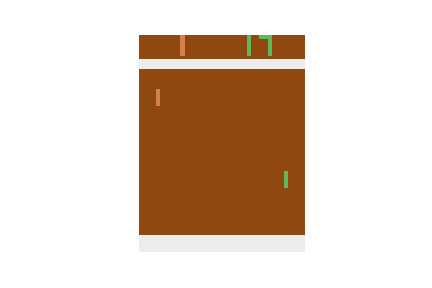
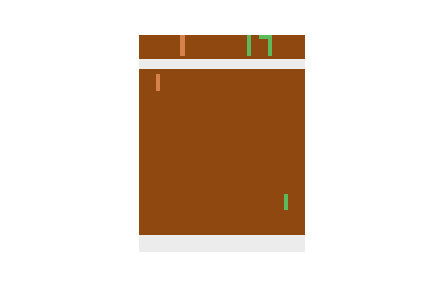
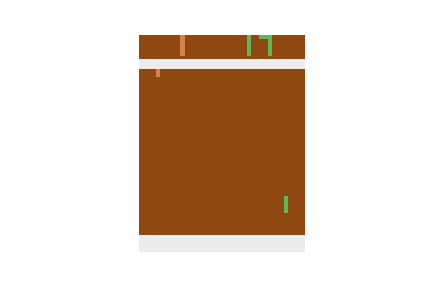
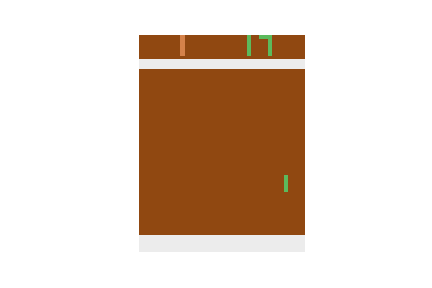
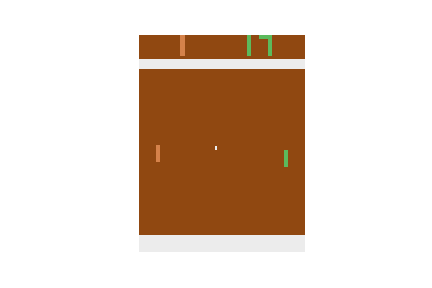
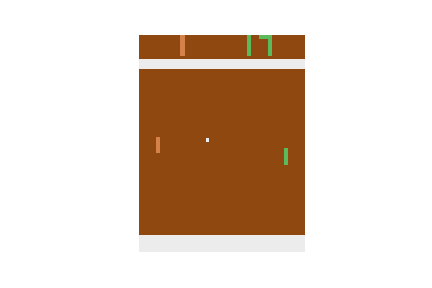
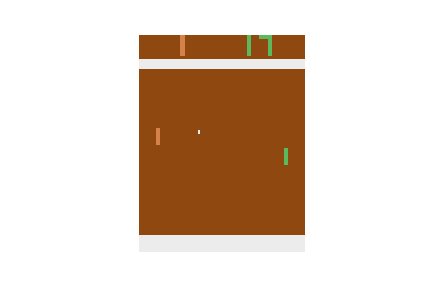
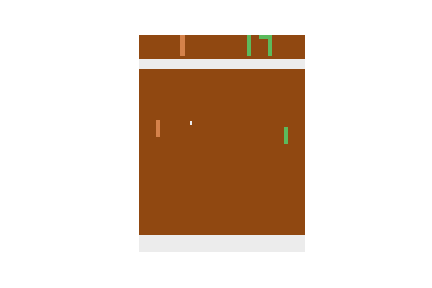
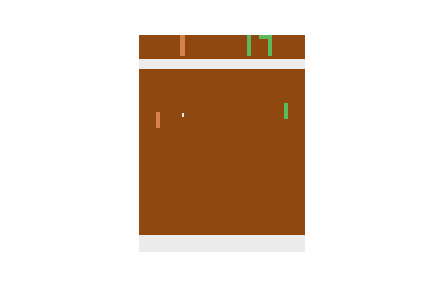
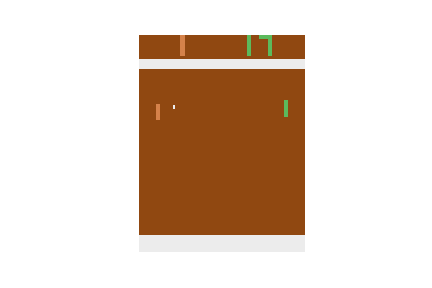
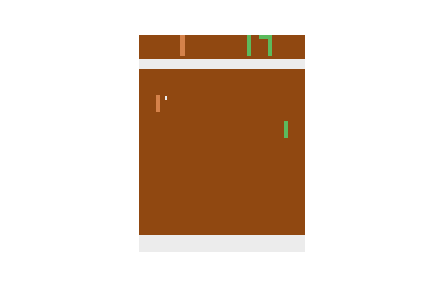
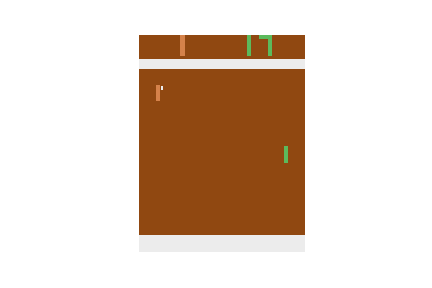
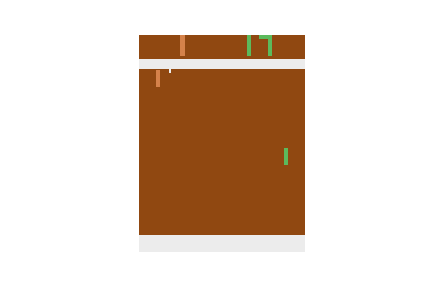
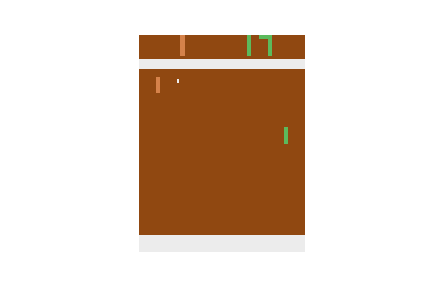
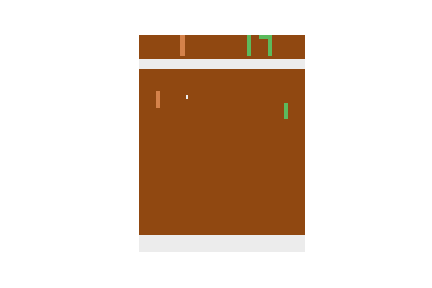
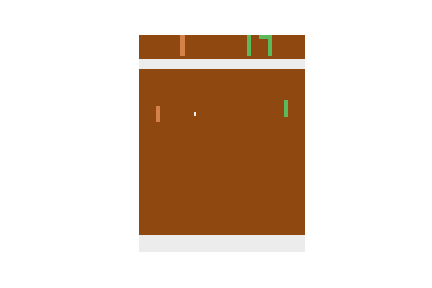
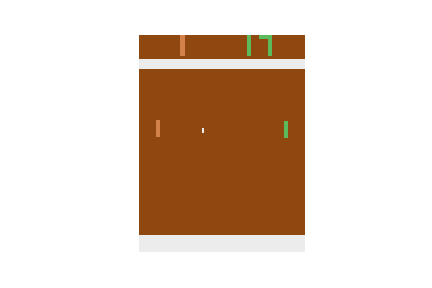
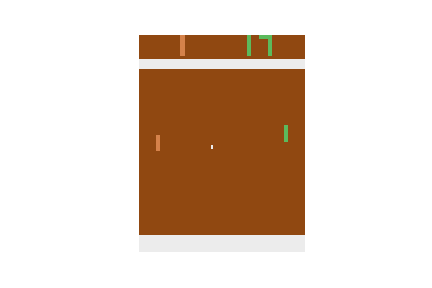
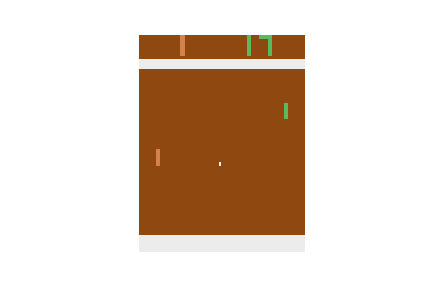
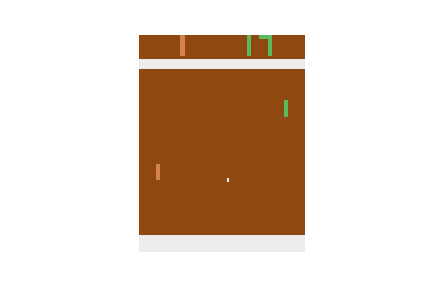
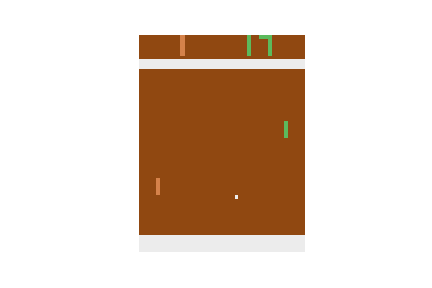
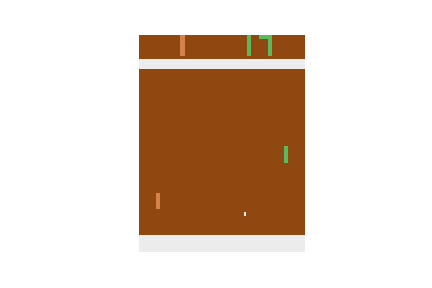
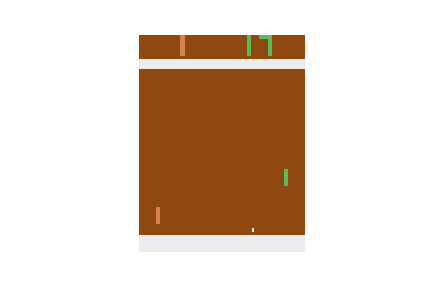
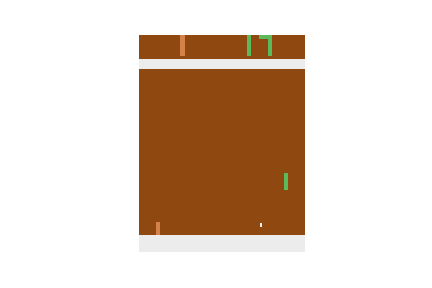
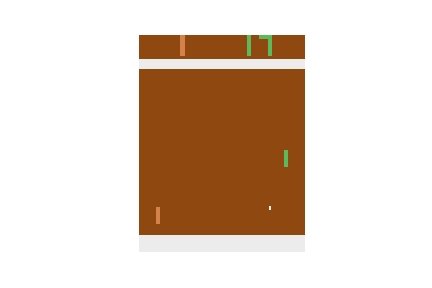
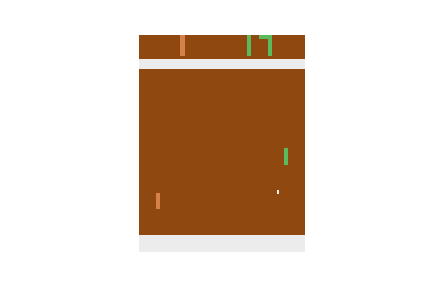
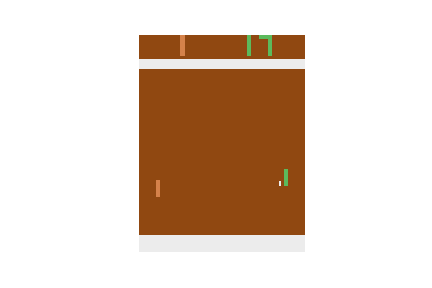
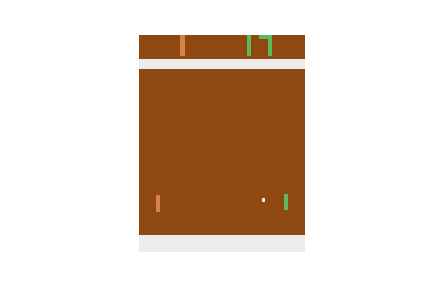
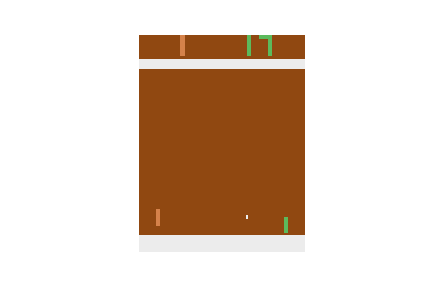
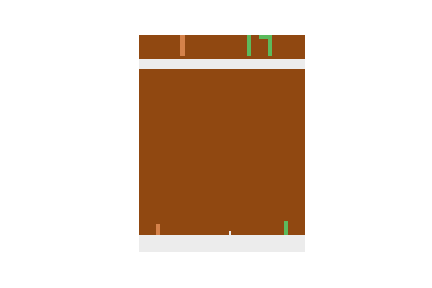
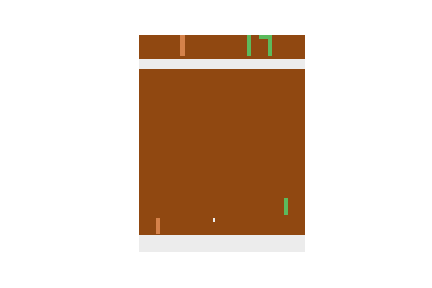
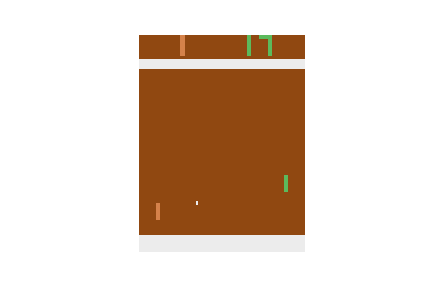
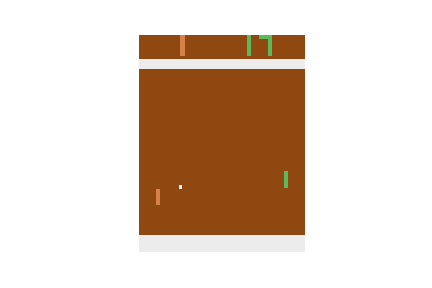
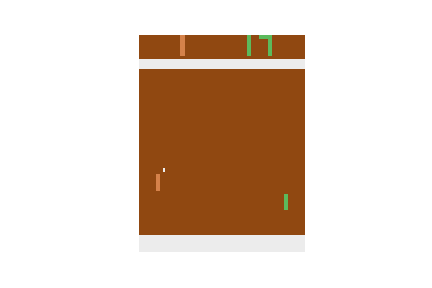
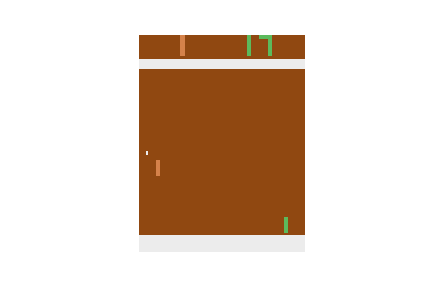
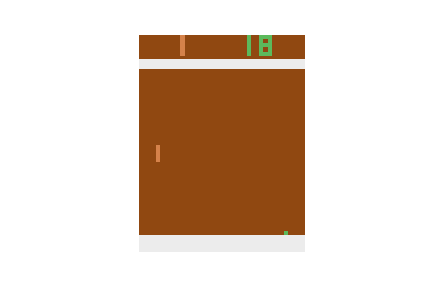
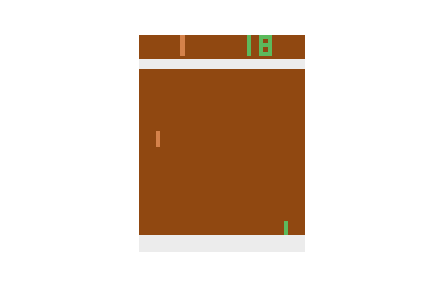
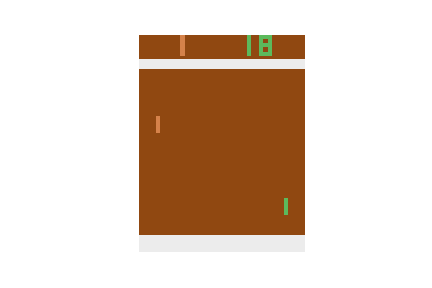
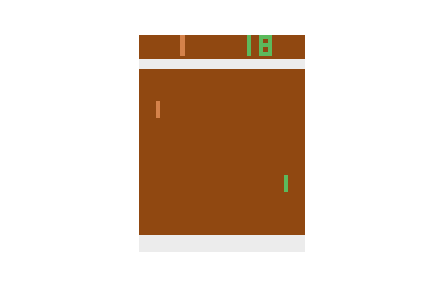
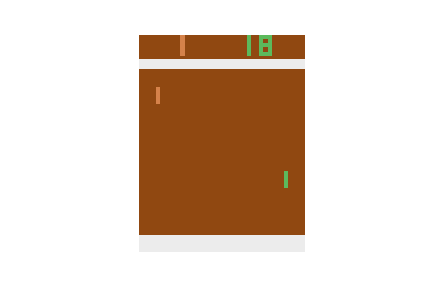
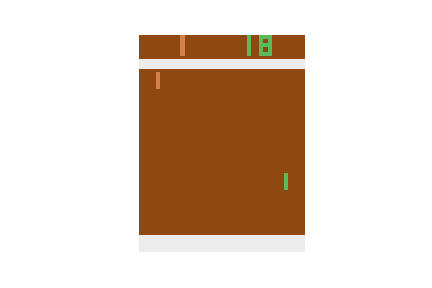
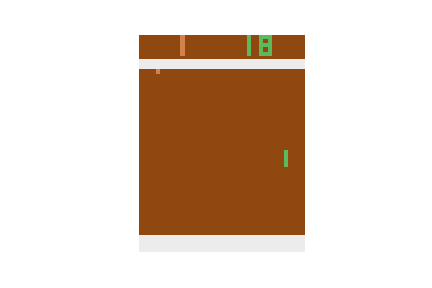
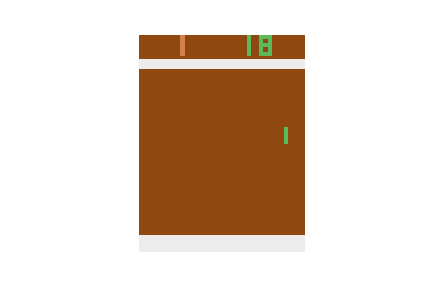
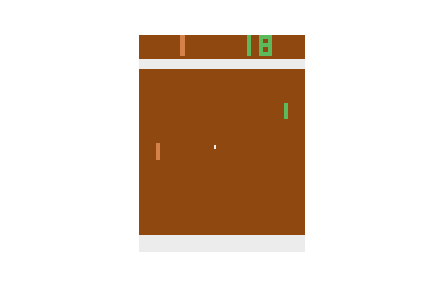
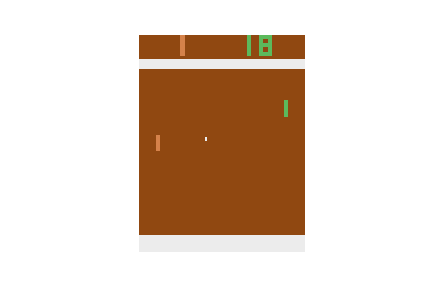
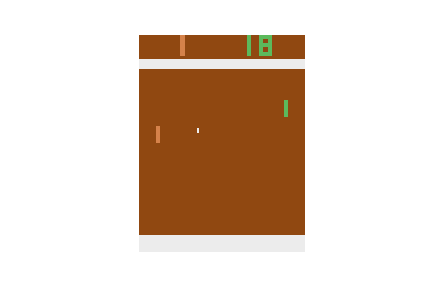
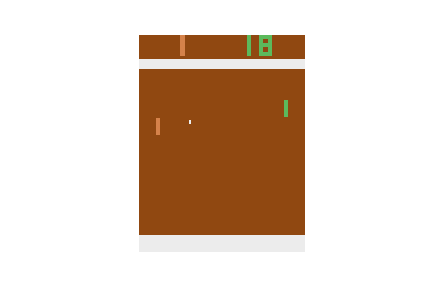
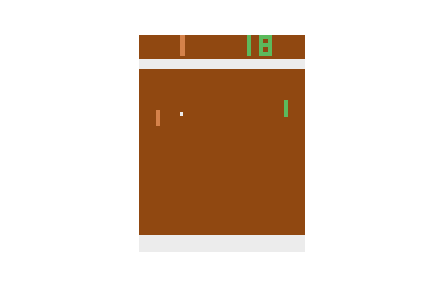
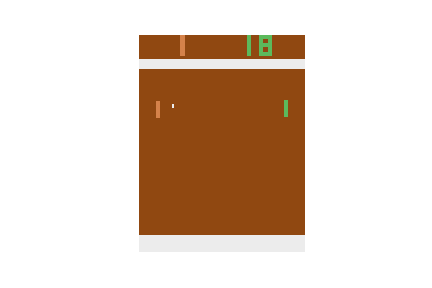
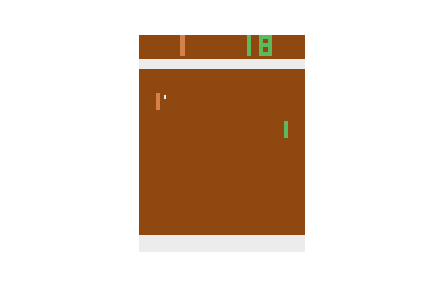
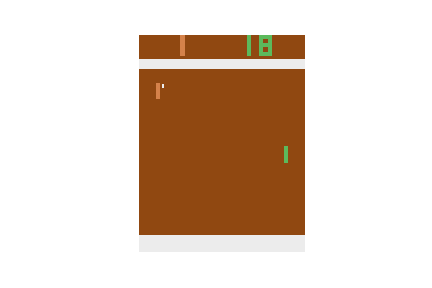
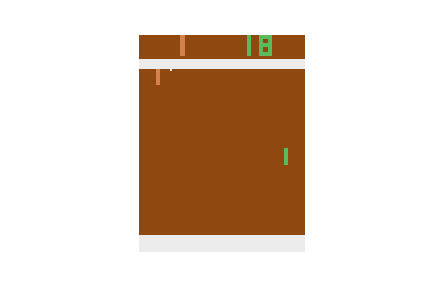
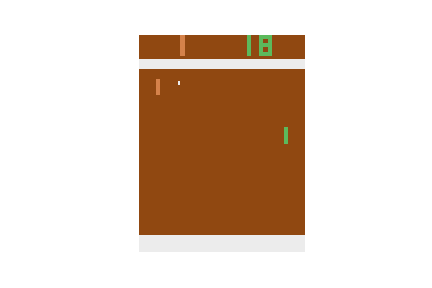
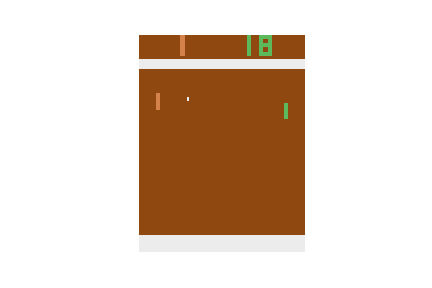
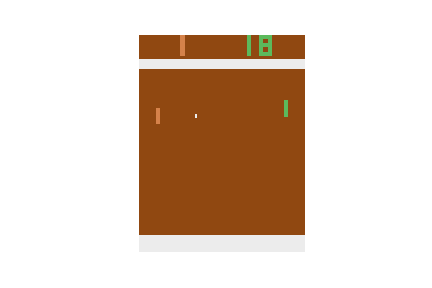
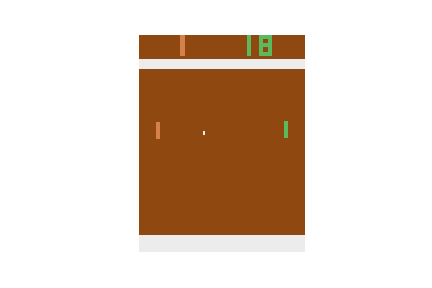
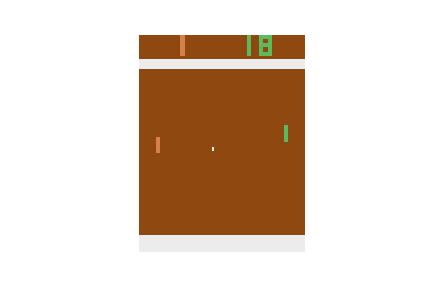
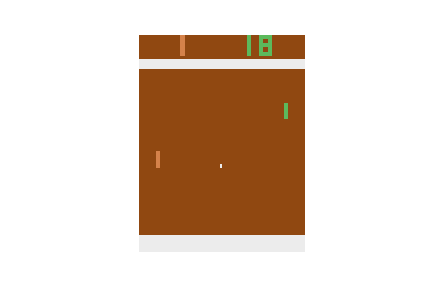
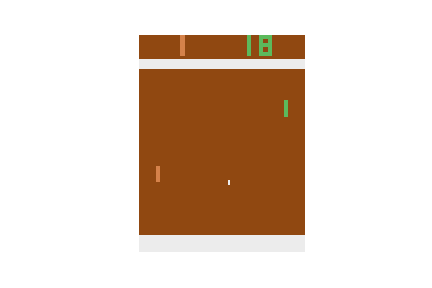
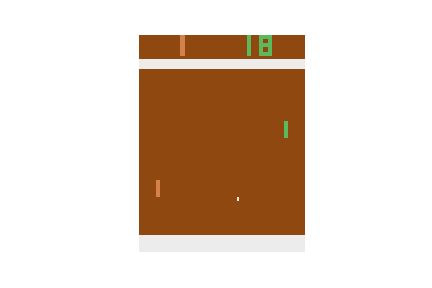
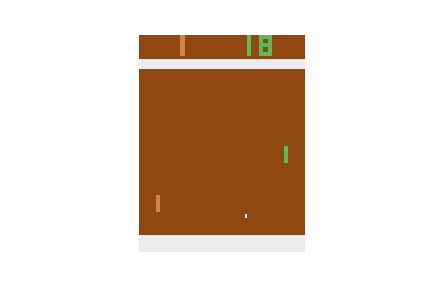
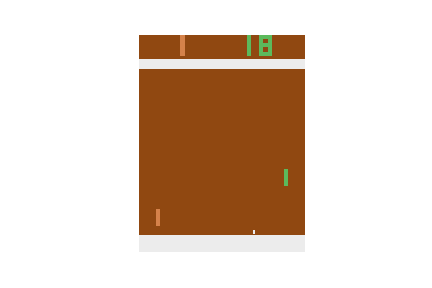
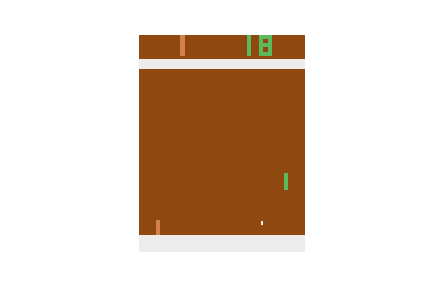
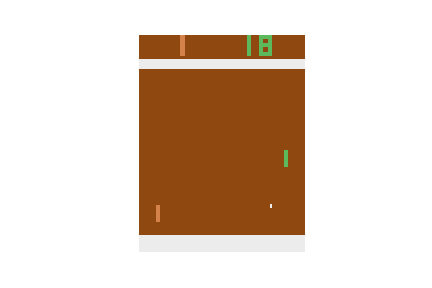
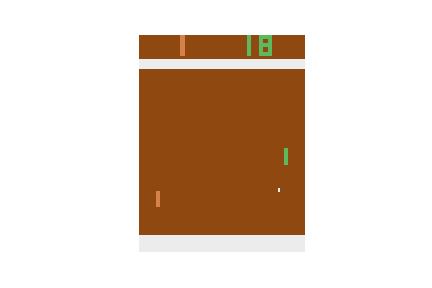
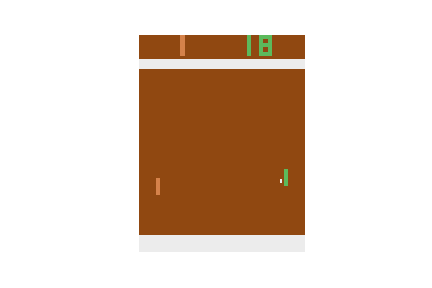
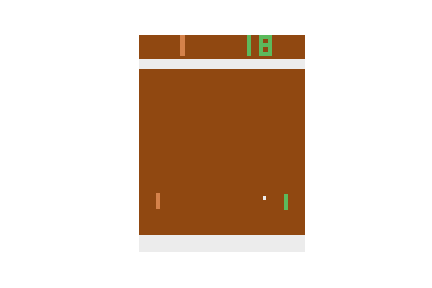
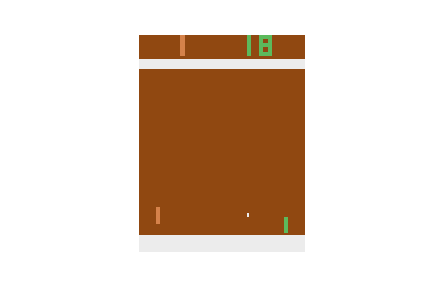
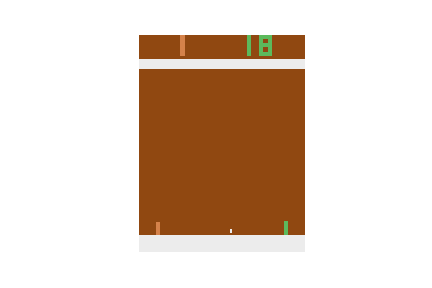
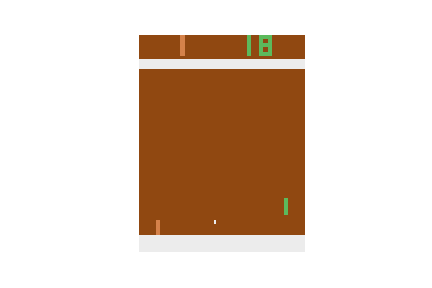
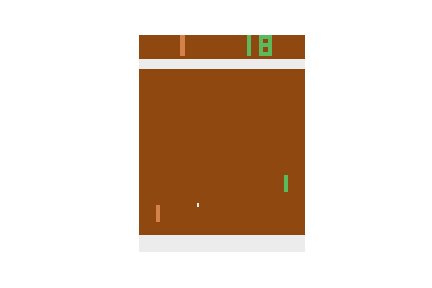
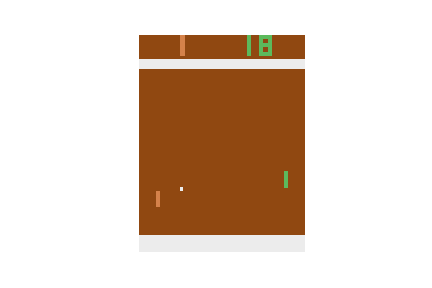
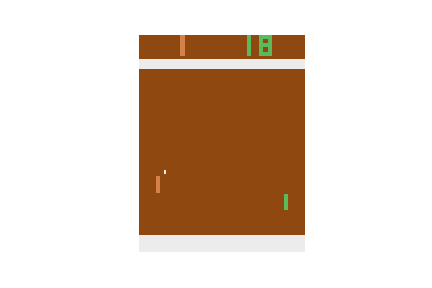
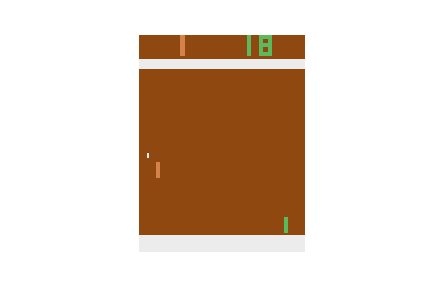
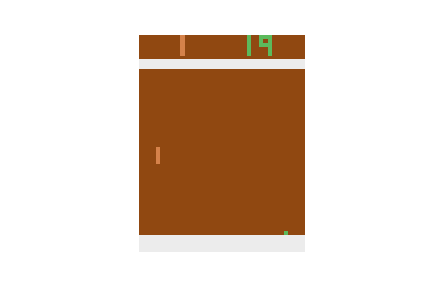
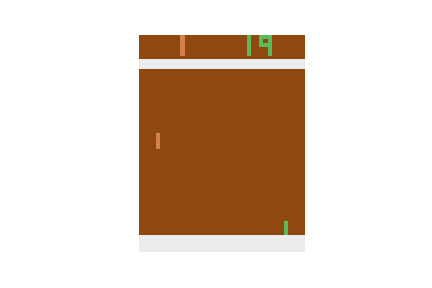
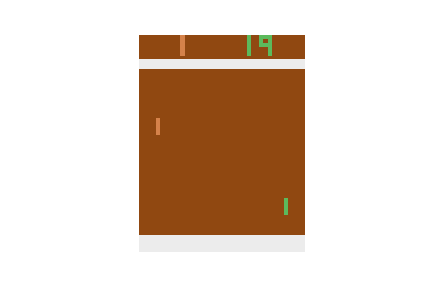
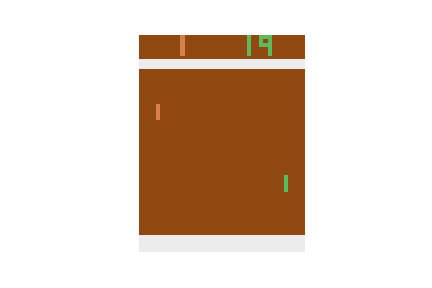
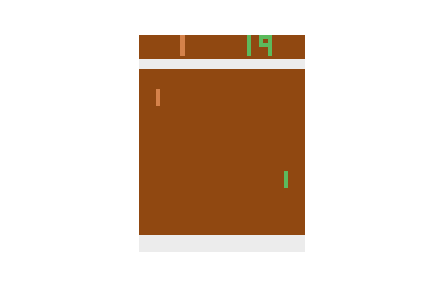
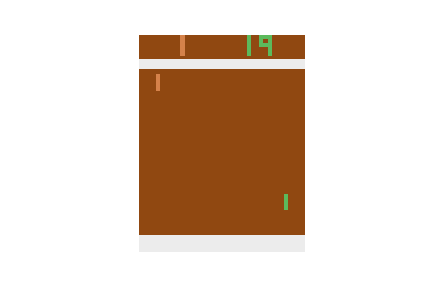
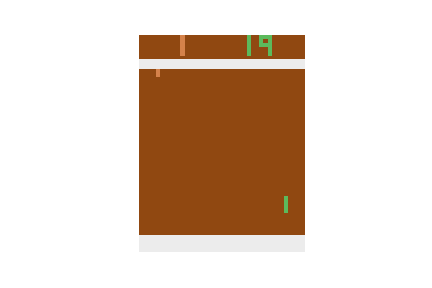
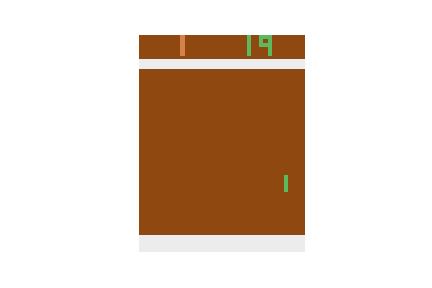
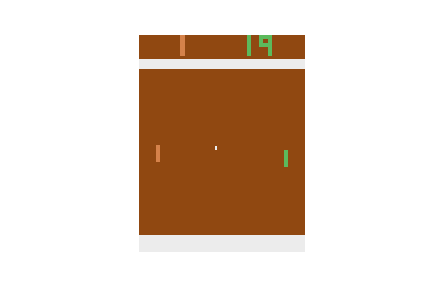
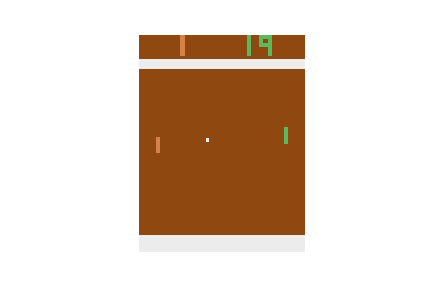
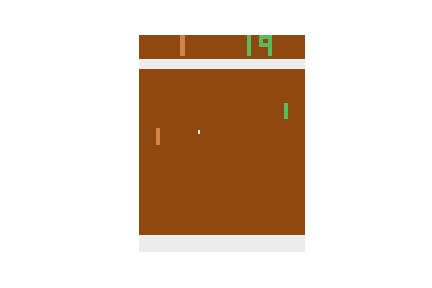
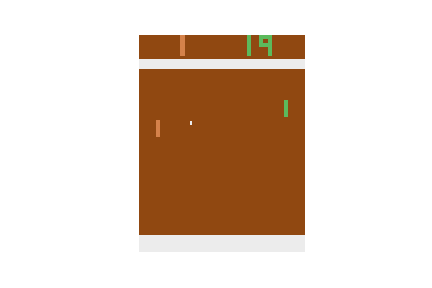
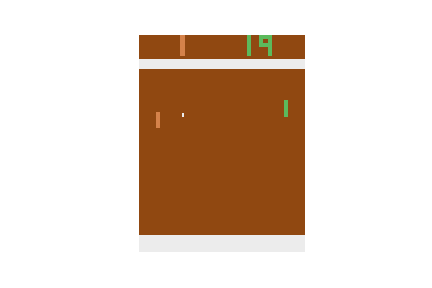
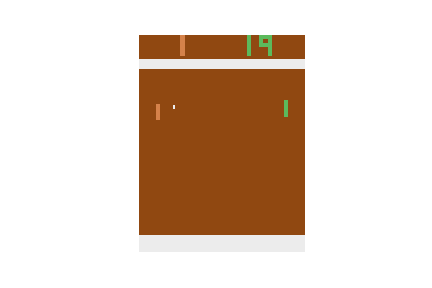
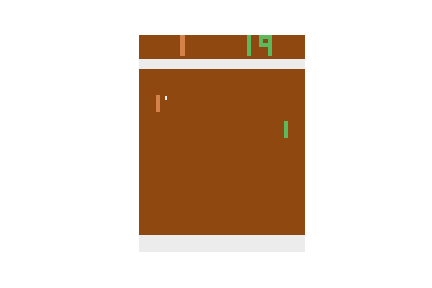
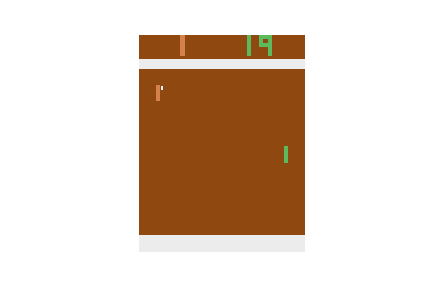
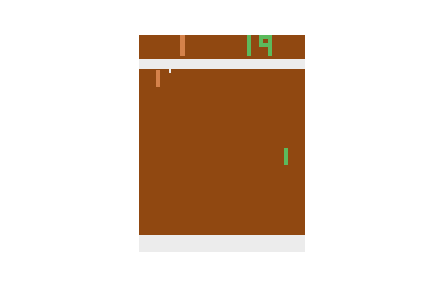
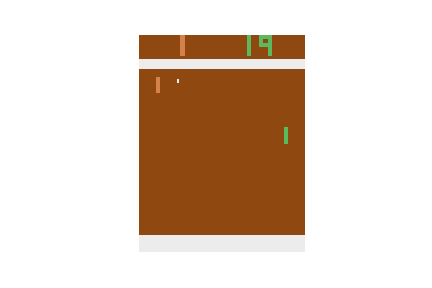
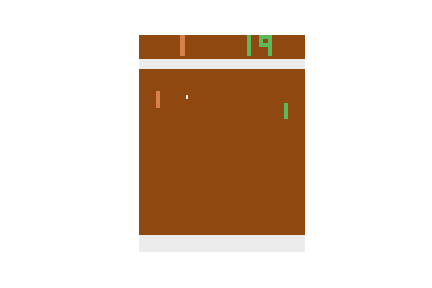
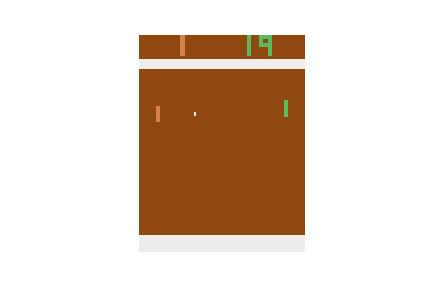
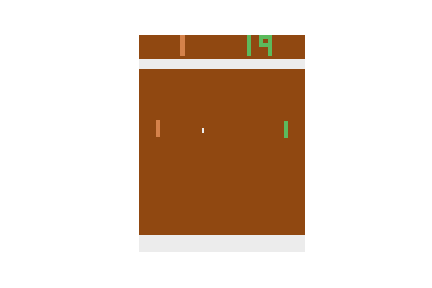
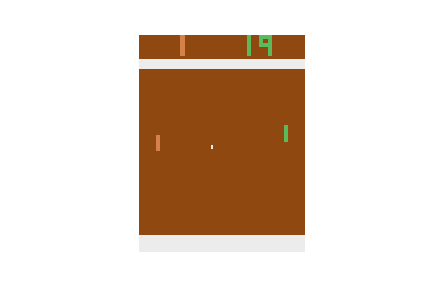
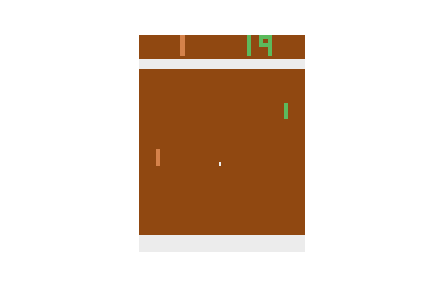
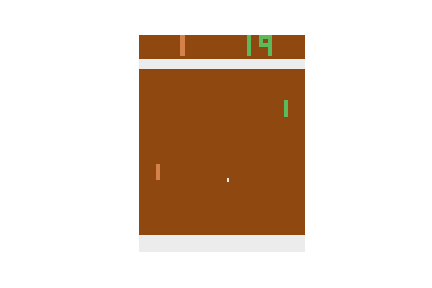
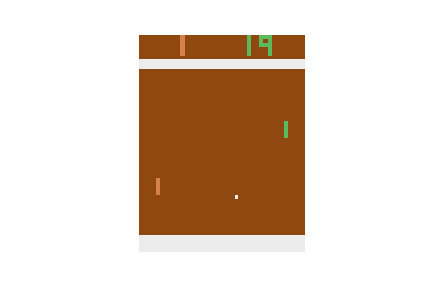
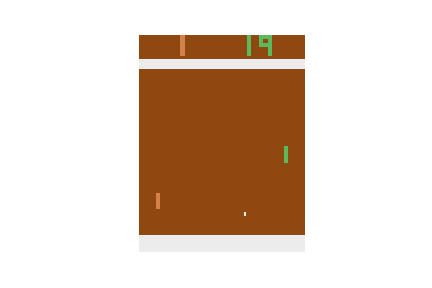
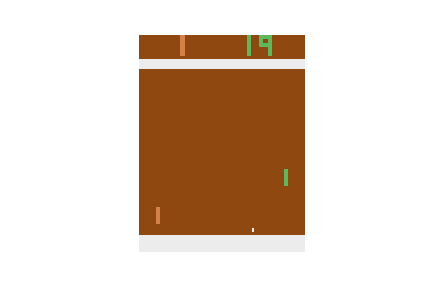
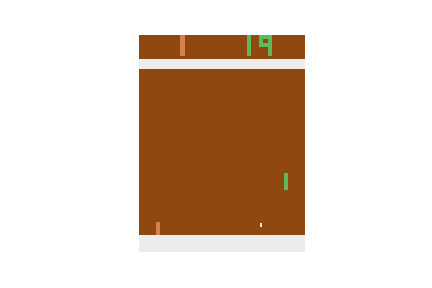
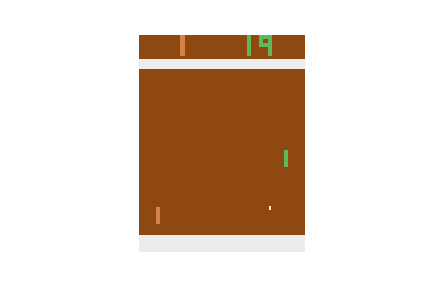
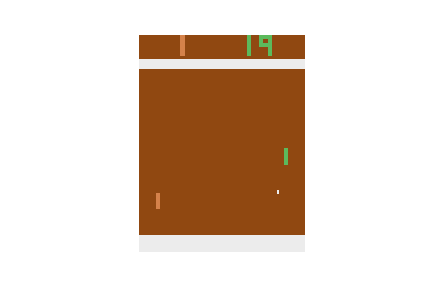
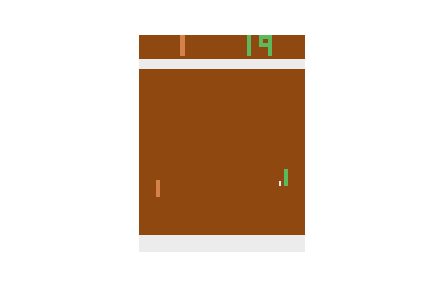
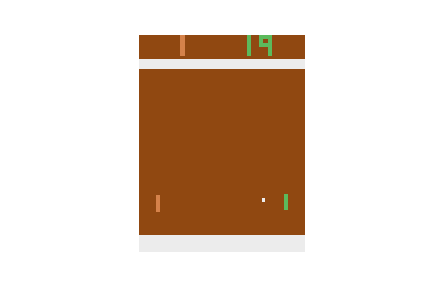
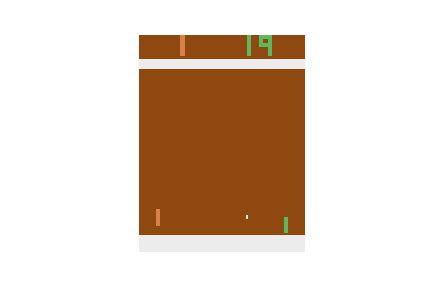
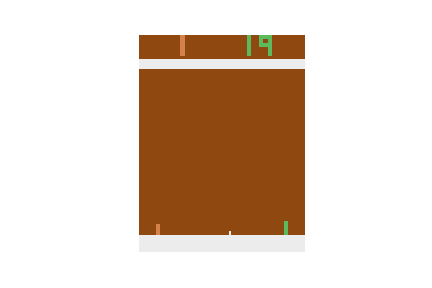
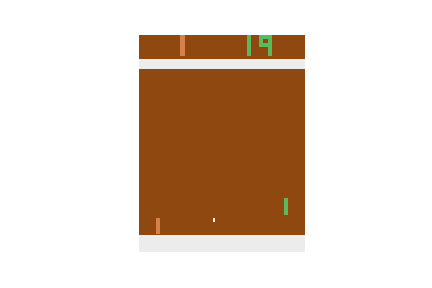
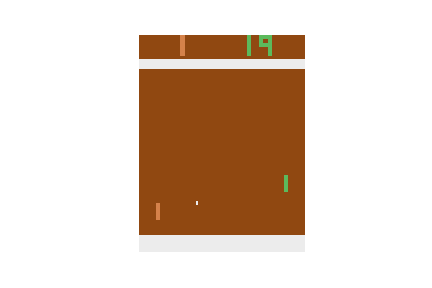
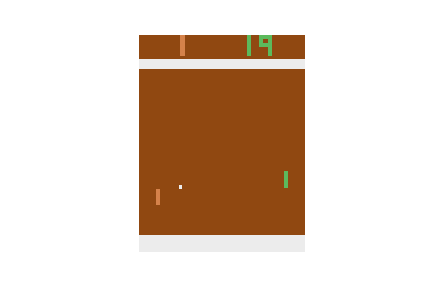
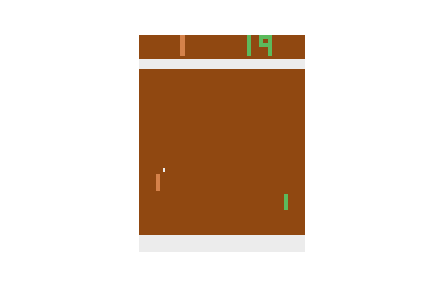
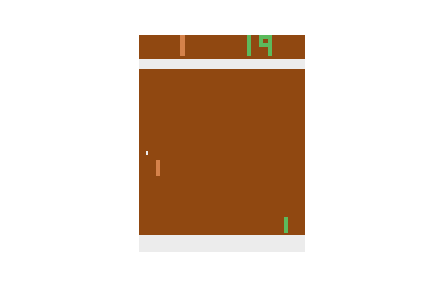
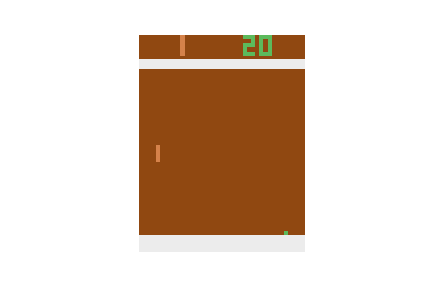
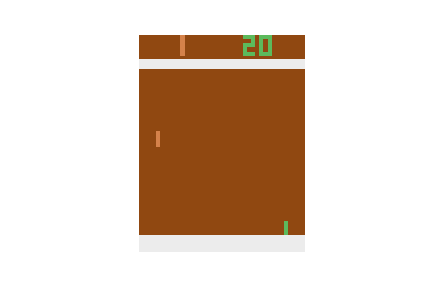
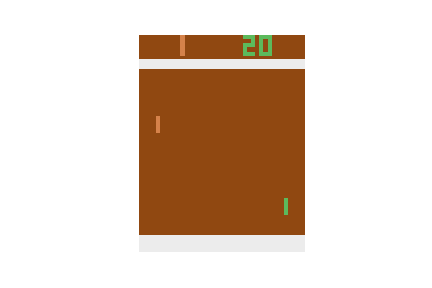
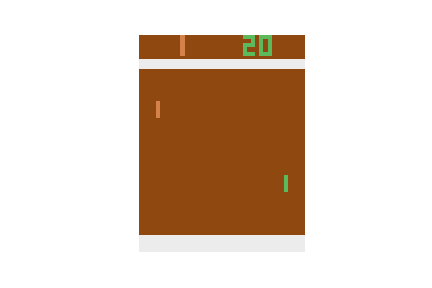
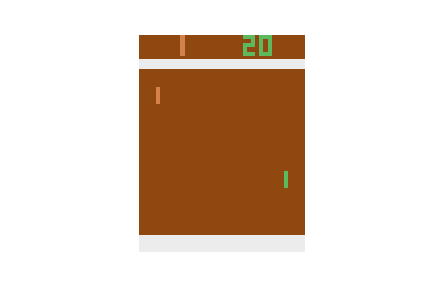
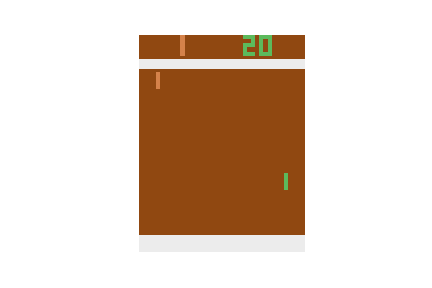
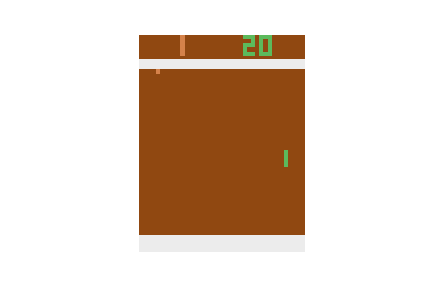
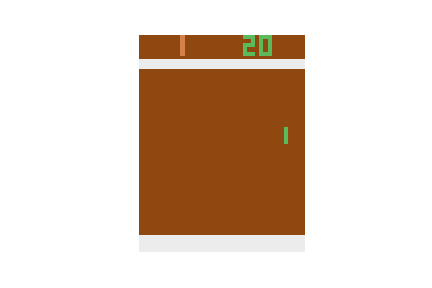
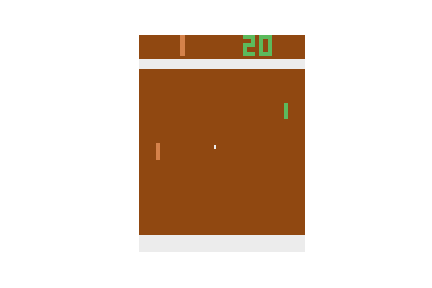
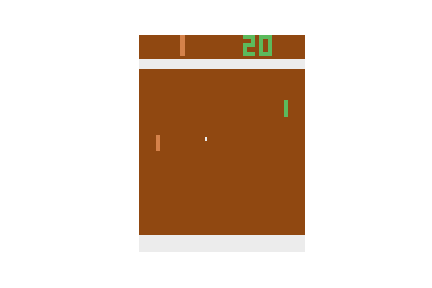
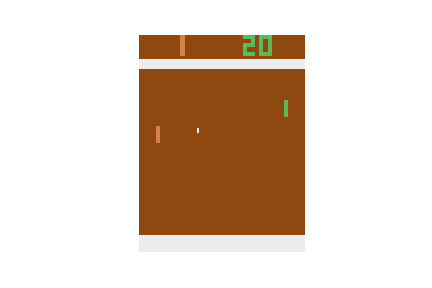
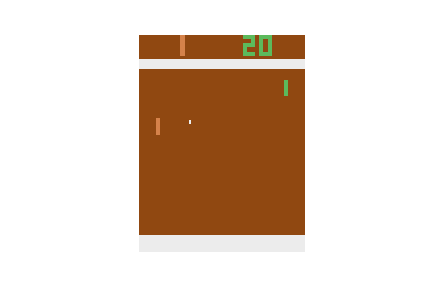
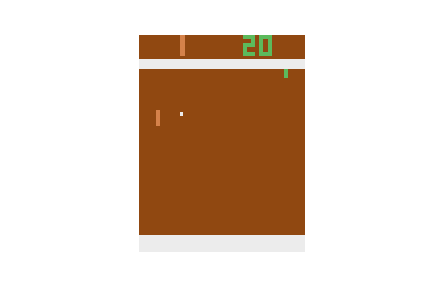
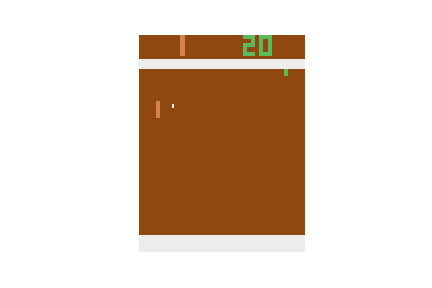
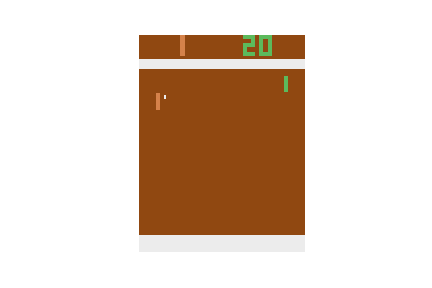
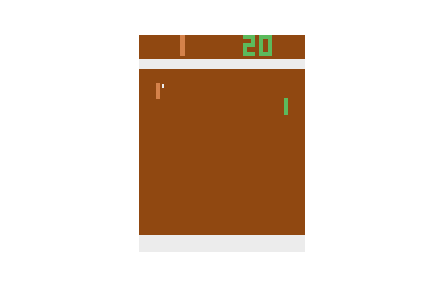
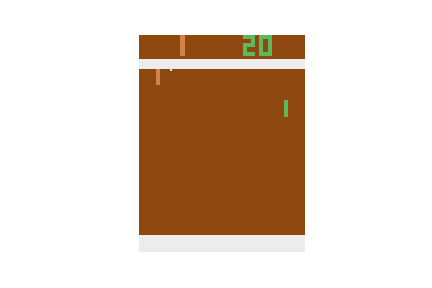
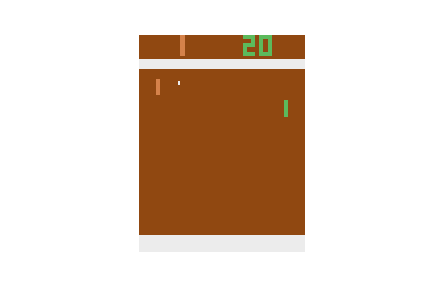
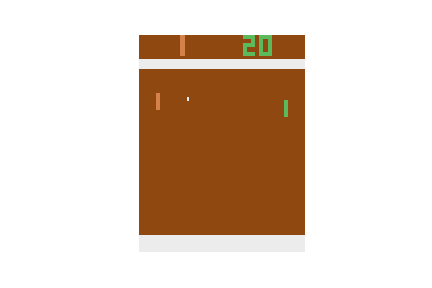
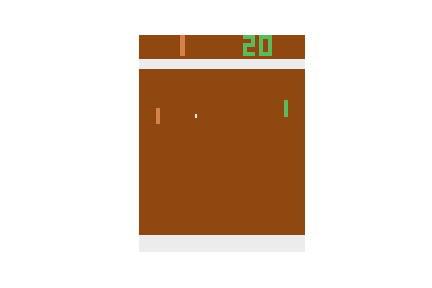
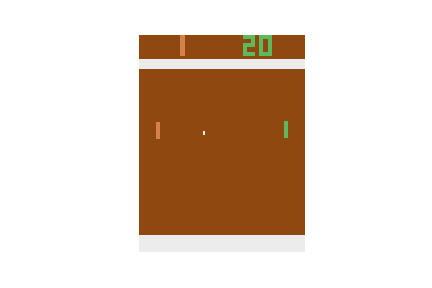
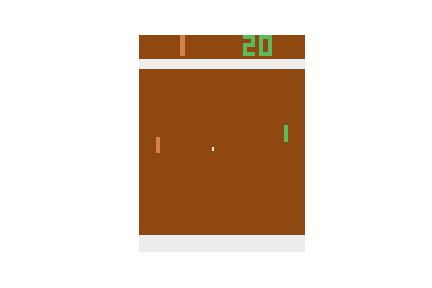
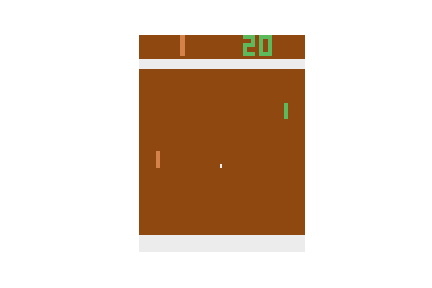
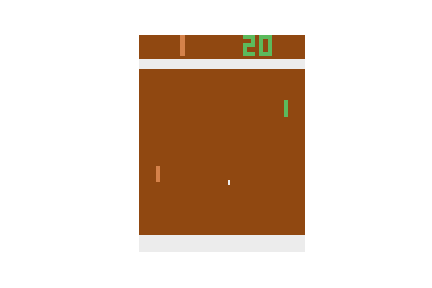
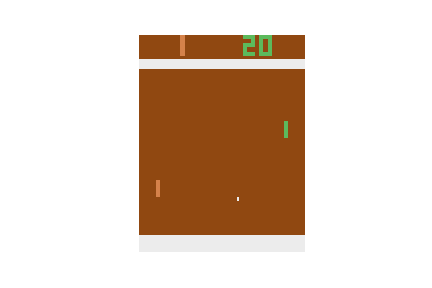
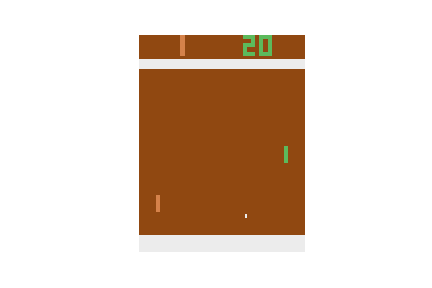
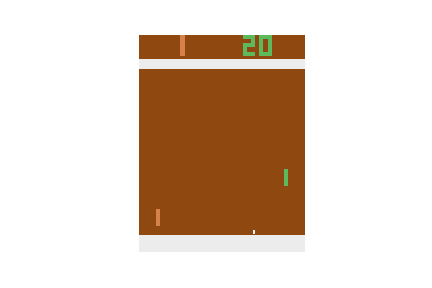
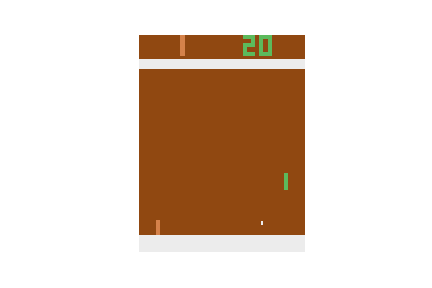
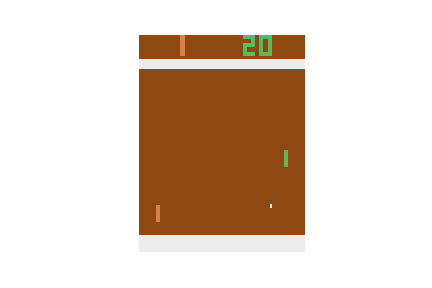
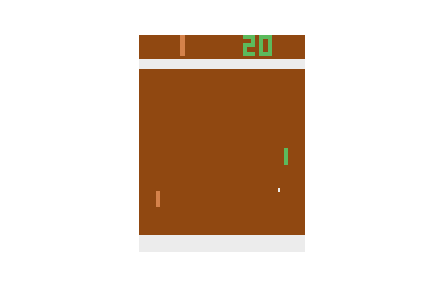
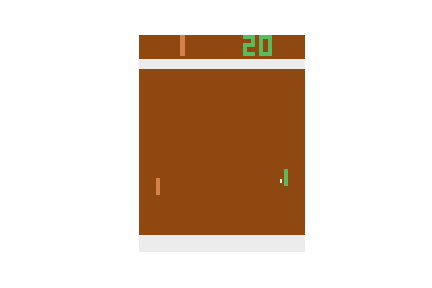
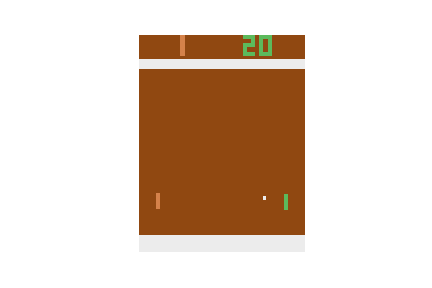
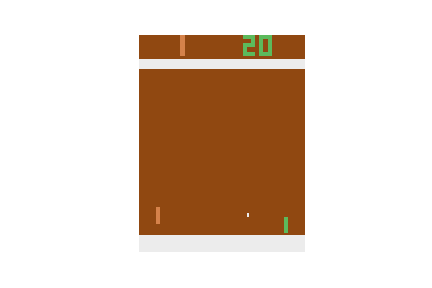
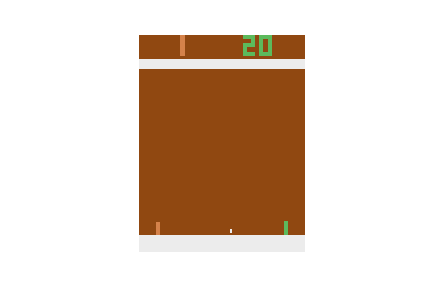
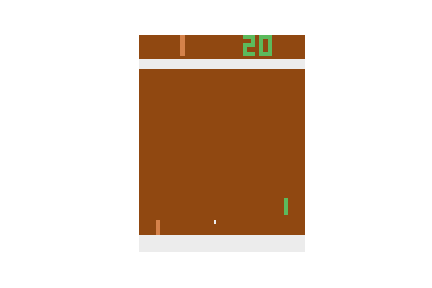
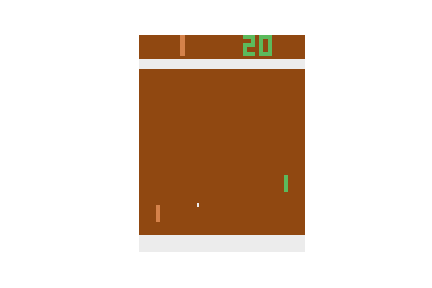
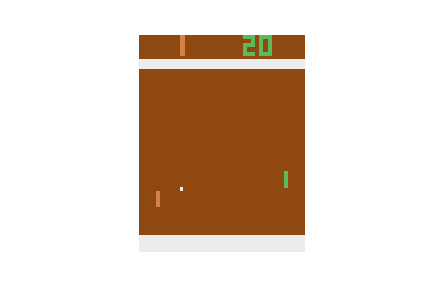
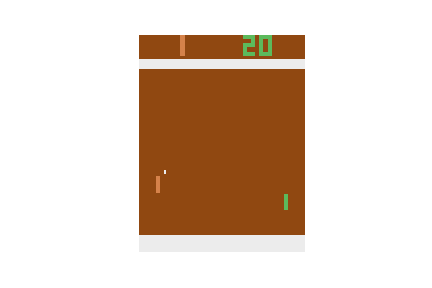
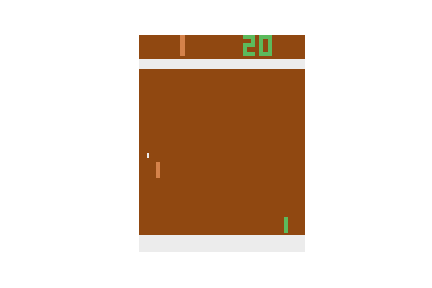

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


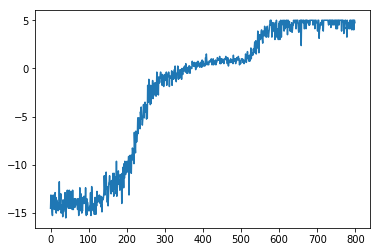

In [15]:
pong_utils.play(env, policy, time=2000)
plt.plot(mean_rewards)
# save your policy!
torch.save(policy, 'Ping_Pong_PPO.policy')